In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  



from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [2]:
query = f'''SELECT * FROM datamarts.marketing_dash
            WHERE created_at BETWEEN '2024-08-01' AND '2025-03-31'
            AND domain_locale='ru'
            AND platform IN ('cloudpayments','payture')
            '''

df = execute(query,user='kmekhtiev')
df['created_at'] = pd.to_datetime(df['created_at'])
df['subscription_date'] =  df['created_at'].dt.strftime("%Y-%m-%d")
df['subscription_date'] =  pd.to_datetime(df['subscription_date'])
df['first_prolong_date'] = pd.to_datetime(df['first_prolong_date'])
df['first_payment_date'] = df['first_prolong_date'].dt.strftime("%Y-%m-%d")
df['first_payment_date'] =  pd.to_datetime(df['first_payment_date'])

Время выполнения функции: 3.6065 секунд



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65822 entries, 0 to 65821
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             65822 non-null  object        
 1   visitor_id          65822 non-null  object        
 2   profile_id          65822 non-null  object        
 3   reg_date            65822 non-null  object        
 4   created_at          65822 non-null  datetime64[ns]
 5   ends_at             65822 non-null  object        
 6   renewal_off_date    65822 non-null  datetime64[ns]
 7   state               65822 non-null  object        
 8   price_cents         65822 non-null  int64         
 9   offer_duration      65822 non-null  object        
 10  recurrent           65822 non-null  object        
 11  bonus_title         65822 non-null  object        
 12  promo               65822 non-null  object        
 13  ub_type             65822 non-null  object    

# Успешные списания и продления

## Конверсия помесячно из триала в оплату и количество пользователей

In [6]:
df['payment_type'] = df['first_payment_date'].apply(lambda x:0 if x==pd.to_datetime('1970-01-01') else 1)
df['subscription_month'] = df['subscription_date'].dt.to_period('M')
df['subscription_month'] = df['subscription_month'].dt.to_timestamp()  

In [7]:
df_agg = df.groupby('subscription_month',as_index=False).agg({'profile_id':'count','payment_type':'sum'})
df_agg.rename(columns={'profile_id':'trial_cnt','payment_type':'paid_cnt'},inplace=True)
df_agg['cr_to_payment'] = df_agg['paid_cnt']/df_agg['trial_cnt']

In [8]:
df_agg

subscription_month  trial_cnt  paid_cnt  cr_to_payment
0         2024-08-01       6490      1756       0.270570
1         2024-09-01       4988      1386       0.277867
2         2024-10-01       7175      2055       0.286411
3         2024-11-01       9199      2599       0.282531
4         2024-12-01      10200      2829       0.277353
5         2025-01-01      10142      2628       0.259120
6         2025-02-01       8096      2352       0.290514
7         2025-03-01       9532      2784       0.292069

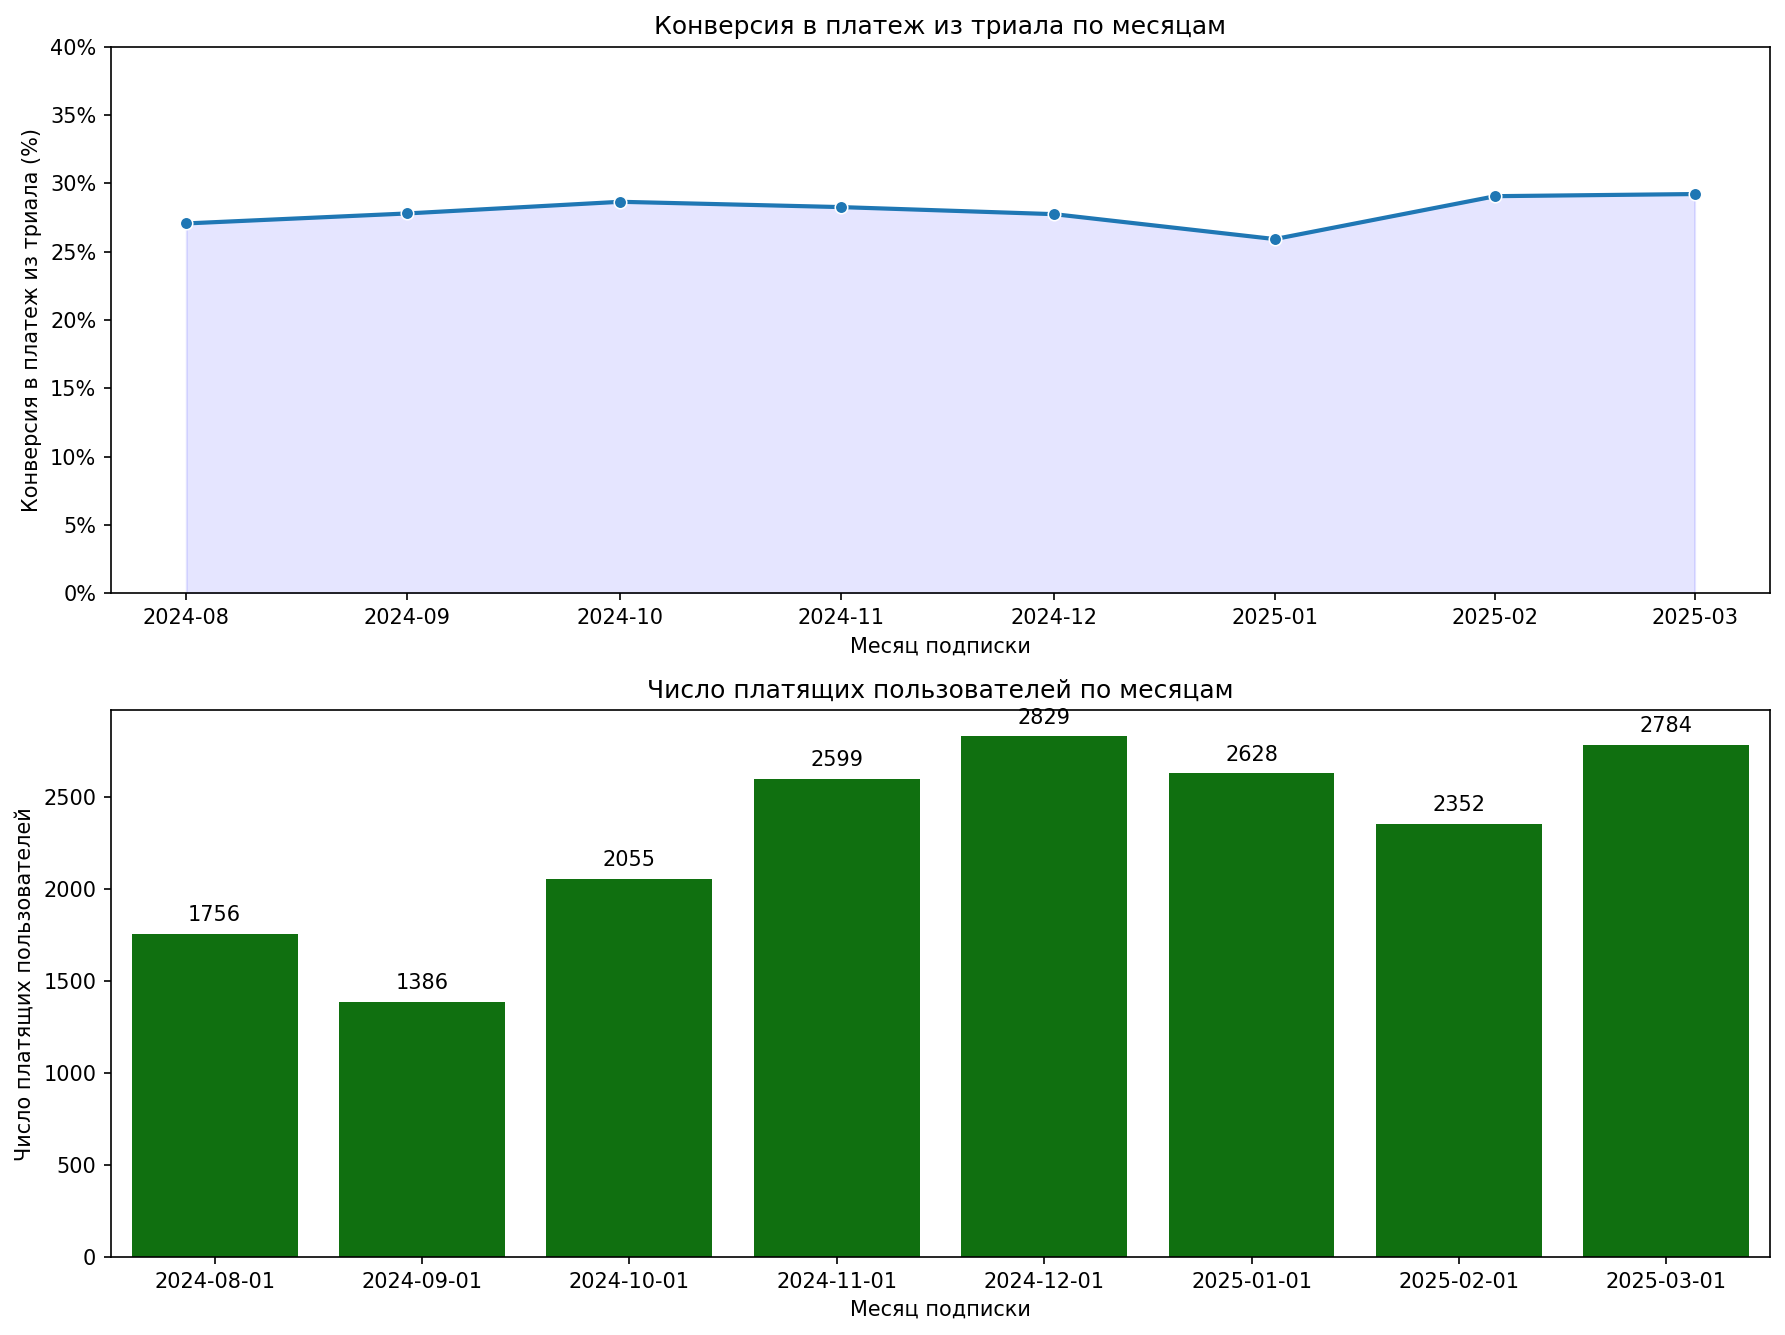

In [9]:
import matplotlib.ticker as ticker  

# Создаем figure и axes (два графика в одной строке)  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), dpi=150) 

# --- Первый график (cr_to_payment) ---  
sns.lineplot(data=df_agg, x='subscription_month', y='cr_to_payment', marker='o', palette='magma', linestyle='-', linewidth=2, ax=ax1)  
ax1.fill_between(df_agg['subscription_month'], df_agg['cr_to_payment'], color='blue', alpha=0.1)  
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax1.set_ylim(bottom=0, top=0.4)  
ax1.set_xlabel("Месяц подписки")  
ax1.set_ylabel("Конверсия в платеж из триала (%)")  
ax1.set_title("Конверсия в платеж из триала по месяцам")  

# --- Второй график (paid_cnt) ---  
barplot = sns.barplot(data=df_agg, x='subscription_month', y='paid_cnt', color='green',ax=ax2) 
ax2.set_xlabel("Месяц подписки")  
ax2.set_ylabel("Число платящих пользователей")  
ax2.set_title("Число платящих пользователей по месяцам")  
ax2.ticklabel_format(style='plain', axis='y') # Отключаем научную нотацию  

for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 

plt.tight_layout() 
plt.show()  

In [10]:
print('Медианное значение CR за 6 месяцев:',round(df_agg['cr_to_payment'].median(),4))
print('Медианное значение уникальных пользователей за 6 месяцев:',int(df_agg['paid_cnt'].median()))

Медианное значение CR за 6 месяцев: 0.2802
Медианное значение уникальных пользователей за 6 месяцев: 2475


## Отдельно по триалам 3 и 14 дней

In [12]:
df_organic = df[(df['offer_duration'].isin(['1 month','3 month','12 month'])) & (df['free_days'].isin([3,14]))]

df_organic = df_organic[~((df_organic['offer_duration'] == '1 month') & (df_organic['free_days'] == 3))] 
df_organic = df_organic[~((df_organic['offer_duration'] == '3 month') & (df_organic['free_days'] == 14))] 
df_organic = df_organic[~((df_organic['offer_duration'] == '12 month') & (df_organic['free_days'] == 14))] 


df_organic_agg = df_organic.groupby(['subscription_month','free_days','offer_duration'],as_index=False).agg({'profile_id':'count','payment_type':'sum'})
df_organic_agg.rename(columns={'profile_id':'trial_cnt','payment_type':'paid_cnt'},inplace=True)
df_organic_agg['cr_to_payment'] = df_organic_agg['paid_cnt']/df_organic_agg['trial_cnt']

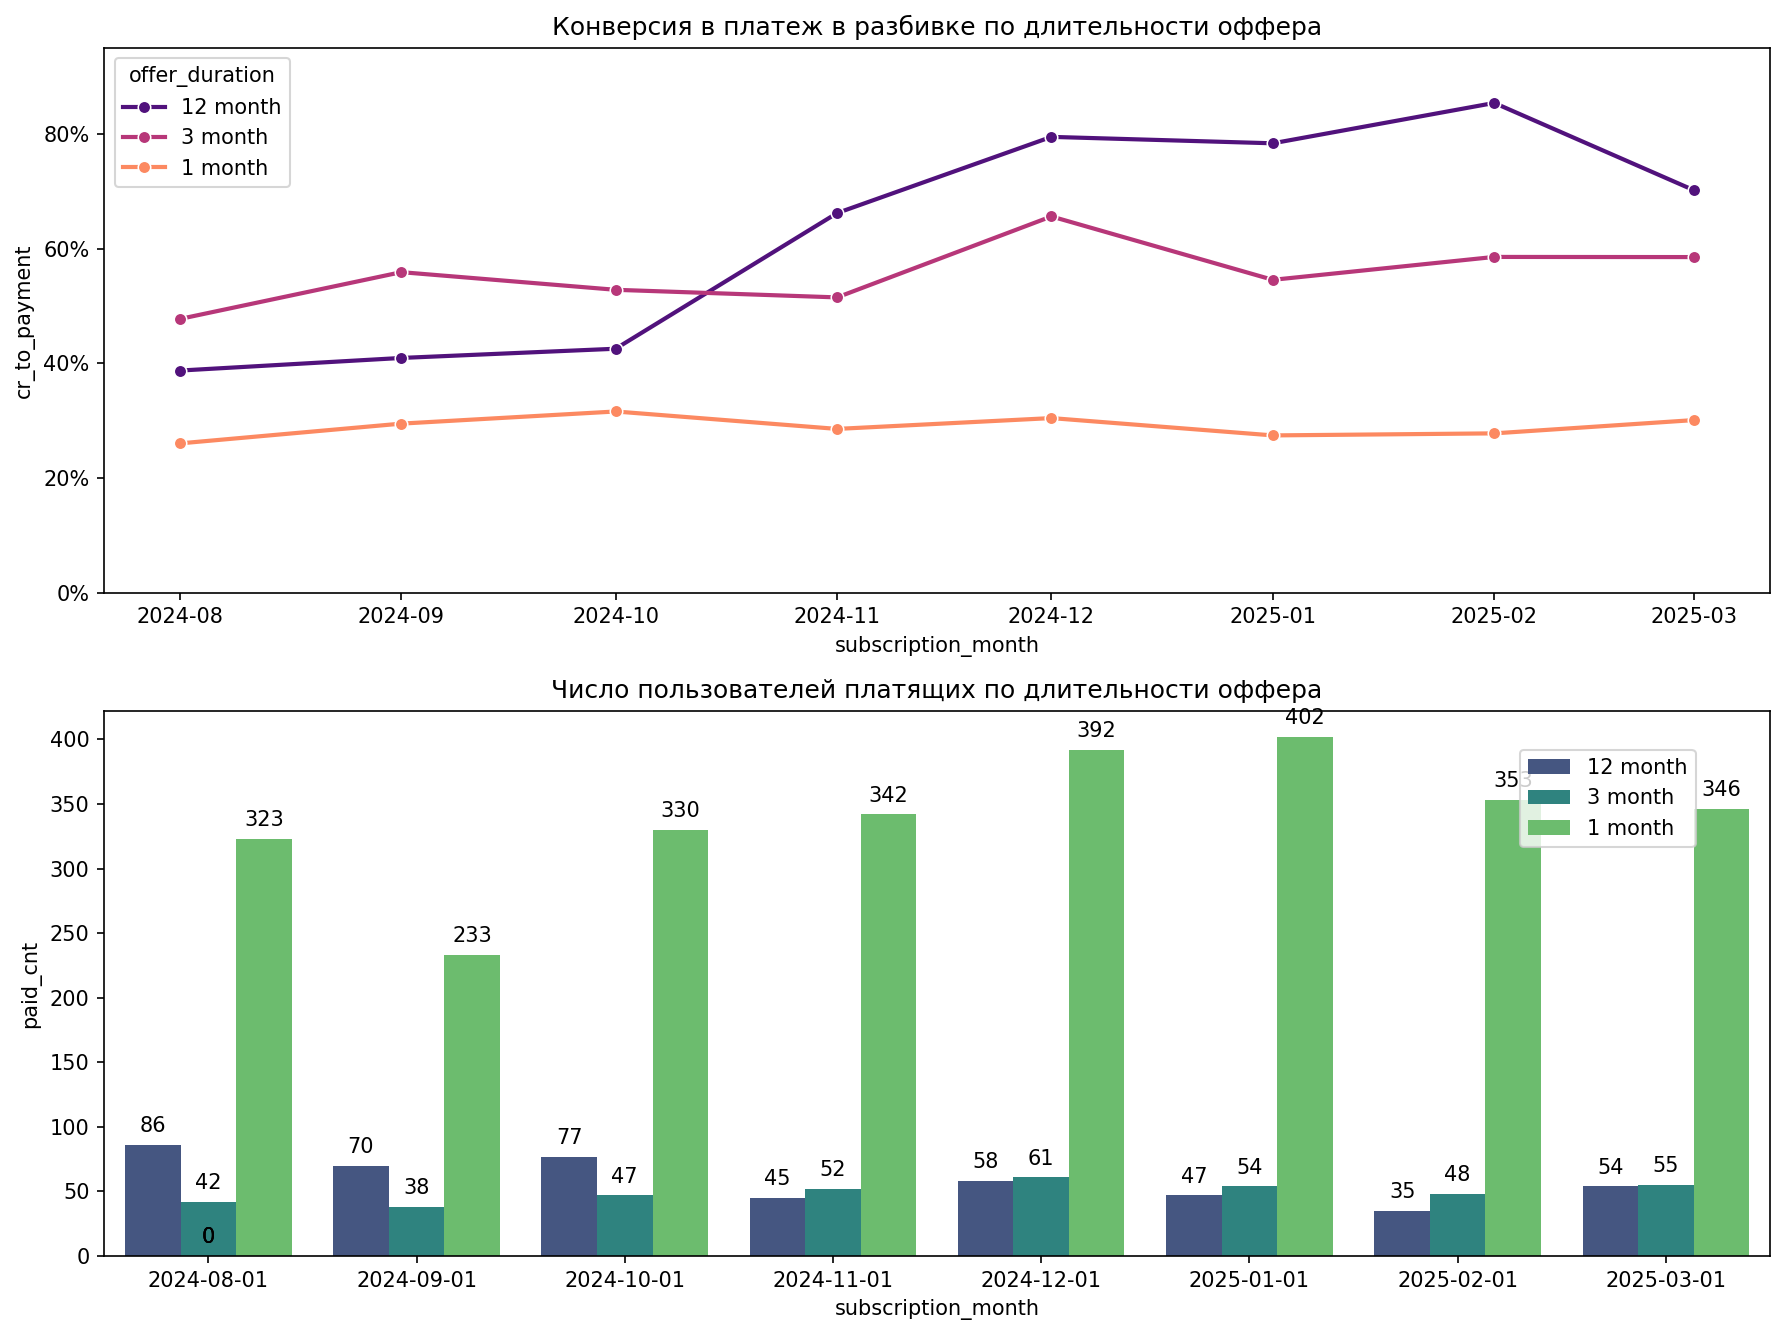

In [13]:
# Создаем figure и axes (два графика в одной строке)  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), dpi=150) 

sns.lineplot(data=df_organic_agg, x='subscription_month', y='cr_to_payment', marker='o', palette='magma',linestyle='-', linewidth=2, hue='offer_duration', ax=ax1)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax1.set_ylim(bottom=0,top=0.95)
ax1.set_title('Конверсия в платеж в разбивке по длительности оффера')

barplot = sns.barplot(data=df_organic_agg, x='subscription_month', y='paid_cnt', palette='viridis',hue='offer_duration', ax=ax2)
ax2.legend(loc=(0.85,0.75))
ax2.set_title('Число пользователей платящих по длительности оффера')

for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 


plt.tight_layout() 
plt.show() 

In [14]:
print('Медианное значение CR триала 14 дней за 6 месяцев:',round(df_organic_agg[df_organic_agg['offer_duration']=='1 month']['cr_to_payment'].median(),4))
print('Медианное значение CR триала 3 дня и 3 месяца за 6 месяцев:',round(df_organic_agg[df_organic_agg['offer_duration']=='3 month']['cr_to_payment'].median(),4))
print('Медианное значение CR триала 3 дня и 12 месяцев за 6 месяцев:',round(df_organic_agg[df_organic_agg['offer_duration']=='12 month']['cr_to_payment'].median(),4))

Медианное значение CR триала 14 дней за 6 месяцев: 0.2903
Медианное значение CR триала 3 дня и 3 месяца за 6 месяцев: 0.5521
Медианное значение CR триала 3 дня и 12 месяцев за 6 месяцев: 0.6815


In [15]:
print('Медианное значение CR триала 14 дней за 6 месяцев:',int(df_organic_agg[df_organic_agg['offer_duration']=='1 month']['paid_cnt'].median()))
print('Медианное значение CR триала 3 дней и оффер 3 месяца за 6 месяцев:',int(df_organic_agg[df_organic_agg['offer_duration']=='3 month']['paid_cnt'].median()))
print('Медианное значение CR триала 3 дней и оффер 12 месяцев за 6 месяцев:',int(df_organic_agg[df_organic_agg['offer_duration']=='12 month']['paid_cnt'].median()))

Медианное значение CR триала 14 дней за 6 месяцев: 344
Медианное значение CR триала 3 дней и оффер 3 месяца за 6 месяцев: 50
Медианное значение CR триала 3 дней и оффер 12 месяцев за 6 месяцев: 56


## Доля базовых подписок от всех подписок

In [17]:
df_organic_agg2 = df_organic_agg.groupby('subscription_month',as_index=False)['paid_cnt'].sum()

df_merge = pd.merge(df_agg,df_organic_agg2,on='subscription_month',how='left',suffixes=('_all','_organic'))
df_merge['cnt_paid_organic_frac'] = df_merge['paid_cnt_organic']/df_merge['paid_cnt_all']


Text(0.5, 1.0, 'Конверсия в платеж по месяцам')

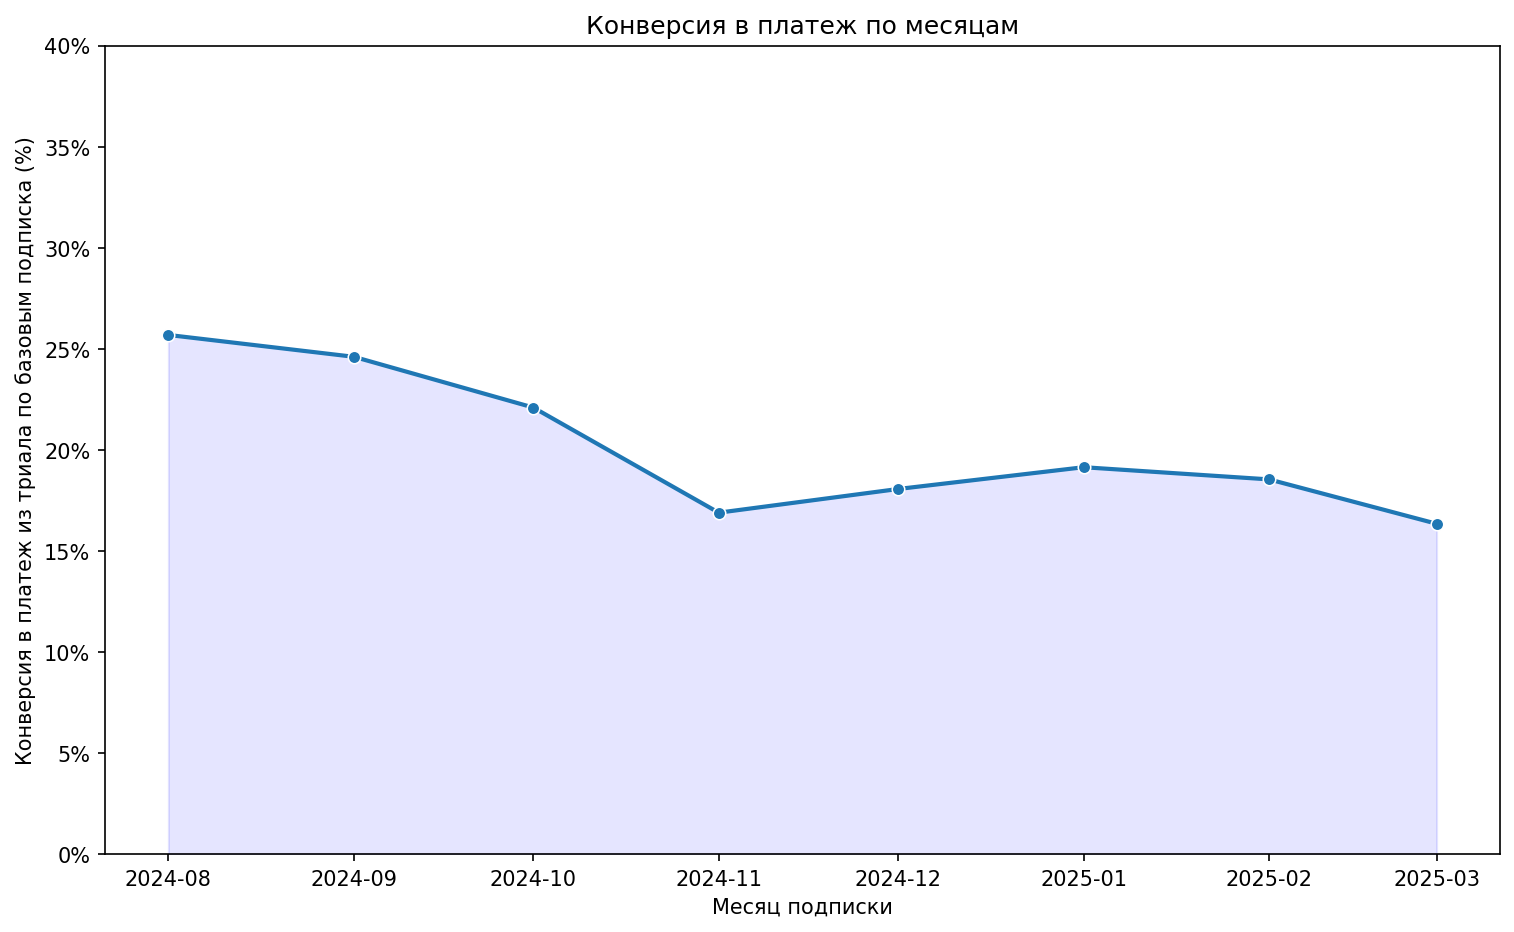

In [18]:
# Создаем figure и axes (два графика в одной строке)  
fig, ax1 = plt.subplots(1, 1, figsize=(12, 7), dpi=150) 

sns.lineplot(data=df_merge, x='subscription_month', y='cnt_paid_organic_frac', marker='o', palette='magma',linestyle='-', linewidth=2, ax=ax1)
ax1.fill_between(df_merge['subscription_month'], df_merge['cnt_paid_organic_frac'], color='blue', alpha=0.1)  
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax1.set_ylim(bottom=0, top=0.4)  
ax1.set_xlabel("Месяц подписки")  
ax1.set_ylabel("Конверсия в платеж из триала по базовым подписка (%)")  
ax1.set_title("Конверсия в платеж по месяцам")  

In [19]:
print('Медианное значение Доли базовых подписок от всех подписок за 6 месяцев:',round(df_merge['cnt_paid_organic_frac'].median(),4))

Медианное значение Доли базовых подписок от всех подписок за 6 месяцев: 0.1884


## Распределение по триал и платящих по триал периодам в рамках месяца

In [21]:
df_check = df.groupby(['subscription_month','free_days']).agg({'profile_id':'count','payment_type':'sum'}).reset_index()
df_check.rename(columns={'payment_type':'cnt_paid','profile_id':'cnt_trial'},inplace=True)
df_check['cnt_paid_all_by_day'] = df_check.groupby('subscription_month').transform('sum')['cnt_paid']
df_check['cnt_trial_all_by_day'] = df_check.groupby('subscription_month').transform('sum')['cnt_trial']


df_check['cnt_paid_frac'] = df_check['cnt_paid']/df_check['cnt_paid_all_by_day']
df_check['cnt_trial_frac'] = df_check['cnt_trial']/df_check['cnt_trial_all_by_day']
df_check = df_check[df_check['free_days'].isin([3,14,30,35,45])]

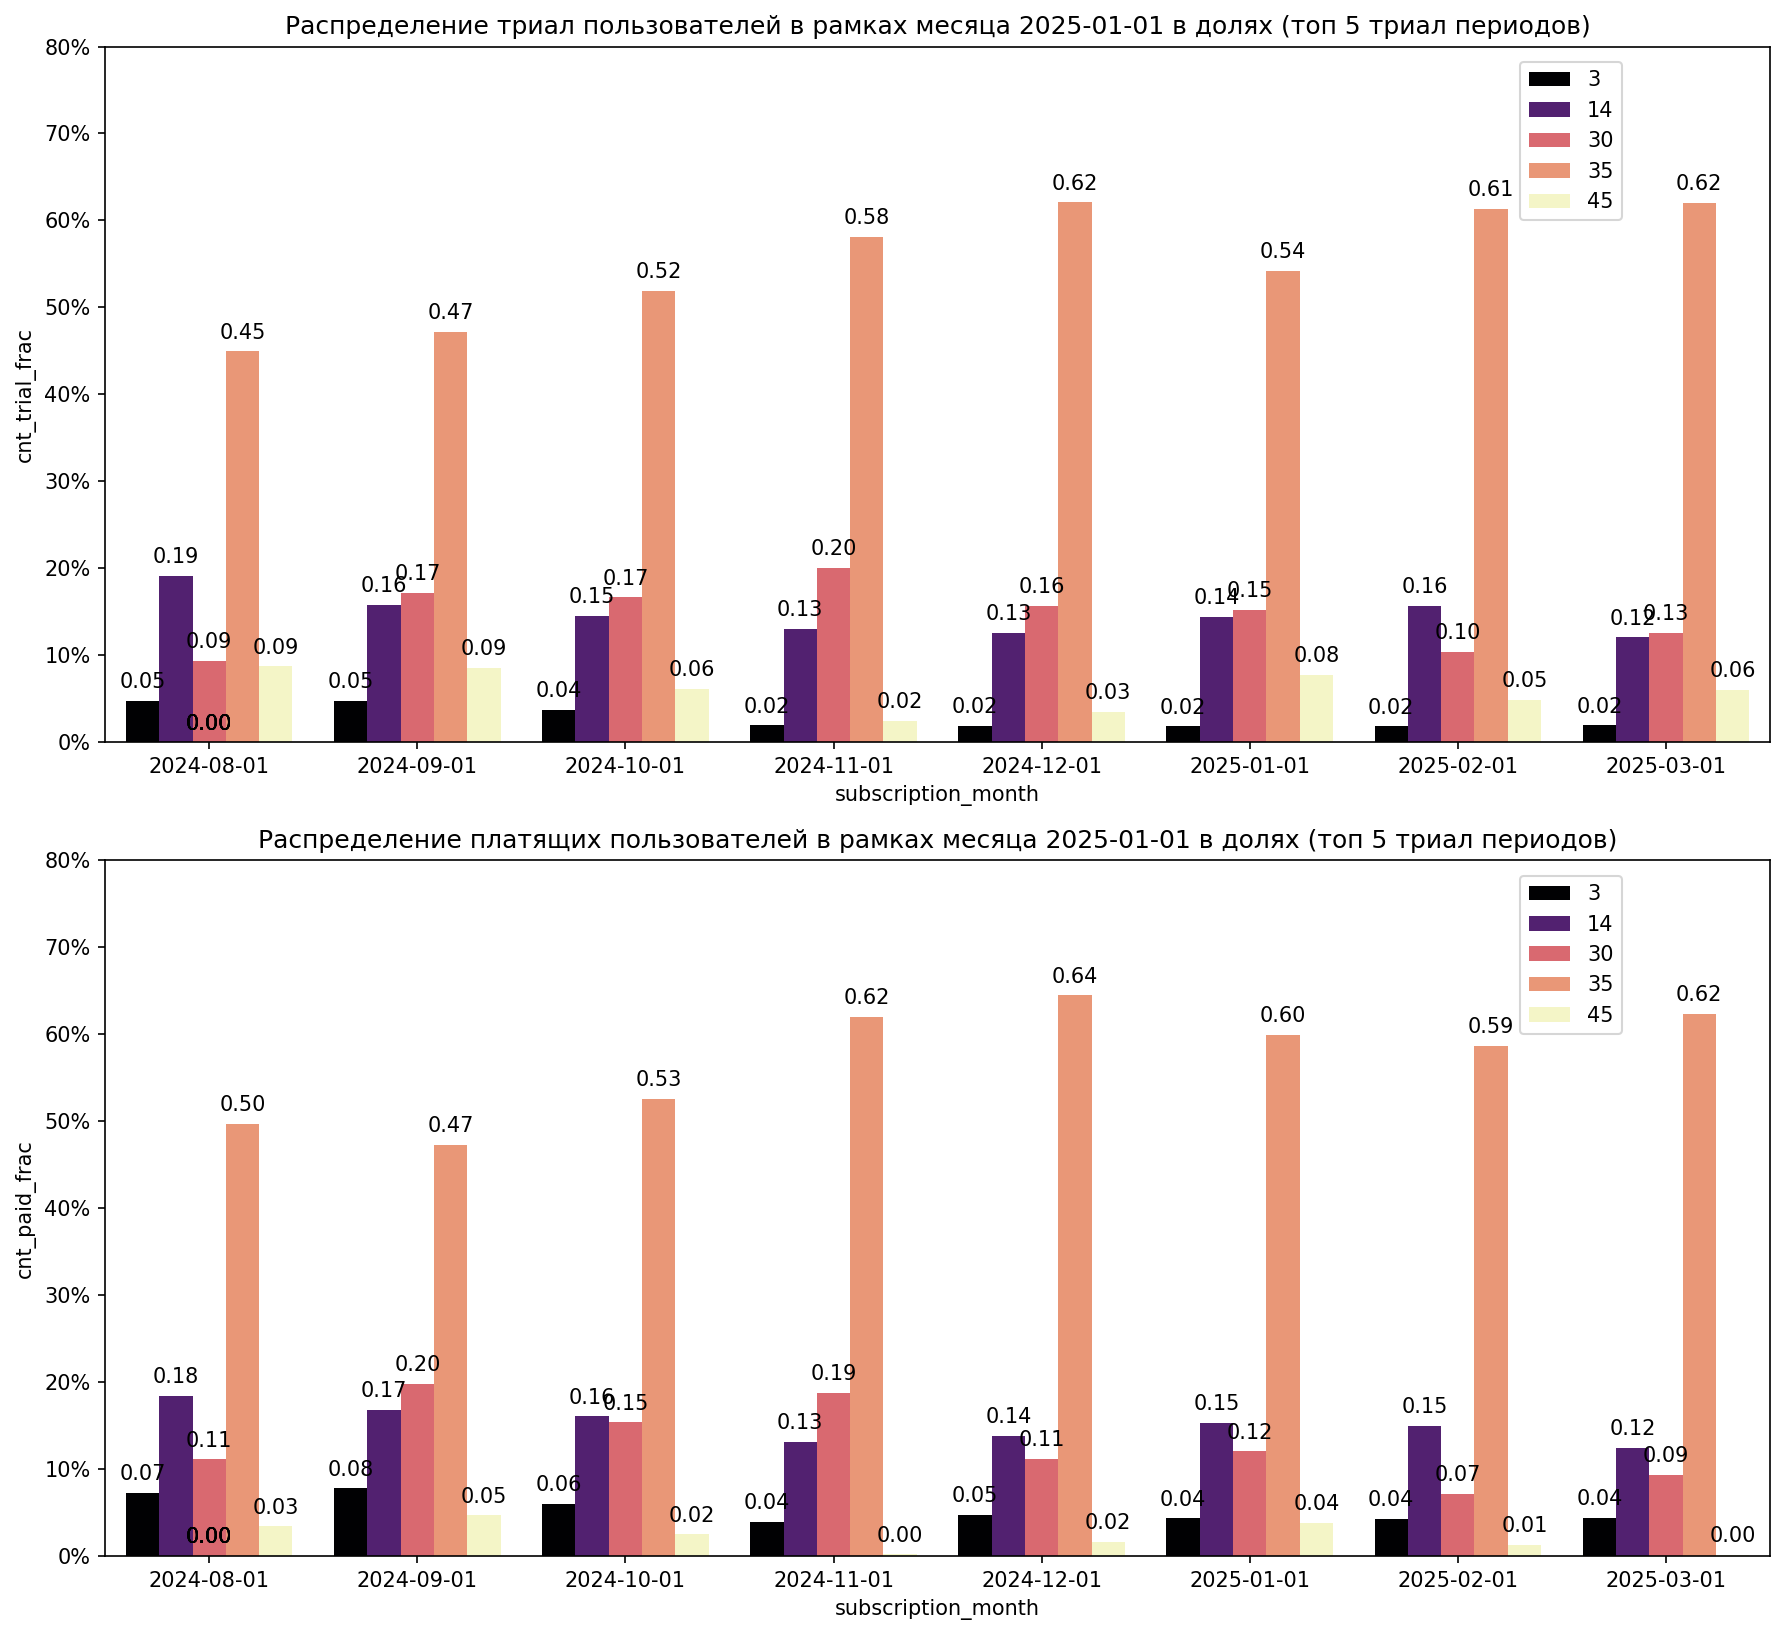

In [22]:
# Создаем figure и axes (два графика в одной строке)  
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 11), dpi=150) 

barplot = sns.barplot(data=df_check, x='subscription_month', y='cnt_trial_frac', hue='free_days', palette='magma', ax=ax1)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax1.set_ylim(bottom=0,top=0.8)
ax1.set_title('Распределение триал пользователей в рамках месяца 2025-01-01 в долях (топ 5 триал периодов)')
ax1.legend(title='',loc=(0.85,0.75))

for p in barplot.patches:  
    ax1.annotate(format(p.get_height(), '.2f'),  # Исправлено: формат '.2f'  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center', va = 'center',  
                xytext = (0, 9),  
                textcoords = 'offset points') 

barplot2 = sns.barplot(data=df_check, x='subscription_month', y='cnt_paid_frac', hue='free_days', palette='magma', ax=ax2)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax2.set_ylim(bottom=0,top=0.8)
ax2.set_title('Распределение платящих пользователей в рамках месяца 2025-01-01 в долях (топ 5 триал периодов)')
ax2.legend(title='',loc=(0.85,0.75))

for p in barplot2.patches:  
    ax2.annotate(format(p.get_height(), '.2f'),  # Исправлено: формат '.2f'  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center', va = 'center',  
                xytext = (0, 9),  
                textcoords = 'offset points') 

plt.tight_layout() 
plt.show() 

In [23]:
# Медианное значение триал пользователей и платящих в разбивке по триал периодам
df_check.groupby('free_days').median().reset_index()

free_days subscription_month  cnt_trial  cnt_paid  cnt_paid_all_by_day  \
0          3         2024-11-16      189.5     118.0               2475.5   
1         14         2024-11-16     1218.5     344.0               2475.5   
2         30         2024-11-16     1199.5     295.0               2475.5   
3         35         2024-11-16     5155.0    1476.5               2475.5   
4         45         2024-11-16      433.0      49.0               2475.5   

   cnt_trial_all_by_day  cnt_paid_frac  cnt_trial_frac  
0                8647.5       0.045594        0.019540  
1                8647.5       0.151527        0.144977  
2                8647.5       0.115795        0.154649  
3                8647.5       0.592622        0.561621  
4                8647.5       0.020716        0.060719

In [24]:
df_check_organic = df_organic.groupby(['subscription_month','free_days','offer_duration']).agg({'profile_id':'count','payment_type':'sum'}).reset_index()
df_check_organic.rename(columns={'payment_type':'cnt_paid','profile_id':'cnt_trial'},inplace=True)

df_check_organic_frac = pd.merge(df_check_organic,df_check.groupby('subscription_month')[['cnt_trial_all_by_day','cnt_paid_all_by_day']].mean().reset_index(),on='subscription_month',how='left')

df_check_organic_frac['trial_frac'] = df_check_organic_frac['cnt_trial'] / df_check_organic_frac['cnt_trial_all_by_day']
df_check_organic_frac['paid_frac'] = df_check_organic_frac['cnt_paid'] / df_check_organic_frac['cnt_paid_all_by_day']

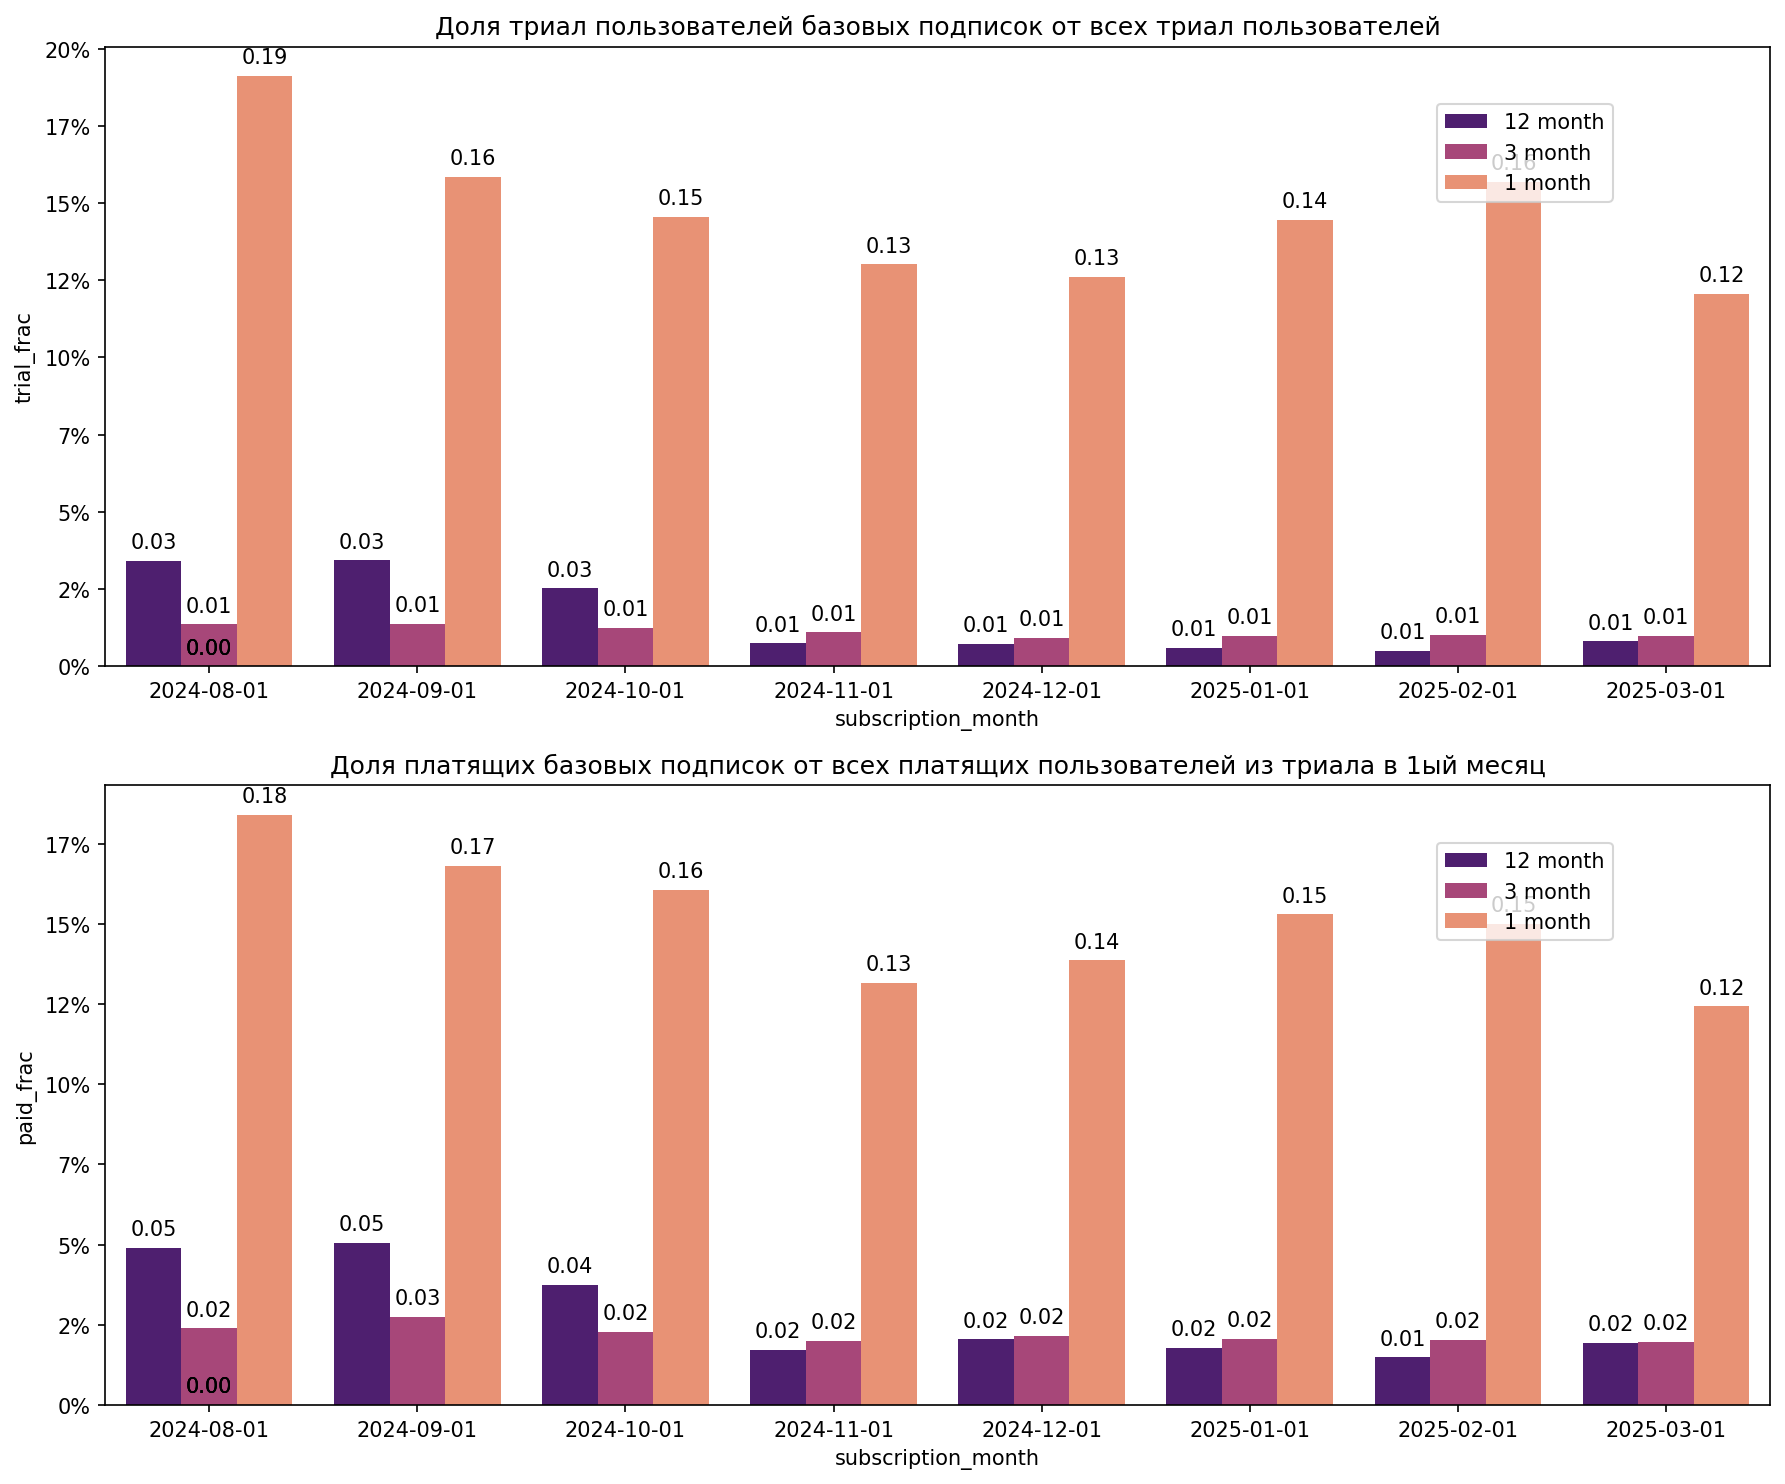

In [25]:
# Создаем figure и axes (два графика в одной строке)  
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=150) 

barplot = sns.barplot(data=df_check_organic_frac, x='subscription_month', y='trial_frac', hue='offer_duration', palette='magma', ax=ax1)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax1.set_title('Доля триал пользователей базовых подписок от всех триал пользователей')
ax1.legend(title='',loc=(0.8,0.75))

for p in barplot.patches:  
    ax1.annotate(format(p.get_height(), '.2f'),  # Исправлено: формат '.2f'  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center', va = 'center',  
                xytext = (0, 9),  
                textcoords = 'offset points') 

barplot2 = sns.barplot(data=df_check_organic_frac, x='subscription_month', y='paid_frac', hue='offer_duration', palette='magma', ax=ax2)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  
ax2.set_title('Доля платящих базовых подписок от всех платящих пользователей из триала в 1ый месяц')
ax2.legend(title='',loc=(0.8,0.75))

for p in barplot2.patches:  
    ax2.annotate(format(p.get_height(), '.2f'),  # Исправлено: формат '.2f'  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center', va = 'center',  
                xytext = (0, 9),  
                textcoords = 'offset points') 

plt.tight_layout() 
plt.show() 

## Повторная подписка на 2-ой месяц

In [27]:
query = '''WITH payment AS (SELECT
                paid_date,
                subscription_id,
                user_id,
                platform,
                free_days,
                ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY paid_date) AS row_num
                FROM datamarts.finance f 
                WHERE paid_date BETWEEN '2024-08-01' AND '2025-04-28'
                AND platform IN ('cloudpayments','payture')
                ),


other_info AS (SELECT * FROM datamarts.marketing_dash
                WHERE domain_locale='ru'
                AND first_prolong_date>='2024-07-01'
                AND platform IN ('cloudpayments','payture')
            )


SELECT t1.*,offer_duration,created_at::date AS subscription_date, first_prolong_date
FROM payment AS t1
INNER JOIN other_info AS t2  ON t1.user_id=t2.user_id 
WHERE row_num<=2 AND first_prolong_date<='2025-03-10'
'''

df_repayment = execute(query,user='kmekhtiev')

df_repayment['paid_date'] = pd.to_datetime(df_repayment['paid_date'])
df_repayment['first_prolong_date'] = pd.to_datetime(df_repayment['first_prolong_date'])

Время выполнения функции: 1.0543 секунд



In [28]:
df_repayment['paid_month'] = df_repayment['paid_date'].dt.to_period('M')
df_repayment['paid_month'] = df_repayment['paid_month'].dt.to_timestamp()
df_repayment_14_trial = df_repayment[(df_repayment['free_days']=='14') & (df_repayment['offer_duration']=='1 month')]

df_repayment_second_payment = df_repayment[df_repayment['row_num']==2].groupby('paid_month')['user_id'].nunique().reset_index()
df_repayment_first_payment = df_repayment[df_repayment['row_num']==1].groupby('paid_month')['user_id'].nunique().reset_index()

## Конверсия в продление по всем офферам и трилам

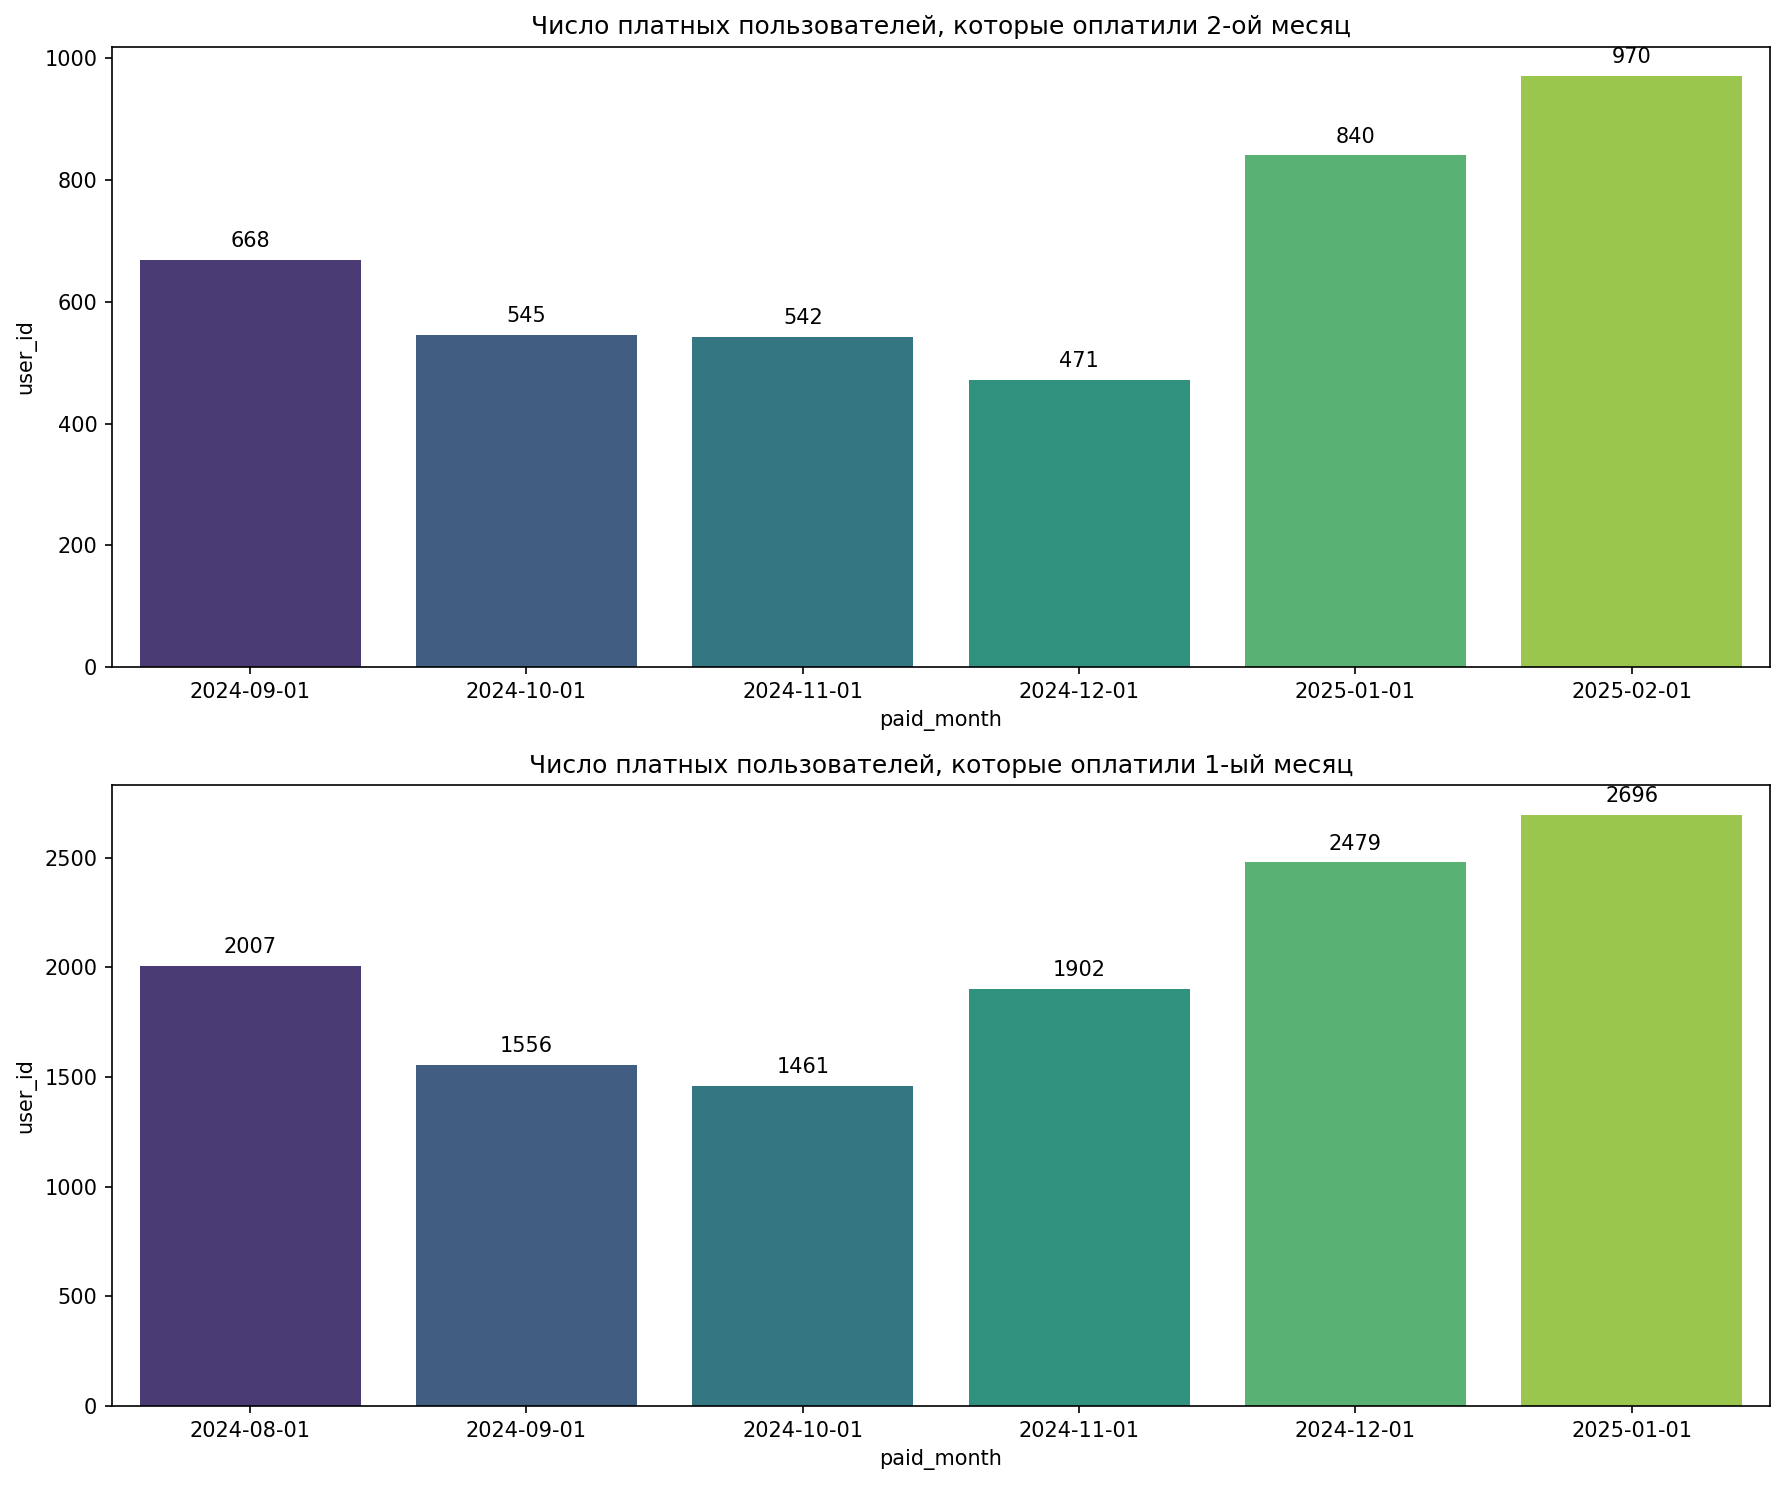

In [30]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=150) 

df_repayment_second_payment = df_repayment_second_payment[(df_repayment_second_payment['paid_month']>='2024-09-01') & (df_repayment_second_payment['paid_month']<'2025-03-01')]
barplot = sns.barplot(data=df_repayment_second_payment, x='paid_month', y='user_id', palette='viridis', ax=ax1)
ax1.set_title('Число платных пользователей, которые оплатили 2-ой месяц')
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 

df_repayment_first_payment = df_repayment_first_payment[(df_repayment_first_payment['paid_month']<'2025-02-01')]
barplot2 = sns.barplot(data=df_repayment_first_payment, x='paid_month', y='user_id', palette='viridis', ax=ax2)
ax2.set_title('Число платных пользователей, которые оплатили 1-ый месяц')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 


plt.tight_layout() 
plt.show()

In [31]:
print('Средняя конверсия во 2-ой месяц подписки за 6 месяцев:',\
      df_repayment[df_repayment['row_num']==2]['user_id'].nunique() / \
      df_repayment[df_repayment['row_num']==1]['user_id'].nunique())  

print('Медианное число пользователей, кто оплатил 2-ой месяц подписки за 6 месяцев:',\
     int(df_repayment_second_payment['user_id'].median()))

Средняя конверсия во 2-ой месяц подписки за 6 месяцев: 0.39939319604931894
Медианное число пользователей, кто оплатил 2-ой месяц подписки за 6 месяцев: 606


## Конверсия в продление по коротким офферам и трилам 14 дней

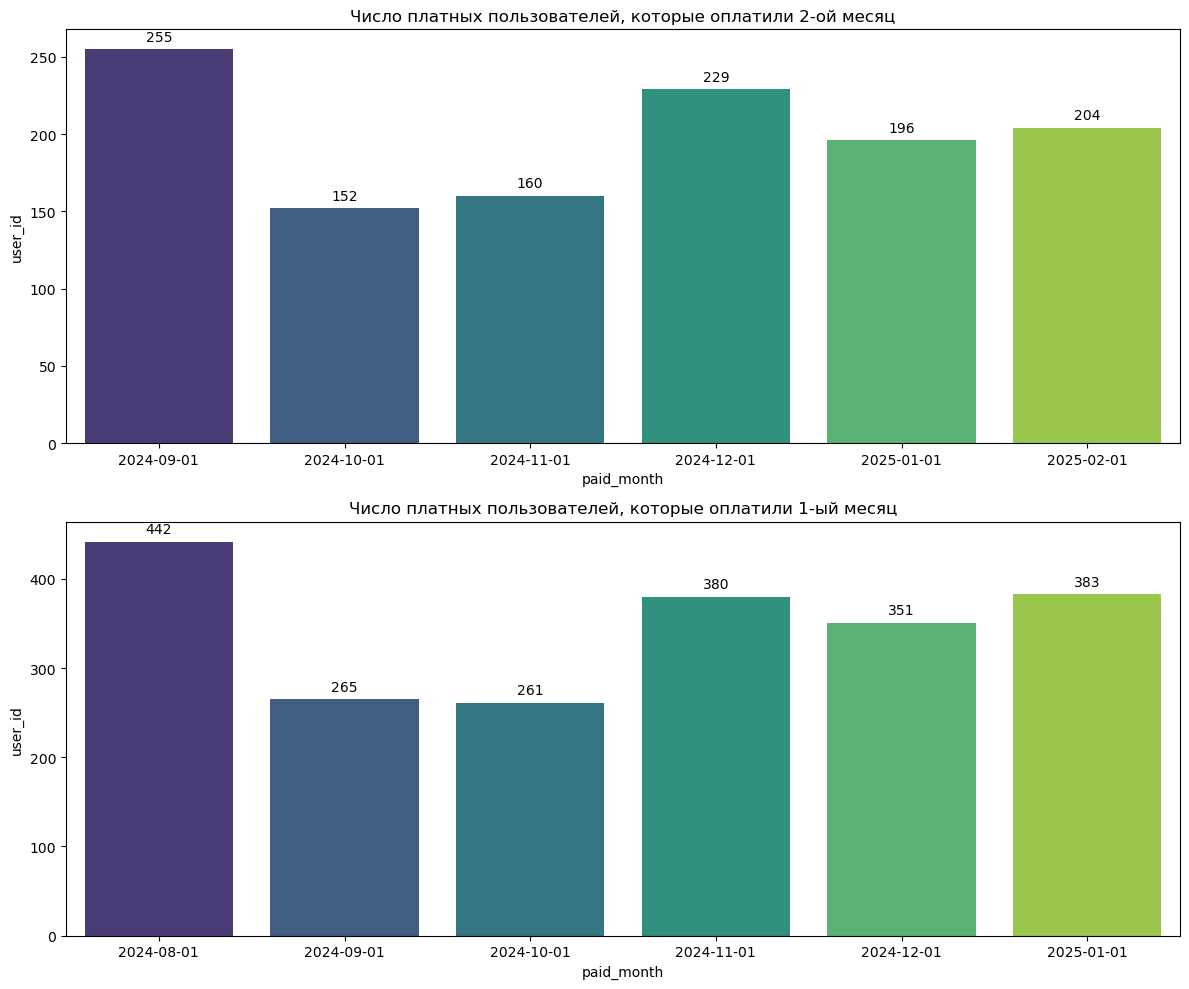

In [33]:
df_repayment_14_trial = df_repayment[(df_repayment['free_days']=='14') & (df_repayment['offer_duration']=='1 month')]

df_repayment_second_payment_14_trial = df_repayment_14_trial[df_repayment_14_trial['row_num']==2].groupby('paid_month')['user_id'].nunique().reset_index()
df_repayment_first_payment_14_trial = df_repayment_14_trial[df_repayment_14_trial['row_num']==1].groupby('paid_month')['user_id'].nunique().reset_index()

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=100) 

df_repayment_second_payment_14_trial = df_repayment_second_payment_14_trial[(df_repayment_second_payment_14_trial['paid_month']>='2024-09-01') & (df_repayment_second_payment_14_trial['paid_month']<'2025-03-01')]
barplot = sns.barplot(data=df_repayment_second_payment_14_trial, x='paid_month', y='user_id', palette='viridis', ax=ax1)
ax1.set_title('Число платных пользователей, которые оплатили 2-ой месяц')
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 

df_repayment_first_payment_14_trial = df_repayment_first_payment_14_trial[(df_repayment_first_payment_14_trial['paid_month']<'2025-02-01')]
barplot2 = sns.barplot(data=df_repayment_first_payment_14_trial, x='paid_month', y='user_id', palette='viridis', ax=ax2)
ax2.set_title('Число платных пользователей, которые оплатили 1-ый месяц')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 


plt.tight_layout() 
plt.show()

In [34]:
print('Средняя конверсия во 2-ой месяц подписки за 6 месяцев триал 14 дней:',\
      df_repayment_14_trial[df_repayment_14_trial['row_num']==2]['user_id'].nunique() / \
      df_repayment_14_trial[df_repayment_14_trial['row_num']==1]['user_id'].nunique())  

print('Медианное число пользователей во 2-ой месяц подписки за 6 месяцев триал 14 дней:',\
      int(df_repayment_second_payment_14_trial['user_id'].median()))


Средняя конверсия во 2-ой месяц подписки за 6 месяцев триал 14 дней: 0.5774980330448466
Медианное число пользователей во 2-ой месяц подписки за 6 месяцев триал 14 дней: 200


In [35]:
print('Доля пользователей триала 14 дней, которые продлили на 2-ой период от всех, кто продлил на 2-ой период:',\
      df_repayment_second_payment_14_trial['user_id'].sum() / df_repayment_second_payment['user_id'].sum())

Доля пользователей триала 14 дней, которые продлили на 2-ой период от всех, кто продлил на 2-ой период: 0.29633300297324083


## LTV

In [37]:
list_date = pd.date_range("2024-08-01", "2025-04-01", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
    WITH payment AS (SELECT
                '{date_str}' AS trial_month,
                paid_date,
                subscription_id,
                user_id,
                platform,
                free_days,
                payment,
                ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY paid_date) AS row_num
                FROM datamarts.finance f 
                WHERE platform IN ('cloudpayments','payture')
                AND paid_date BETWEEN '{date_str}' AND '2025-04-30'
                ),


    first_payment AS (SELECT * FROM datamarts.marketing_dash
                  WHERE domain_locale='ru'
                  AND DATE_TRUNC('month', first_prolong_date)='{date_str}'
                  AND platform IN ('cloudpayments','payture')
            )

    SELECT 
    t1.*,
    offer_duration,
    created_at::date AS subscription_date, 
    first_prolong_date
    FROM payment AS t1
    INNER JOIN first_payment AS t2  ON t1.user_id=t2.user_id 

            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_ltv = pd.concat(result)
df_ltv['paid_date'] = df_ltv['paid_date'].astype('datetime64[ns]')
df_ltv['trial_month'] = df_ltv['trial_month'].astype('datetime64[ns]')
df_ltv['payment'] = df_ltv['payment'].astype('int32')

Время выполнения функции: 0.639 секунд

Дата '2024-08-01' загружена

Время выполнения функции: 0.5837 секунд

Дата '2024-09-01' загружена

Время выполнения функции: 0.5906 секунд

Дата '2024-10-01' загружена

Время выполнения функции: 0.6606 секунд

Дата '2024-11-01' загружена

Время выполнения функции: 0.678 секунд

Дата '2024-12-01' загружена

Время выполнения функции: 0.6351 секунд

Дата '2025-01-01' загружена

Время выполнения функции: 0.6821 секунд

Дата '2025-02-01' загружена

Время выполнения функции: 0.6905 секунд

Дата '2025-03-01' загружена

Время выполнения функции: 0.6159 секунд

Дата '2025-04-01' загружена



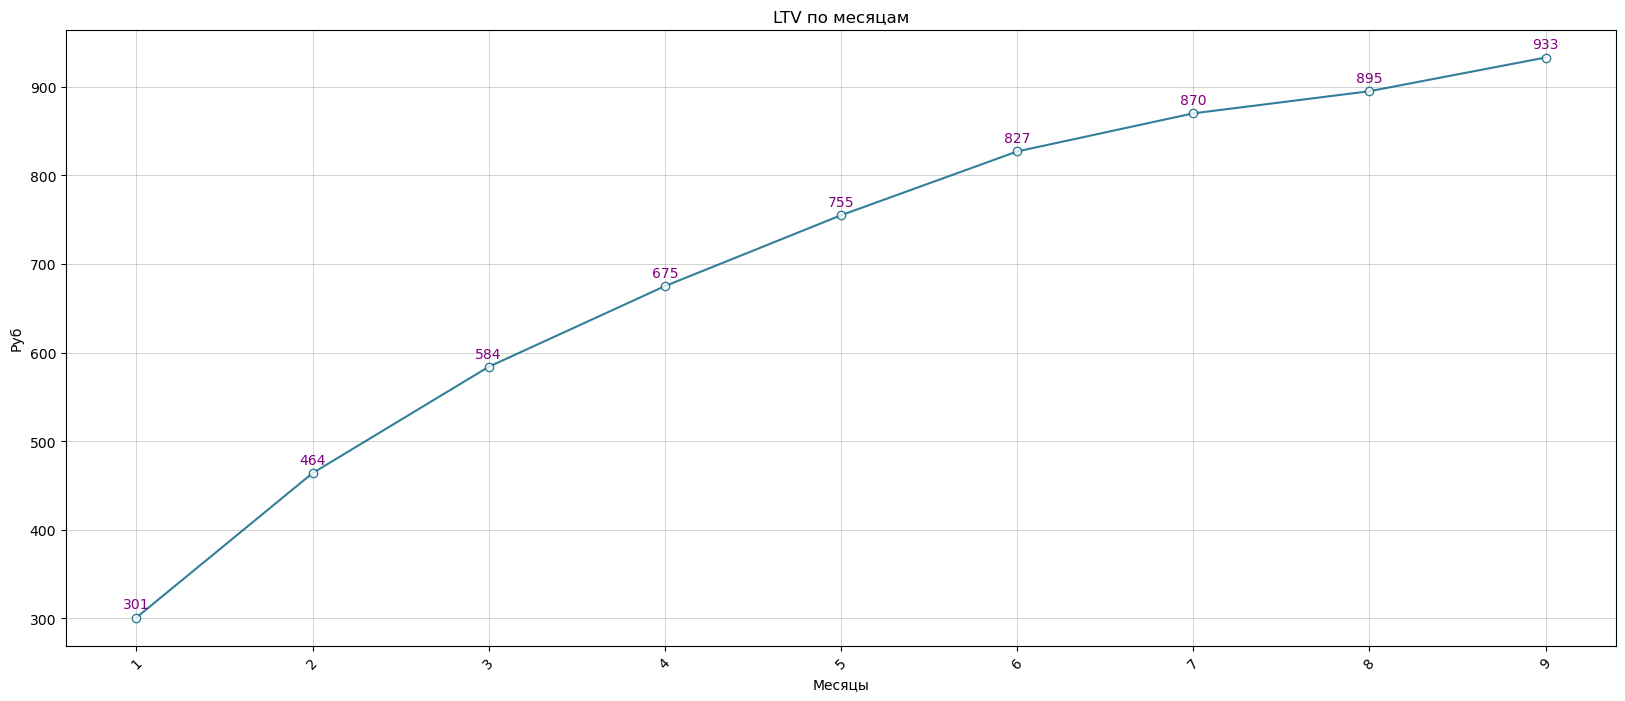

In [38]:
df_ltv['paid_month'] = df_ltv['paid_date'].dt.to_period('M')
df_ltv = df_ltv[(df_ltv['free_days']=='14') & (df_ltv['offer_duration']=='1 month')]
df_agg = df_ltv.groupby(['trial_month','paid_month']).agg({'payment':'sum','user_id':'count'}).reset_index()

# Расчет кумулятивной суммы, и добавления поля по числу пользователей когорты 
df_agg['cumulative'] = df_agg.groupby('trial_month')['payment'].cumsum()
df_agg['uniq_user'] = df_agg.groupby('trial_month')['user_id'].transform('max')

df_agg['ltv'] = df_agg.cumulative/df_agg.uniq_user

# Нумерация месяцев
df_agg['num_of_month'] = df_agg.groupby('trial_month')['paid_month'].rank(method='first').astype('int')
df_agg = df_agg[df_agg['num_of_month']<10] # Ограничиваем 6-ью месяцами


# Сделаем pivot 
df_pivot = pd.pivot(data = df_agg,index = 'trial_month',columns = 'num_of_month',values = 'ltv')
df_pivot['uniq_user'] = df_agg.groupby('trial_month')['uniq_user'].max()


# Создаем DataFrame с данными для расчета средневзвешенного LTV
weighted_ltv = df_agg.pivot(index='trial_month', columns='num_of_month', values='ltv')
user_counts = df_agg.pivot(index='trial_month', columns='num_of_month', values='uniq_user')


# Рассчитываем средневзвешенное значение LTV для каждого 'num_of_month'
weighted_avg_ltv = ((weighted_ltv * user_counts).sum() / user_counts.sum()).round().astype('int')


weighted_avg_ltv = weighted_avg_ltv.reset_index()
weighted_avg_ltv = weighted_avg_ltv.rename(columns={0:'cumsum'})

# Построение графика месячного LTV
plt.figure(figsize=(20,8))
plt.plot(weighted_avg_ltv['num_of_month'], weighted_avg_ltv['cumsum'], marker='o', linestyle='-', color='#005f80',markerfacecolor='white',alpha=0.8)

for i in range(len(weighted_avg_ltv['num_of_month'])):  
    plt.text(weighted_avg_ltv['num_of_month'][i], weighted_avg_ltv['cumsum'][i]+10,
             str(weighted_avg_ltv['cumsum'][i]),
             ha='center', fontsize=10,color='purple')  
plt.xlabel('Месяцы')
plt.ylabel('Руб')
plt.title('LTV по месяцам')
plt.grid(True,linewidth=0.4)
plt.xticks(rotation=45)
plt.show()

# Неуспешные списания

## Уникальное число пользователей из триала в подписку

In [41]:
query = '''WITH all_info AS (SELECT  
        s.user_id AS user_id,
        s.created_at as subscription_created_at,
        s.id AS id,
        leadInFrame(id) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_id,
        i.state as invoice_state,
        leadInFrame(invoice_state) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_state,
        i.id as invoice_id,
        i.created_at as invoice_created_at,
        leadInFrame(invoice_created_at) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_created_at,  
        next_invoice_created_at::date - invoice_created_at::date delta_date,
        i.price_cents AS price_cents,
        i.price_currency AS price_currency,
        i.refund_amount_cents AS refund_amount_cents,
        ROW_NUMBER() OVER (PARTITION BY user_id,id,id,user_type,invoice_state ORDER BY invoice_created_at) AS rn_num,
        CASE WHEN price_cents<=100 AND invoice_state='success' THEN 'trial'
             WHEN price_cents<=100 AND invoice_state IN ('failure','initial') THEN 'not_success_trial'
             ELSE 'subs'
             END user_type,
        leadInFrame(user_type) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_user_type, 
        t2.renewal_off_date AS renewal_off_date,
        CASE WHEN renewal_off_date!='1970-01-01' THEN 1 ELSE 0 END unsubscribe_type,
        t3.free_days AS free_days,
        t3.offer_duration AS offer_duration,
        t3.promo_type,
        i.paid_at AS paid_at,
        --i.period_end,
        s.platform AS platform,
       -- i.payment_target,
        i.deleted_at,
        i.refunded_at
    FROM raw.viju__product_x__public__invoices i
    LEFT JOIN raw.viju__product_x__public__subscriptions s 
        ON i.subscription_id = s.id  
    LEFT JOIN (SELECT
                subscription_id,
                max(created_at) as renewal_off_date
                FROM raw.viju__product_x__public__subscription_cancel_reasons
                WHERE created_at >= '2022-03-01'
                 --AND subscription_id='74bcff94-4ada-40ef-85de-25074d615d57'
                GROUP by 1
                ) AS t2 ON i.subscription_id=t2.subscription_id
    INNER JOIN datamarts.marketing_dash AS t3 ON s.user_id=t3.user_id
    WHERE s.platform != 'api'
    ORDER BY s.user_id, invoice_created_at 
    )
--    
SELECT * FROM all_info
WHERE invoice_created_at::date BETWEEN '2024-08-01' AND '2025-04-30'
--AND user_type!='not_success_trial'
AND platform!='payture'
'''

df_failure = execute(query,user='kmekhtiev')

Время выполнения функции: 14.3436 секунд



In [42]:
df_failure['invoice_created_at'] =  df_failure['invoice_created_at'].dt.strftime("%Y-%m-%d")
df_failure['invoice_created_at'] =  pd.to_datetime(df_failure['invoice_created_at'])
df_failure['invoice_created_month'] = df_failure['invoice_created_at'].dt.to_period('M')

In [43]:
df_failure[df_failure['user_type']=='trial'].groupby(['invoice_created_month','invoice_state'],as_index=False)['user_id'].nunique()

invoice_created_month invoice_state  user_id
0               2024-08       success     5324
1               2024-09       success     4452
2               2024-10       success     6304
3               2024-11       success     8172
4               2024-12       success     9382
5               2025-01       success     9202
6               2025-02       success     7421
7               2025-03       success     9166
8               2025-04       success     9167

In [44]:
df_failure[df_failure['user_type']=='not_success_trial'].groupby('price_cents')['user_id'].count()

price_cents
0    83987
Name: user_id, dtype: int64

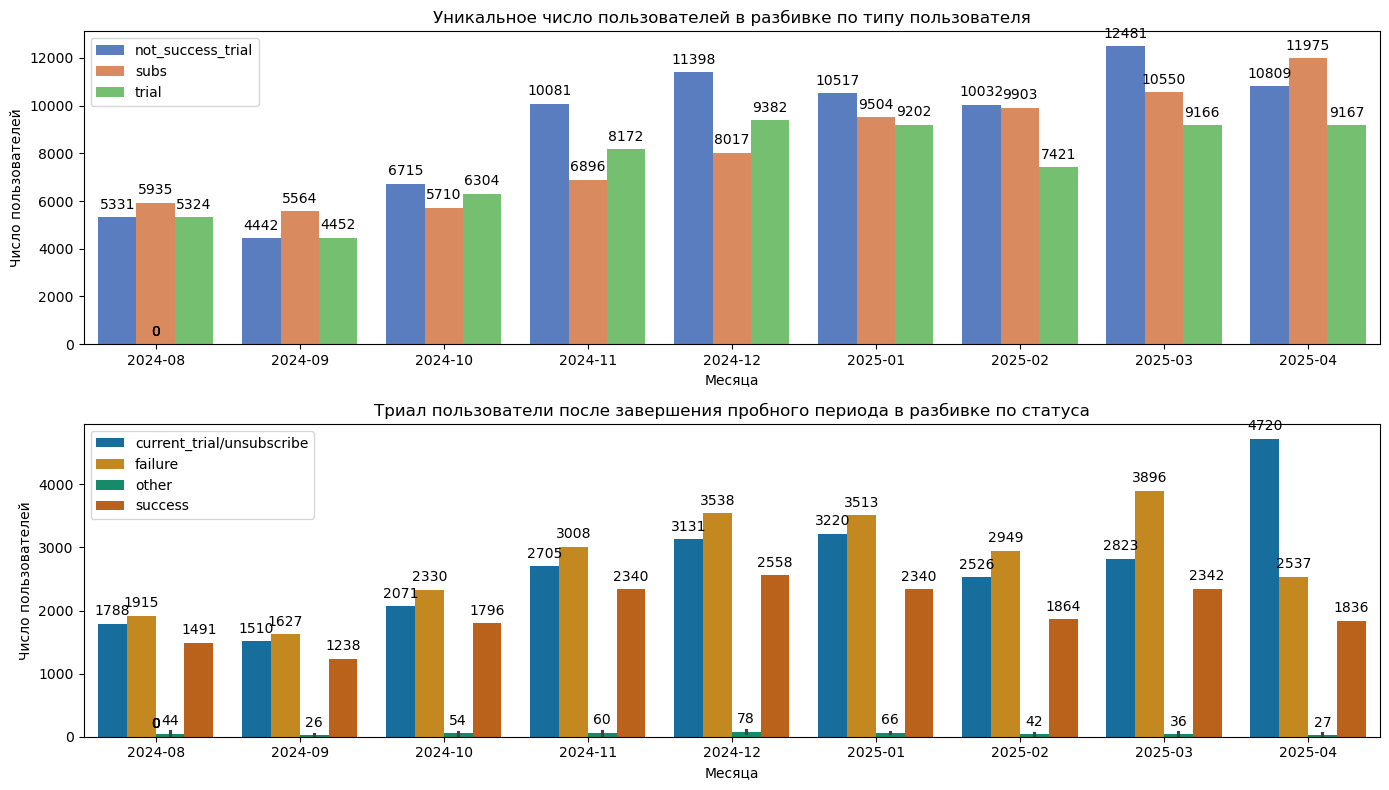

In [45]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),dpi=100)

t = df_failure.groupby(['invoice_created_month','user_type'],as_index=False)['user_id'].nunique()
barplot = sns.barplot(data = t,x='invoice_created_month',y='user_id',hue='user_type',palette = 'muted',ax=ax1)
ax1.set_ylabel('Число пользователей')
ax1.set_xlabel('Месяца')
ax1.set_title('Уникальное число пользователей в разбивке по типу пользователя')
ax1.legend(title='')
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 


r = df_failure[df_failure['user_type']=='trial'].groupby(['invoice_created_month','next_invoice_state'],as_index=False)['user_id'].nunique()
r['next_invoice_state'] = r['next_invoice_state'].apply(lambda x: 'current_trial/unsubscribe' if x == ''  else 
                                                               'other' if x in ['initial','refunded','processing']
                                                               else x)
                                                            
barplot2 = sns.barplot(data = r,x='invoice_created_month',y='user_id',hue='next_invoice_state',palette = 'colorblind',ax=ax2)
ax2.set_ylabel('Число пользователей')
ax2.set_xlabel('Месяца')
ax2.legend(title='')
ax2.set_title('Триал пользователи после завершения пробного периода в разбивке по статуса')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 

plt.tight_layout() 
plt.show()

In [46]:
r2 = r[r['invoice_created_month']<'2025-02-01'].groupby('next_invoice_state')['user_id'].median().reset_index()
r2['user_id'] = r2['user_id'].astype(int)  
   
# Медианное число триал пользователей в разбивке по статусам инвойсов    
r2

next_invoice_state  user_id
0  current_trial/unsubscribe     2388
1                    failure     2669
2                      other       49
3                    success     2068

## Уникальное число пользователей из триала в подписку. Базовая подписка!!

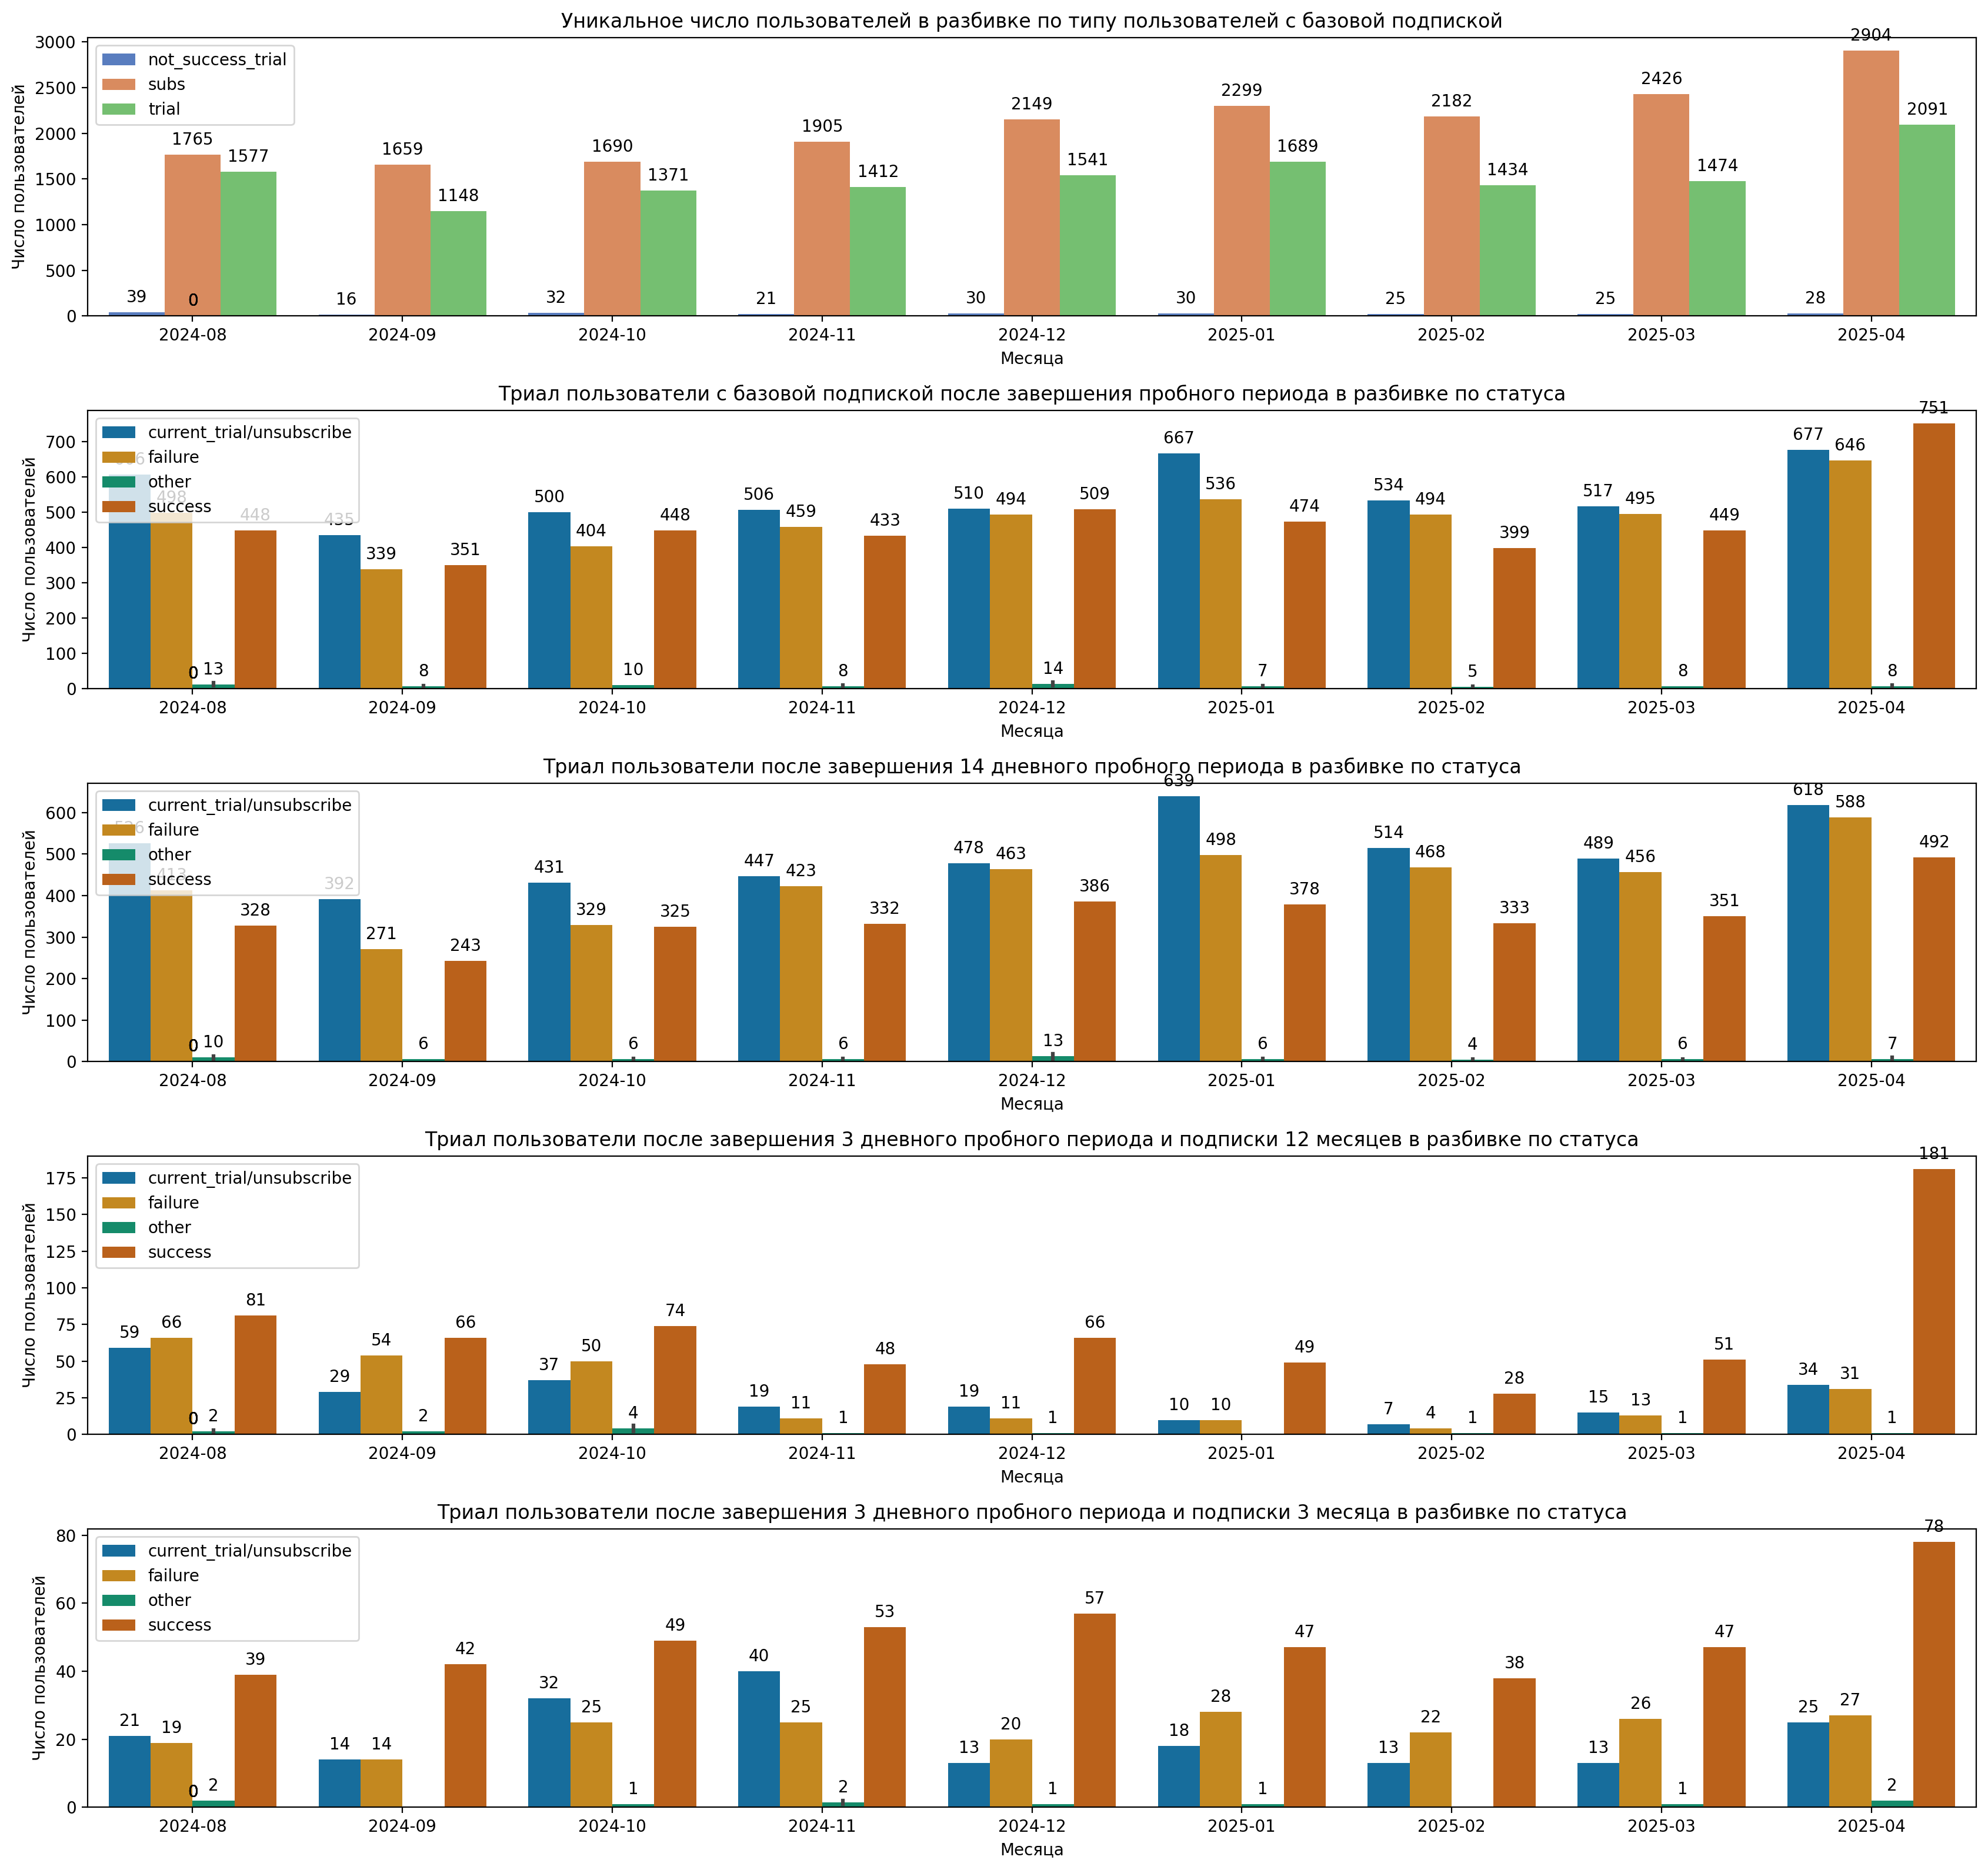

In [48]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(17,16),dpi=200)

df_failure_organic = df_failure[(df_failure['offer_duration'].isin(['1 month','3 month','12 month'])) & (df_failure['free_days'].isin([3,14]))]
df_failure_organic = df_failure_organic[~((df_failure_organic['offer_duration'] == '1 month') & (df_failure_organic['free_days'] == 3))] 
df_failure_organic = df_failure_organic[~((df_failure_organic['offer_duration'] == '3 month') & (df_failure_organic['free_days'] == 14))] 
df_failure_organic = df_failure_organic[~((df_failure_organic['offer_duration'] == '12 month') & (df_failure_organic['free_days'] == 14))] 

t = df_failure_organic.groupby(['invoice_created_month','user_type'],as_index=False)['user_id'].nunique()
barplot = sns.barplot(data = t,x='invoice_created_month',y='user_id',hue='user_type',palette = 'muted',ax=ax1)
ax1.set_ylabel('Число пользователей')
ax1.set_xlabel('Месяца')
ax1.set_title('Уникальное число пользователей в разбивке по типу пользователей с базовой подпиской')
ax1.legend(title='')
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 


e = df_failure_organic[(df_failure_organic['user_type']=='trial') & (df_failure_organic['invoice_state']=='success')].groupby(['invoice_created_month','next_invoice_state'],as_index=False)['user_id'].nunique()
e['next_invoice_state'] = e['next_invoice_state'].apply(lambda x: 'current_trial/unsubscribe' if x == ''  else 
                                                               'other' if x in ['initial','refunded','processing']
                                                               else x)
barplot2 = sns.barplot(data = e,x='invoice_created_month',y='user_id',hue='next_invoice_state',palette = 'colorblind',ax=ax2)
ax2.set_ylabel('Число пользователей')
ax2.set_xlabel('Месяца')
ax2.legend(title='',loc='upper left')
ax2.set_title('Триал пользователи c базовой подпиской после завершения пробного периода в разбивке по статуса')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 
    

e_14 = df_failure_organic[(df_failure_organic['user_type']=='trial') & (df_failure_organic['invoice_state']=='success') & (df_failure_organic['free_days']==14)].groupby(['invoice_created_month','next_invoice_state'],as_index=False)['user_id'].nunique()
e_14['next_invoice_state'] = e_14['next_invoice_state'].apply(lambda x: 'current_trial/unsubscribe' if x == ''  else 
                                                               'other' if x in ['initial','refunded','processing']
                                                               else x)
barplot3 = sns.barplot(data = e_14,x='invoice_created_month',y='user_id',hue='next_invoice_state',palette = 'colorblind',ax=ax3)
ax3.set_ylabel('Число пользователей')
ax3.set_xlabel('Месяца')
ax3.legend(title='',loc='upper left')
ax3.set_title('Триал пользователи после завершения 14 дневного пробного периода в разбивке по статуса')
for p in barplot3.patches:  
    barplot3.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')   
    

e_12 = df_failure_organic[(df_failure_organic['user_type']=='trial') & (df_failure_organic['invoice_state']=='success') & (df_failure_organic['free_days']==3) & (df_failure_organic['offer_duration']=='12 month')].groupby(['invoice_created_month','next_invoice_state'],as_index=False)['user_id'].nunique()
e_12['next_invoice_state'] = e_12['next_invoice_state'].apply(lambda x: 'current_trial/unsubscribe' if x == ''  else 
                                                               'other' if x in ['initial','refunded','processing']
                                                               else x)
barplot4 = sns.barplot(data = e_12,x='invoice_created_month',y='user_id',hue='next_invoice_state',palette = 'colorblind',ax=ax4)
ax4.set_ylabel('Число пользователей')
ax4.set_xlabel('Месяца')
ax4.legend(title='',loc='upper left')
ax4.set_title('Триал пользователи после завершения 3 дневного пробного периода и подписки 12 месяцев в разбивке по статуса')
for p in barplot4.patches:  
    barplot4.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  
    

e_3 = df_failure_organic[(df_failure_organic['user_type']=='trial') & (df_failure_organic['invoice_state']=='success') & (df_failure_organic['free_days']==3) & (df_failure_organic['offer_duration']=='3 month')].groupby(['invoice_created_month','next_invoice_state'],as_index=False)['user_id'].nunique()
e_3['next_invoice_state'] = e_3['next_invoice_state'].apply(lambda x: 'current_trial/unsubscribe' if x == ''  else 
                                                               'other' if x in ['initial','refunded','processing']
                                                               else x)
barplot5 = sns.barplot(data = e_3,x='invoice_created_month',y='user_id',hue='next_invoice_state',palette = 'colorblind',ax=ax5)
ax5.set_ylabel('Число пользователей')
ax5.set_xlabel('Месяца')
ax5.legend(title='',loc='upper left')
ax5.set_title('Триал пользователи после завершения 3 дневного пробного периода и подписки 3 месяца в разбивке по статуса')
for p in barplot5.patches:  
    barplot5.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  

plt.tight_layout() 
plt.show()

In [49]:
e_142 = e_14[e_14['invoice_created_month']<'2025-02-01'].groupby('next_invoice_state')['user_id'].median().reset_index()
e_142['user_id'] = e_142['user_id'].astype(int)  
   
# Медианное число триал пользователей с перидом 14 дней в разбивке по статусам инвойсов    
e_142

next_invoice_state  user_id
0  current_trial/unsubscribe      462
1                    failure      418
2                      other        7
3                    success      330

In [50]:
e_122 = e_12[e_12['invoice_created_month']<'2025-02-01'].groupby('next_invoice_state')['user_id'].median().reset_index()
e_122['user_id'] = e_122['user_id'].astype(int)  
   
# Медианное число триал пользователей с перидом 3 дня и оффер 12 месяцев  в разбивке по статусам инвойсов    
e_122

next_invoice_state  user_id
0  current_trial/unsubscribe       24
1                    failure       30
2                      other        2
3                    success       66

In [51]:
e_32 = e_3 [e_3 ['invoice_created_month']<'2025-02-01'].groupby('next_invoice_state')['user_id'].median().reset_index()
e_32['user_id'] = e_3 ['user_id'].astype(int)  
   
# Медианное число триал пользователей с перидом 3 дня и оффер 12 месяцев  в разбивке по статусам инвойсов    
e_32

next_invoice_state  user_id
0  current_trial/unsubscribe       21
1                    failure       19
2                      other        2
3                    success       39

## Какой процент от платящей базы не продляется из триала в подписку по причине отсутствия денег

In [53]:
df_failure_trial_success = df_failure[(df_failure['invoice_state']=='success') & (df_failure['user_type']=='trial') & (df_failure['next_invoice_state']=='failure') & (df_failure['invoice_created_month']<'2025-02-01')]
df_failure_trial_success_agg = df_failure_trial_success.groupby('invoice_created_month')['user_id'].nunique().reset_index()


df_failure_organic_trial = df_failure_organic[(df_failure_organic['invoice_state']=='success') & (df_failure_organic['user_type']=='trial') & (df_failure_organic['next_invoice_state']=='failure') & (df_failure_organic['invoice_created_month']<'2025-02-01')]
df_failure_organic_trial_agg = df_failure_organic_trial.groupby(['invoice_created_month','offer_duration'])['user_id'].nunique().reset_index()

merge_agg_trial = pd.merge(df_failure_organic_trial_agg,df_failure_trial_success_agg,how='left',on='invoice_created_month')

merge_agg_trial['frac'] = merge_agg_trial['user_id_x'] / merge_agg_trial['user_id_y']

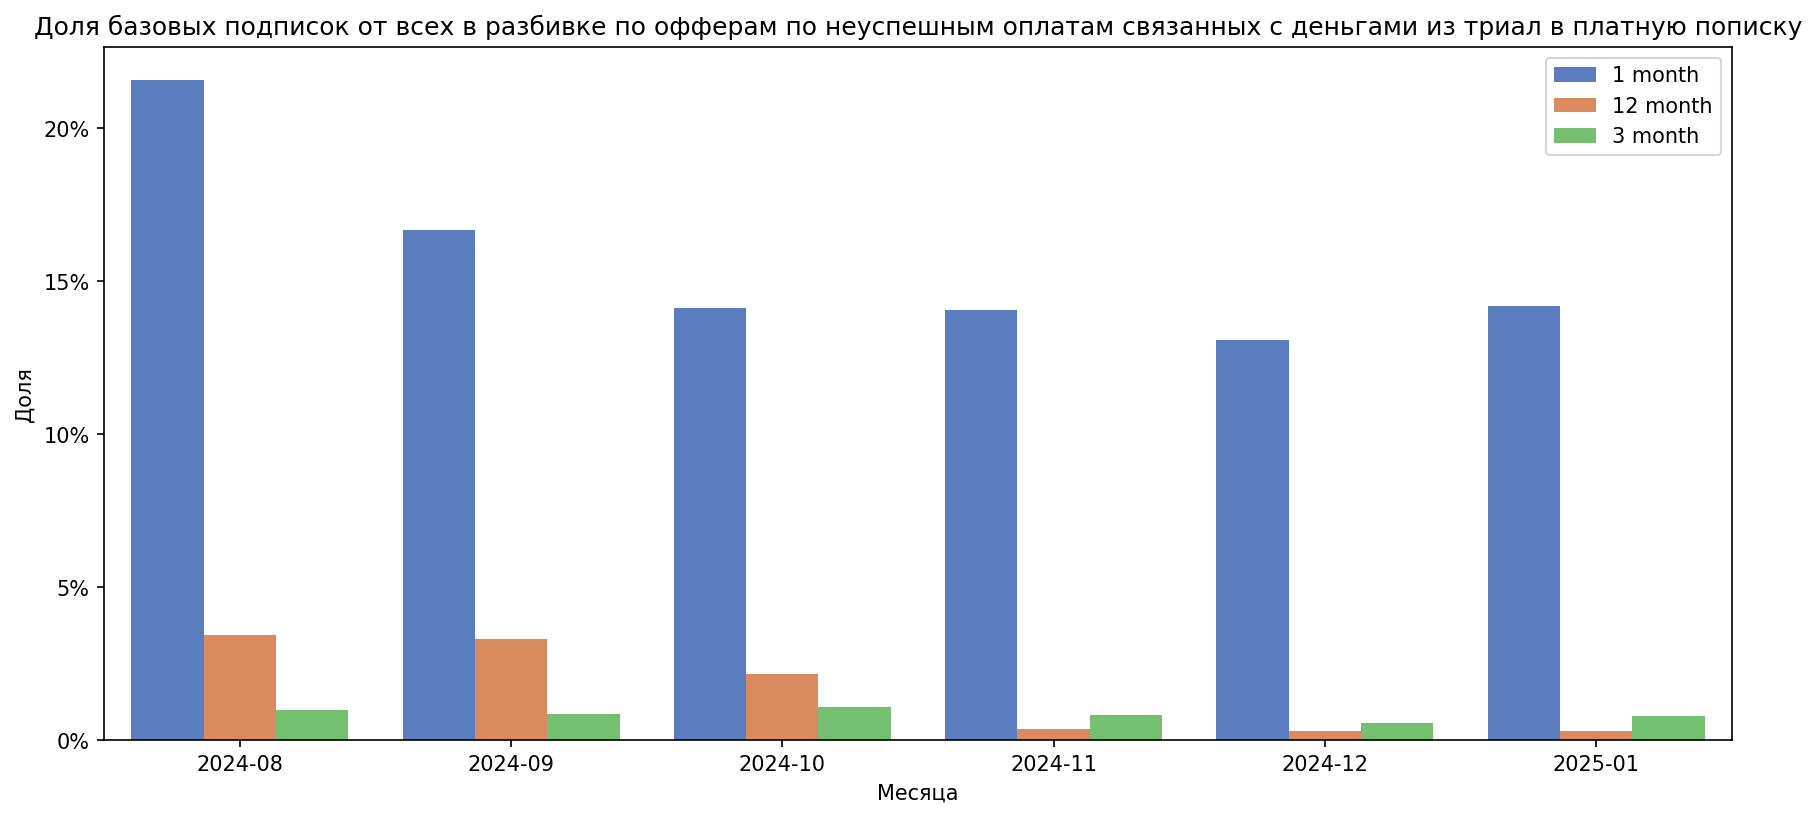

In [54]:
fig, (ax1) = plt.subplots(1,1,figsize=(14,6),dpi=150)

sns.barplot(data = merge_agg_trial,x='invoice_created_month',y='frac',hue='offer_duration',palette = 'muted',ax=ax1)
ax1.set_ylabel('Доля')
ax1.set_xlabel('Месяца')
ax1.set_title('Доля базовых подписок от всех в разбивке по офферам по неуспешным оплатам связанных с деньгами из триал в платную пописку')
ax1.legend(title='')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  


In [55]:
merge_agg_trial.groupby('offer_duration')['frac'].median().reset_index()

offer_duration      frac
0        1 month  0.141480
1       12 month  0.012558
2        3 month  0.008458

## Подписчики из 1 месяца не продляются во 2 месяц в целом и по причине отсутствия денег 

In [57]:
df_failure_all = df_failure[(df_failure['user_type']=='subs') & (df_failure['invoice_state']=='success') & (df_failure['invoice_created_month']<'2025-02-01')]
df_failure_all['next_invoice_state'] = df_failure_all['next_invoice_state'].apply(lambda x: 'current_trial/unsubscribe' if x == ''  else 
                                                               'other' if x in ['initial','refunded','processing']
                                                               else x)


df_failure_subs = df_failure[(df_failure['user_type']=='subs') & (df_failure['invoice_state']=='success') & (df_failure['next_invoice_state']=='failure') & (df_failure['invoice_created_month']<'2025-02-01')]
df_failure_subs_agg = df_failure_subs.groupby('invoice_created_month')['user_id'].nunique().reset_index()


df_failure_organic_subs = df_failure_organic[(df_failure_organic['invoice_state']=='success') & (df_failure_organic['user_type']=='subs') & (df_failure_organic['next_invoice_state']=='failure') & (df_failure_organic['invoice_created_month']<'2025-02-01')]
df_failure_organic_subs_agg = df_failure_organic_subs.groupby(['invoice_created_month','offer_duration'])['user_id'].nunique().reset_index()

merge_agg_subs = pd.merge(df_failure_organic_subs_agg,df_failure_subs_agg,how='left',on='invoice_created_month')

merge_agg_subs['frac'] = merge_agg_subs['user_id_x'] / merge_agg_subs['user_id_y']


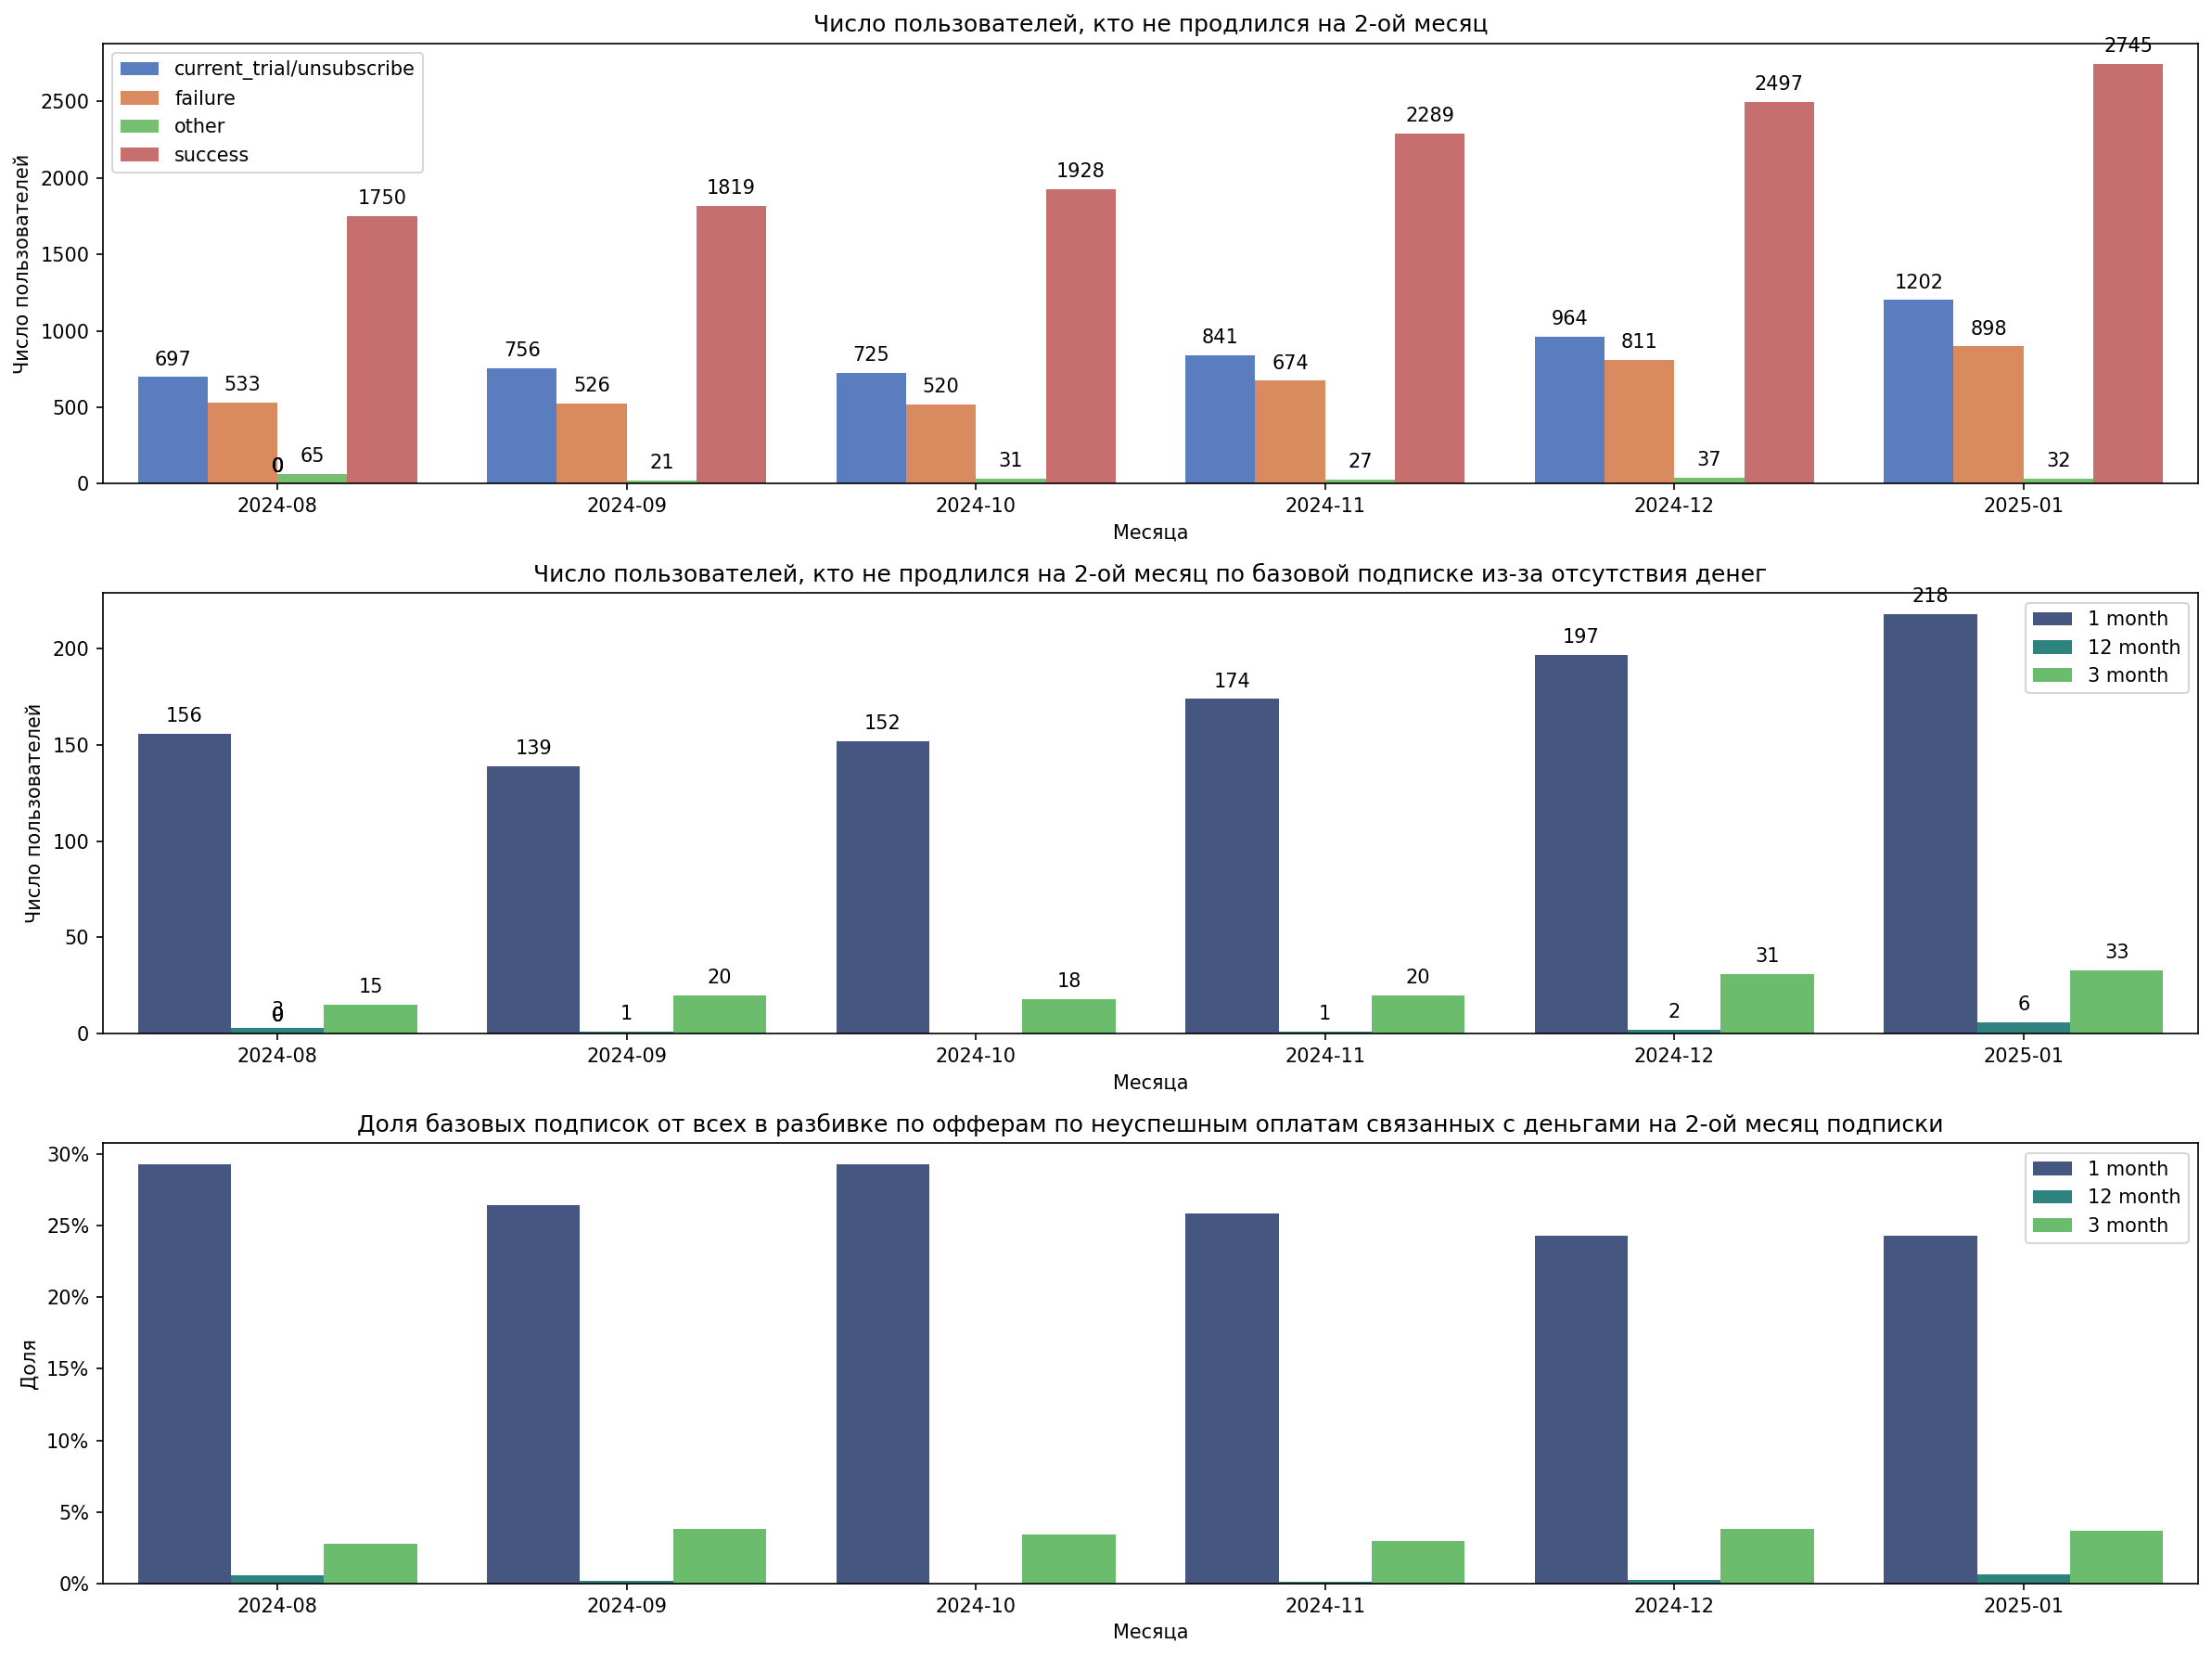

In [58]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16,12),dpi=150)

df_failure_all_agg = df_failure_all.groupby(['invoice_created_month','next_invoice_state'])['user_id'].nunique().reset_index()
barplot = sns.barplot(data = df_failure_all_agg,x='invoice_created_month',y='user_id',hue='next_invoice_state',palette = 'muted',ax=ax1)
ax1.set_ylabel('Число пользователей')
ax1.set_xlabel('Месяца')
ax1.set_title('Число пользователей, кто не продлился на 2-ой месяц')
ax1.legend(title='')
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  


barplot2=sns.barplot(data = merge_agg_subs,x='invoice_created_month',y='user_id_x',hue='offer_duration',palette = 'viridis',ax=ax2)
ax2.set_ylabel('Число пользователей')
ax2.set_xlabel('Месяца')
ax2.set_title('Число пользователей, кто не продлился на 2-ой месяц по базовой подписке из-за отсутствия денег')
ax2.legend(title='')

for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  


sns.barplot(data = merge_agg_subs,x='invoice_created_month',y='frac',hue='offer_duration',palette = 'viridis',ax=ax3)
ax3.set_ylabel('Доля')
ax3.set_xlabel('Месяца')
ax3.set_title('Доля базовых подписок от всех в разбивке по офферам по неуспешным оплатам связанных с деньгами на 2-ой месяц подписки')
ax3.legend(title='')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))  

plt.tight_layout() 
plt.show()

In [59]:
merge_agg_subs2 = merge_agg_subs[merge_agg_subs['invoice_created_month']<'2025-02-01'].groupby('offer_duration')[['frac','user_id_x']].median().reset_index()
merge_agg_subs2['user_id_x'] = merge_agg_subs['user_id_x'].astype(int)  
   
# Медианное число платных пользователей базовой подписки, кто не оплатил подписку на 2-ой период из-за отсутствия денег в разбивке по офферам   
# Медианное число доли пользователей базовой подписки, кто не оплатил подписку на 2-ой период из-за отсутствия денег в разбивке по офферам   
merge_agg_subs2

offer_duration      frac  user_id_x
0        1 month  0.261209        156
1       12 month  0.002466          3
2        3 month  0.035682         15

# Сравнение охватов пользователей android, кто доходит до cloudpayment и пользователей, кто отваливается из-за добилливания и отключения автопродления

In [61]:
query = '''SELECT utc_timestamp,date,visitor_id,user_id,event_name,client_type
            FROM datamarts.clean_event
            WHERE  date BETWEEN '2024-08-01' AND '2025-04-30'
            AND event_name='click_subscribe_offer_choose'
'''

df_android = execute(query,user='kmekhtiev')
df_android['date'] = pd.to_datetime(df_android['date'])

Время выполнения функции: 4.0507 секунд



In [62]:
df_android['date_month'] = df_android['date'].dt.to_period('M')
df_android_agg = df_android[df_android['client_type']=='android'].groupby(['client_type','date_month'])['user_id'].nunique().reset_index()

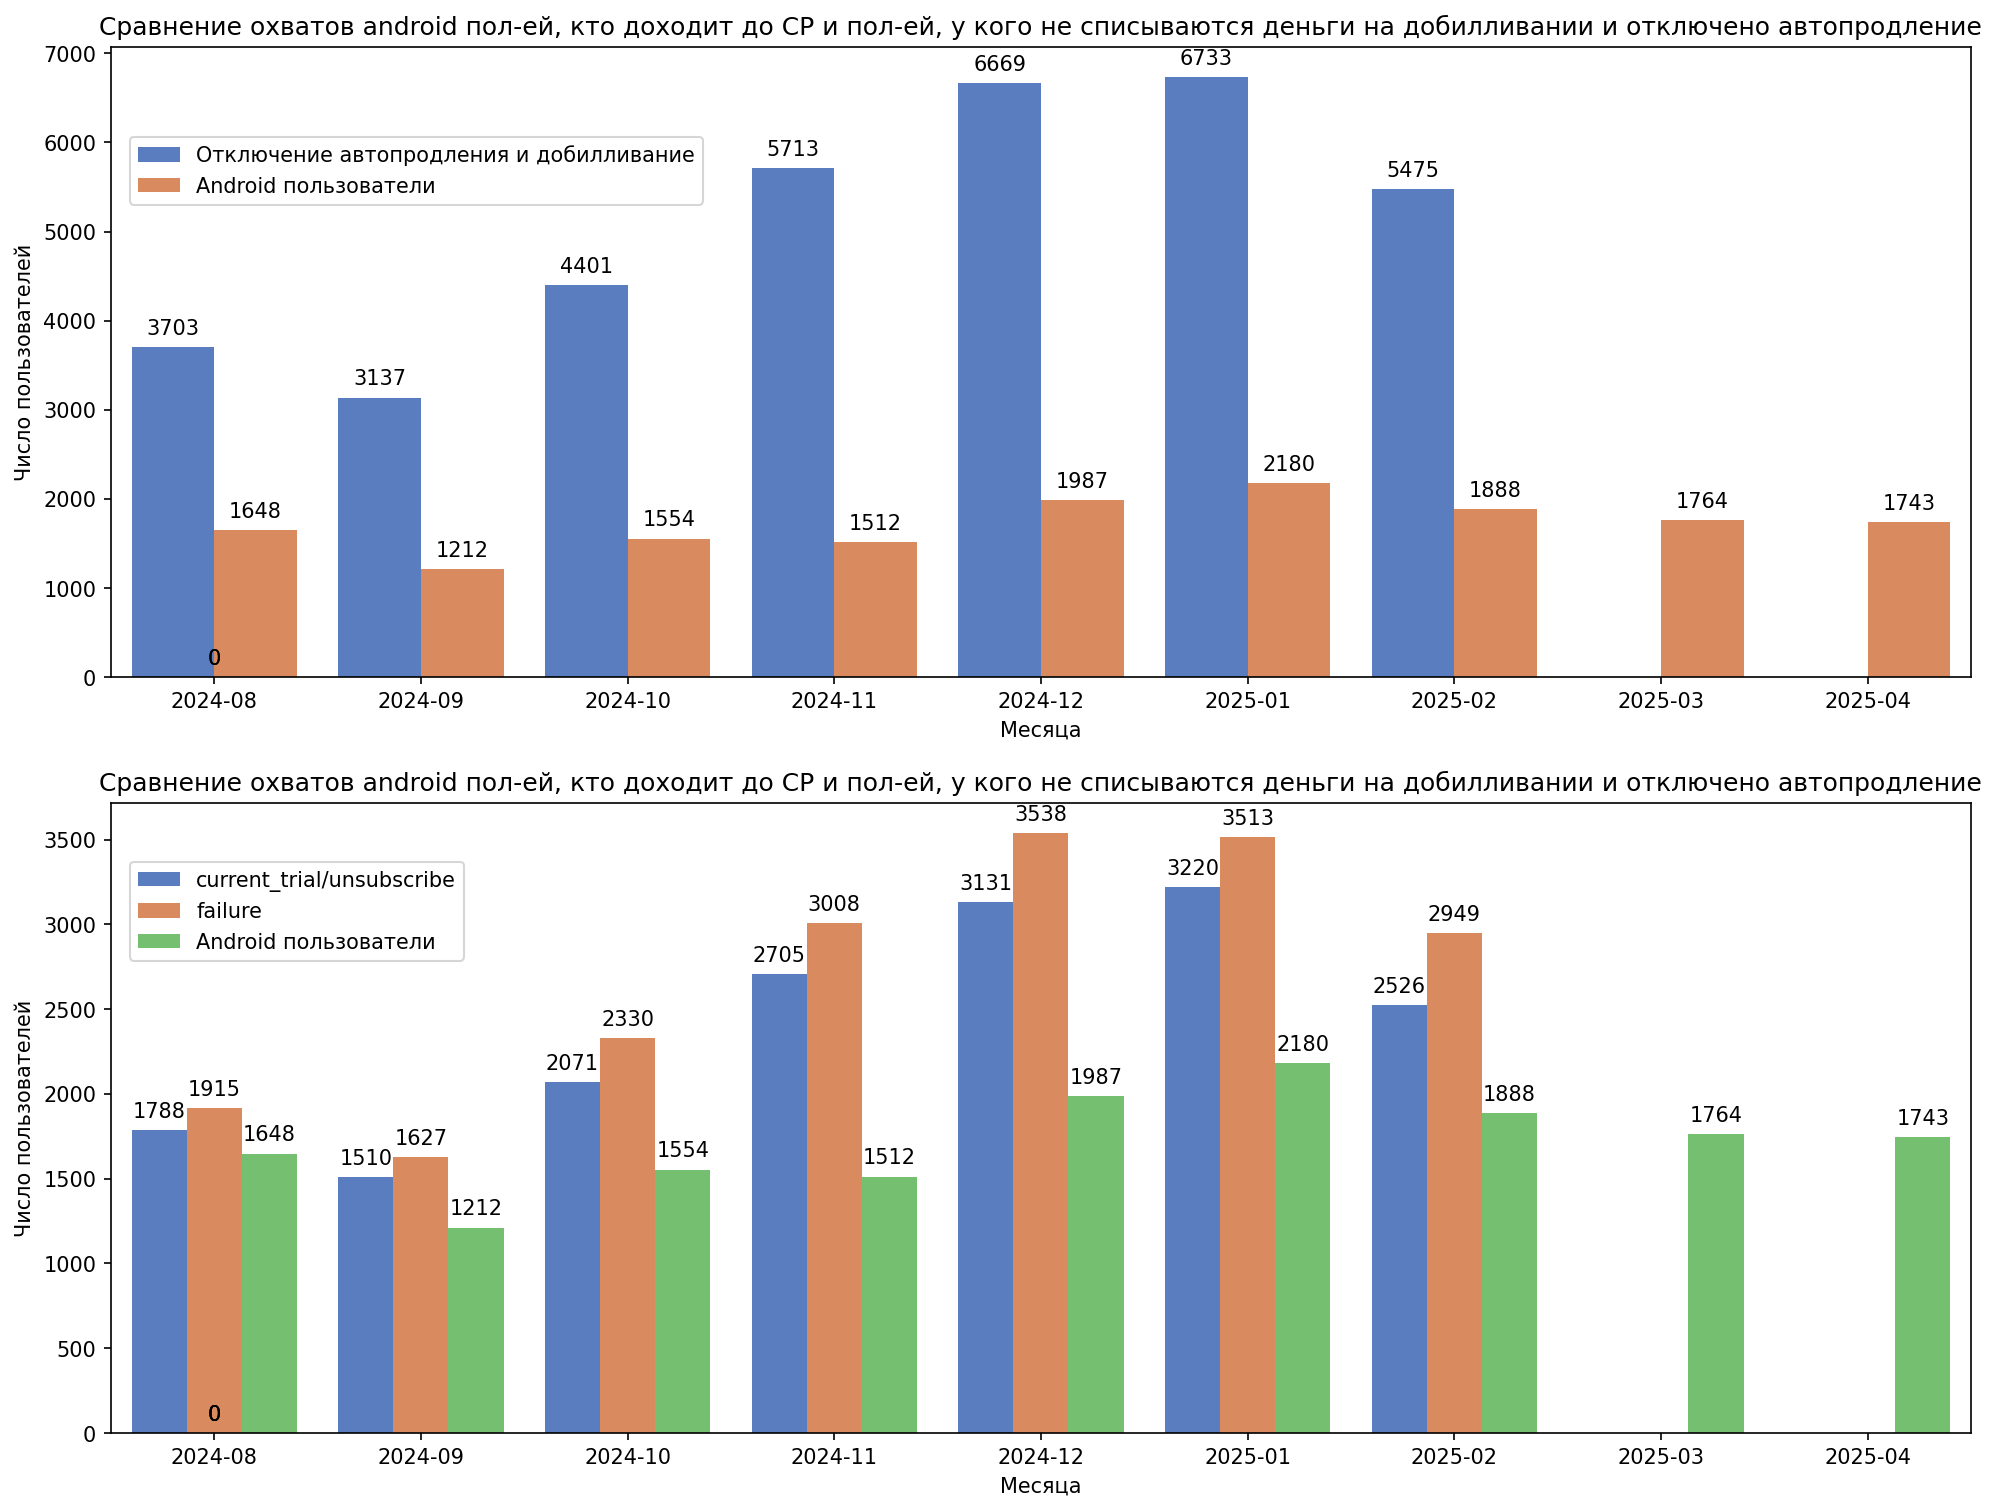

In [63]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,12),dpi=150)


df_invoice = r[(r['next_invoice_state'].isin(['current_trial/unsubscribe', 'failure'])) & (r['invoice_created_month'] <= '2025-02-01')]  
df_invoice['source'] = 'Отключение автопродления и добилливание'  # Добавляем столбец source  
df_invoice = df_invoice.groupby(['invoice_created_month','source'])['user_id'].sum().reset_index()

df_android_agg['source'] = 'Android пользователи'  # Добавляем столбец source  

# Объединяем оба DataFrame  
df_combined = pd.concat([  
    df_invoice[['invoice_created_month', 'user_id', 'source']],  
    df_android_agg[['date_month', 'user_id', 'source']].rename(columns={'date_month': 'invoice_created_month'})  
], ignore_index=True)  

barplot = sns.barplot(data = df_combined,x='invoice_created_month',y='user_id',hue='source',palette = 'muted',ax=ax1, ci=None)
ax1.set_ylabel('Число пользователей')
ax1.set_xlabel('Месяца')
ax1.set_title('Сравнение охватов android пол-ей, кто доходит до CP и пол-ей, у кого не списываются деньги на добилливании и отключено автопродление')
ax1.legend(title='',loc=(0.01,0.75))
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  
    
    
    
    

    
df_invoice2 = r[(r['next_invoice_state'].isin(['current_trial/unsubscribe', 'failure'])) & (r['invoice_created_month'] <= '2025-02-01')]  
df_invoice2['source'] = df_invoice2['next_invoice_state']  # Добавляем столбец source  

df_android_agg['source'] = 'Android пользователи'  # Добавляем столбец source  

# Объединяем оба DataFrame  
df_combined2 = pd.concat([  
    df_invoice2[['invoice_created_month', 'user_id', 'source']],  
    df_android_agg[['date_month', 'user_id', 'source']].rename(columns={'date_month': 'invoice_created_month'})  
], ignore_index=True)  

barplot2 = sns.barplot(data = df_combined2,x='invoice_created_month',y='user_id',hue='source',palette = 'muted',ax=ax2, ci=None)
ax2.set_ylabel('Число пользователей')
ax2.set_xlabel('Месяца')
ax2.set_title('Сравнение охватов android пол-ей, кто доходит до CP и пол-ей, у кого не списываются деньги на добилливании и отключено автопродление')
ax2.legend(title='',loc=(0.01,0.75))
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  

In [64]:
median = df_combined2[df_combined2['invoice_created_month']<'2025-02-01'].groupby('source')['user_id'].median().reset_index()
median['user_id'] = median['user_id'].astype(int)  
   
# Медианное число триал пользователей с перидом 14 дней в разбивке по статусам инвойсов    
median

source  user_id
0       Android пользователи     1601
1  current_trial/unsubscribe     2388
2                    failure     2669

# Исследуем пользователей с инвойсом inititial 

In [66]:
query = '''WITH all_info AS (SELECT  
        s.user_id AS user_id,
        t3.profile_id AS profile_id,
        t3.created_at::date AS subscription_created_at,
        i.created_at::date as invoice_created_at,
        t3.reg_date AS reg_date,
        date_trunc('month',reg_date)::date AS reg_month,
        s.id AS id,
        t4.source AS source,
        t5.client_type AS client_type,
        t3.device AS device,
        t3.reg_source AS reg_source,
        t3.bonus_title AS bonus_title,
        t6.bonus_title_new AS bonus_title_new,
        t3.first_prolong_date AS first_prolong_date,
        leadInFrame(id) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_id,
        i.state as invoice_state,
        leadInFrame(invoice_state) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_state,
        i.id as invoice_id,
        leadInFrame(invoice_created_at) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_created_at,  
        next_invoice_created_at::date - invoice_created_at::date delta_date,
        i.price_cents AS price_cents,
        i.price_currency AS price_currency,
        i.refund_amount_cents AS refund_amount_cents,
        ROW_NUMBER() OVER (PARTITION BY user_id,id,id,user_type,invoice_state ORDER BY invoice_created_at) AS rn_num,
        CASE WHEN price_cents<=100 AND invoice_state='success' THEN 'trial'
             WHEN price_cents<=100 AND invoice_state IN ('failure','initial') THEN 'not_success_trial'
             ELSE 'subs'
             END user_type,
        leadInFrame(user_type) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_user_type, 
        t2.renewal_off_date AS renewal_off_date,
        CASE WHEN renewal_off_date!='1970-01-01' THEN 1 ELSE 0 END unsubscribe_type,
        t3.free_days AS free_days,
        t3.offer_duration AS offer_duration,
        t3.promo_type AS promo_type,
        i.paid_at AS paid_at,
        --i.period_end,
        s.platform AS platform,
       -- i.payment_target,
        i.deleted_at,
        i.refunded_at
    FROM raw.viju__product_x__public__invoices i
    LEFT JOIN raw.viju__product_x__public__subscriptions s 
        ON i.subscription_id = s.id  
    LEFT JOIN (SELECT
                subscription_id,
                max(created_at) as renewal_off_date
                FROM raw.viju__product_x__public__subscription_cancel_reasons
                WHERE created_at >= '2022-03-01'
                 --AND subscription_id='74bcff94-4ada-40ef-85de-25074d615d57'
                GROUP by 1
                ) AS t2 ON i.subscription_id=t2.subscription_id
    INNER JOIN datamarts.marketing_dash AS t3 ON s.user_id=t3.user_id
    LEFT JOIN (SELECT user_id,max(source) AS source
               FROM datamarts.clean_event
               WHERE reg_date BETWEEN '2024-08-01' AND '2025-04-30'
               GROUP BY 1) AS t4
               ON s.user_id=t4.user_id
               
    LEFT JOIN (SELECT user_id,max(client_type) AS client_type
               FROM datamarts.clean_event
               WHERE reg_date BETWEEN '2024-08-01' AND '2025-04-30'
               GROUP BY 1) AS t5
               ON s.user_id=t5.user_id
               
    LEFT JOIN  sandbox.mekhtiev_bonus2  as t6
    on t3.bonus_title = t6.bonus_title_old
    WHERE s.platform != 'api'
    ORDER BY s.user_id, invoice_created_at 
    )
--    
SELECT * FROM all_info
WHERE invoice_created_at::date BETWEEN '2024-08-01' AND '2025-04-30'
AND reg_date BETWEEN '2024-08-01' AND '2025-04-30'
--AND user_type!='not_success_trial'
AND platform=='cloudpayments'
'''

df_initial = execute(query,user='kmekhtiev')
df_initial['reg_date'] = pd.to_datetime(df_initial['reg_date'])

df_initial['reg_month'] = pd.to_datetime(df_initial['reg_month'])
df_initial['first_prolong_date'] = pd.to_datetime(df_initial['first_prolong_date'])
df_initial['invoice_created_at'] = pd.to_datetime(df_initial['invoice_created_at'])
df_initial['subscription_created_at'] = pd.to_datetime(df_initial['subscription_created_at'])

Время выполнения функции: 23.1604 секунд



In [67]:
df_initial['invoice_created_month'] = df_initial['invoice_created_at'].dt.to_period('M')

df_initial_agg = df_initial.groupby('user_id')['invoice_state'].nunique().reset_index()
only_one_state_users = df_initial_agg[df_initial_agg['invoice_state'] == 1]

initial_only_df = df_initial[df_initial['invoice_state'] == 'initial']
result = initial_only_df[initial_only_df['user_id'].isin(only_one_state_users['user_id'])]

result = result[result['subscription_created_at'] == '1970-01-01']

#result['paid_organic'] = result.apply(lambda x:'organic' if x=='none' else 'paid',raw = True)
result['paid_organic'] = result['reg_source'].apply(lambda x: 'organic' if x == 'none' else 'paid')  

In [68]:
result['invoice_created_month'].unique()


<PeriodArray>
['2025-01', '2025-04', '2024-10', '2025-03', '2025-02', '2024-11', '2024-08',
 '2024-12', '2024-09']
Length: 9, dtype: period[M]

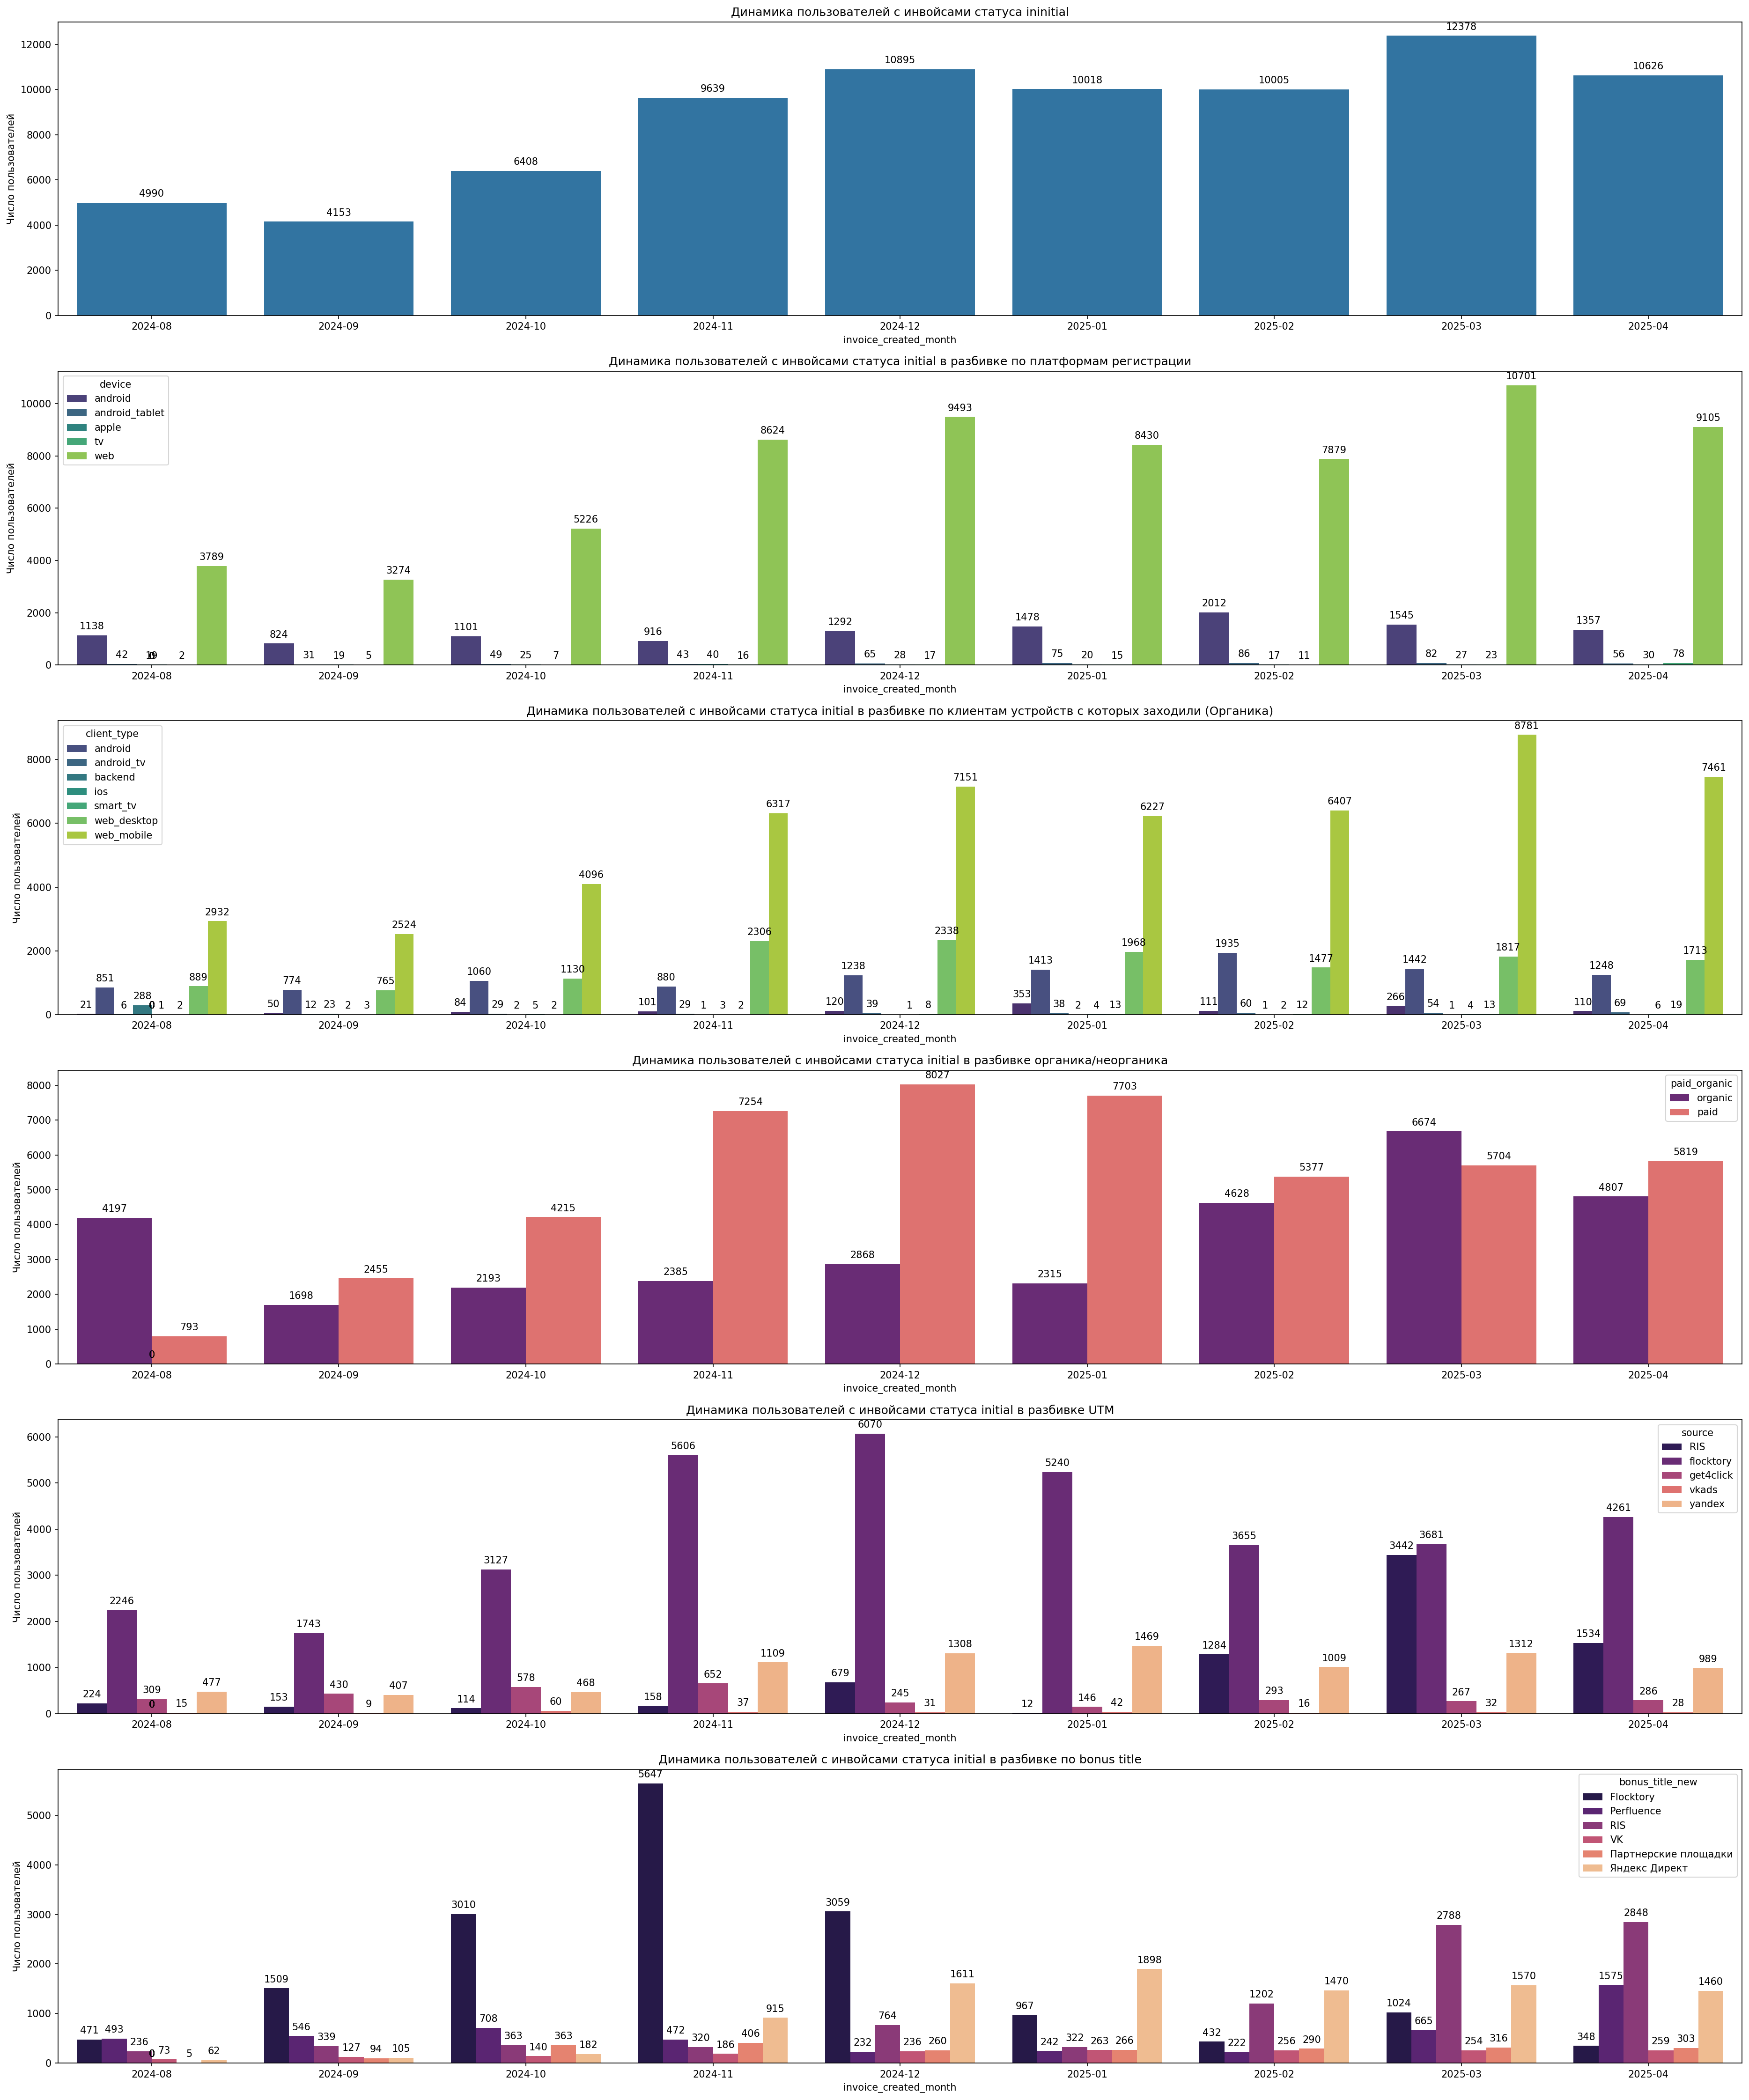

In [69]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(25,30),dpi=150)

result_agg = result.groupby('invoice_created_month')['user_id'].nunique().reset_index()
barplot = sns.barplot(data = result_agg,x='invoice_created_month',y='user_id', ci=None, ax=ax1)
ax1.set_ylabel('Число пользователей')
ax1.set_title('Динамика пользователей с инвойсами статуса ininitial')
for p in barplot.patches:  
    barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  



result_agg2 = result.groupby(['invoice_created_month','device'])['user_id'].nunique().reset_index()
barplot2 = sns.barplot(data = result_agg2,x='invoice_created_month',y='user_id',hue='device',palette='viridis', ci=None, ax=ax2)
ax2.set_ylabel('Число пользователей')
ax2.set_title('Динамика пользователей с инвойсами статуса initial в разбивке по платформам регистрации')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  
    

result_agg3 = result.groupby(['invoice_created_month','client_type'])['user_id'].nunique().reset_index()
barplot3 = sns.barplot(data = result_agg3,x='invoice_created_month',y='user_id',hue='client_type',palette='viridis', ci=None, ax=ax3)
ax3.set_ylabel('Число пользователей')
ax3.set_title('Динамика пользователей с инвойсами статуса initial в разбивке по клиентам устройств с которых заходили (Органика)')
for p in barplot3.patches:  
    barplot3.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  
    


    
    
    
result_agg4 = result.groupby(['invoice_created_month','paid_organic'])['user_id'].nunique().reset_index()

barplot4 = sns.barplot(data = result_agg4,x='invoice_created_month',y='user_id',hue='paid_organic',palette='magma', ci=None, ax=ax4)
ax4.set_ylabel('Число пользователей')
ax4.set_title('Динамика пользователей с инвойсами статуса initial в разбивке органика/неорганика')
for p in barplot4.patches:  
    barplot4.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 
    
   
result_agg5 = result[result['source']!=''].groupby(['invoice_created_month','source'])['user_id'].nunique().reset_index()
source = ['RIS','flocktory','yandex','get4click','vkads']
barplot5 = sns.barplot(data = result_agg5[result_agg5['source'].isin(source)],x='invoice_created_month',y='user_id',hue='source',palette='magma', ci=None, ax=ax5)
ax5.set_ylabel('Число пользователей')
ax5.set_title('Динамика пользователей с инвойсами статуса initial в разбивке UTM')
for p in barplot5.patches:  
    barplot5.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 

   
result_agg6 = df_initial[df_initial['bonus_title_new']!=''].groupby(['invoice_created_month','bonus_title_new'])['user_id'].nunique().reset_index()
bonus_title_new = ['Flocktory','RIS','Яндекс Директ','Perfluence','Партнерские площадки','VK']
barplot6 = sns.barplot(data = result_agg6[result_agg6['bonus_title_new'].isin(bonus_title_new)],x='invoice_created_month',y='user_id',hue='bonus_title_new',palette='magma', ci=None, ax=ax6)
ax6.set_ylabel('Число пользователей')
ax6.set_title('Динамика пользователей с инвойсами статуса initial в разбивке по bonus title')
for p in barplot6.patches:  
    barplot6.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points') 


      
plt.tight_layout() 
plt.show()

In [71]:
result_agg5[result_agg5['source'].isin(source)].groupby('source')['user_id'].median()

source
RIS           224.0
flocktory    3681.0
get4click     293.0
vkads          31.0
yandex       1009.0
Name: user_id, dtype: float64

In [72]:
result_agg6[result_agg6['bonus_title_new'].isin(bonus_title_new)].groupby('bonus_title_new')['user_id'].median()

bonus_title_new
Flocktory               1024.0
Perfluence               493.0
RIS                      363.0
VK                       236.0
Партнерские площадки     290.0
Яндекс Директ           1460.0
Name: user_id, dtype: float64

In [73]:
result_agg4['sum_all'] = result_agg4.groupby('invoice_created_month')['user_id'].transform('sum')
result_agg4['frac'] = result_agg4['user_id'] / result_agg4['sum_all']

print(result_agg4.groupby('paid_organic')['user_id'].median())
print()
print(result_agg4.groupby('paid_organic')['frac'].median())

paid_organic
organic    2868.0
paid       5704.0
Name: user_id, dtype: float64

paid_organic
organic    0.408861
paid       0.591139
Name: frac, dtype: float64


## Посмотрим из каких каналов приходят Неорганика


In [75]:
query = '''SELECT date,visitor_id,user_id,source,reg_source,reg_date,created_at::date AS created_date,first_prolong_date::date AS first_prolong_date,bonus_title
           FROM datamarts.clean_event
           WHERE date BETWEEN '2024-08-01' AND '2025-04-30'
           GROUP BY 1,2,3,4,5,6,7,8,9
           '''


df_cr = execute(query,user='kmekhtiev')
df_cr['date'] = pd.to_datetime(df_cr['date'])
df_cr['created_date'] = pd.to_datetime(df_cr['created_date'])
df_cr['reg_date'] = pd.to_datetime(df_cr['reg_date'])
df_cr['date'] = df_cr['date'].dt.to_period('M')
df_cr['reg_date'] = df_cr['reg_date'].dt.to_period('M')
df_cr['created_date'] = df_cr['created_date'].dt.to_period('M')

Время выполнения функции: 91.0917 секунд



### Воронка пользователей по каналам

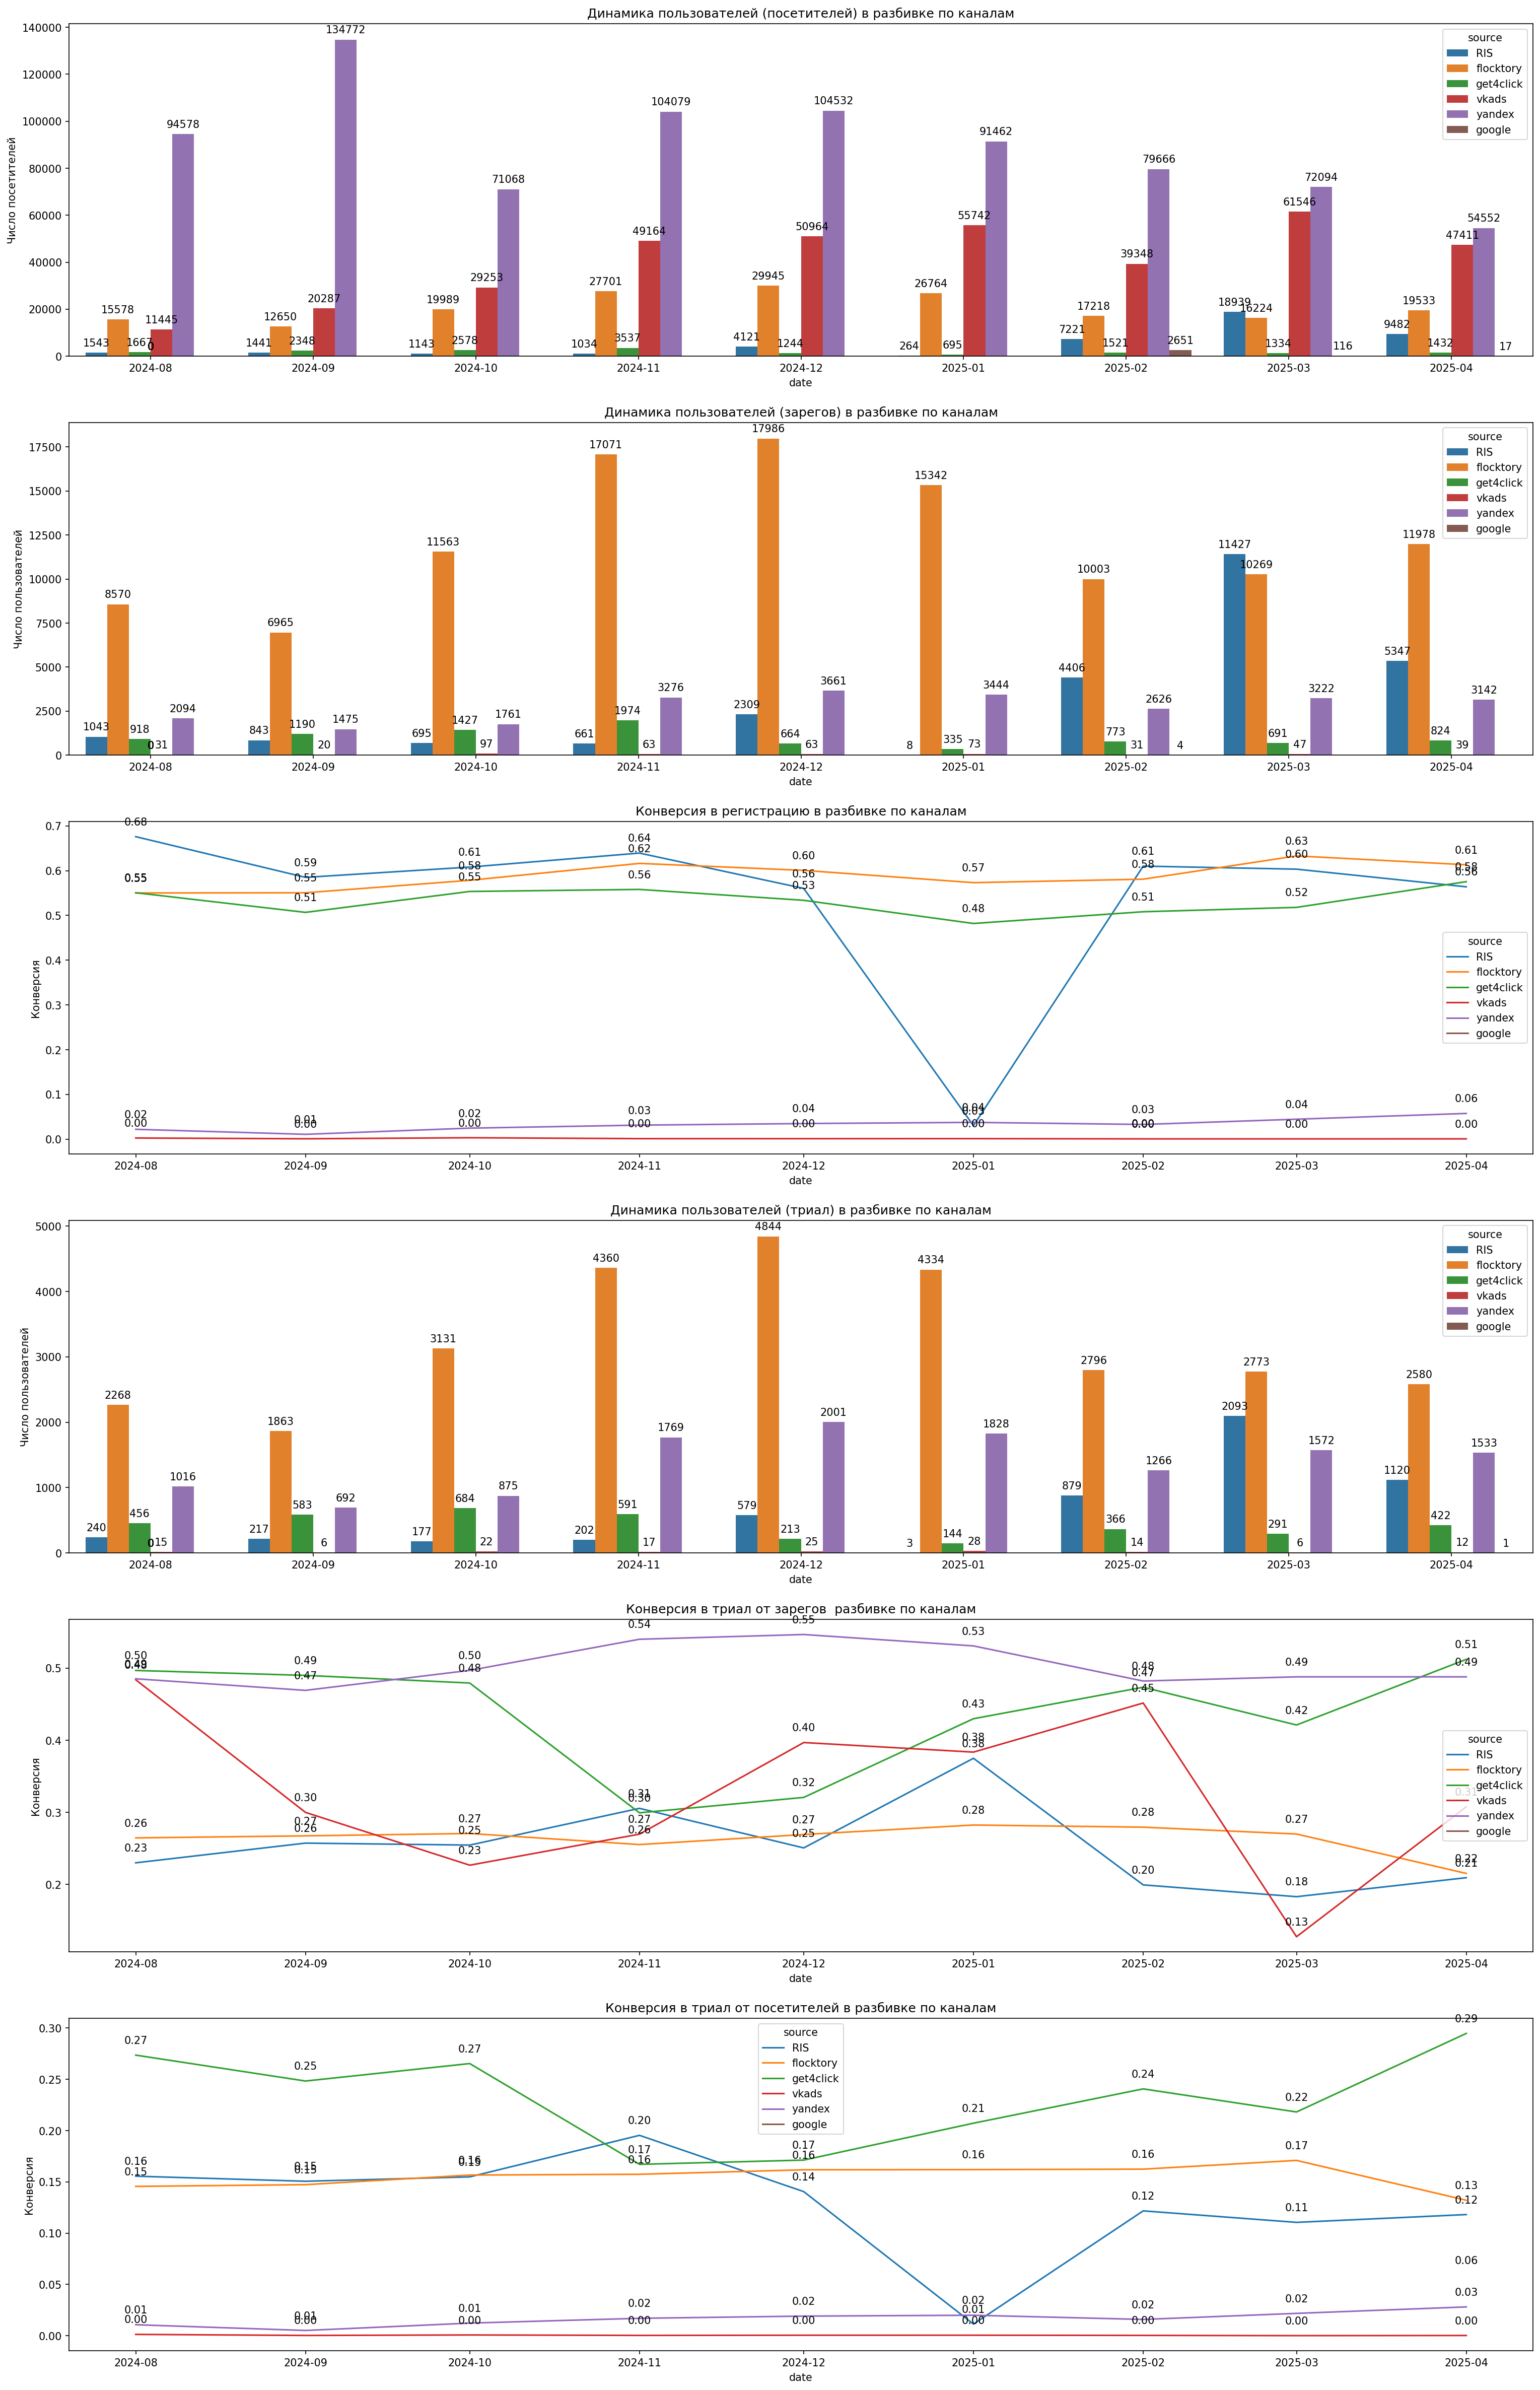

In [77]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(25,40),dpi=150)

source = ['RIS','flocktory','yandex','get4click','vkads','google']
result_agg = df_cr.groupby(['date','source'])['visitor_id'].nunique().reset_index()
result_agg = result_agg[result_agg['source'].isin(source)]
barplot = sns.barplot(data = result_agg,x='date',y='visitor_id', hue='source', ci=None, ax=ax1)
ax1.set_ylabel('Число посетителей')
ax1.set_title('Динамика пользователей (посетителей) в разбивке по каналам')
for p in barplot.patches:  
     barplot.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                        (p.get_x() + p.get_width() / 2., p.get_height()),  
                        ha = 'center', va = 'center',  
                        xytext = (0, 9),   # Смещение по вертикали  
                        textcoords = 'offset points')  



result_agg2 = df_cr[df_cr['reg_date'] == df_cr['date']].groupby(['date','source'])['user_id'].nunique().reset_index()
result_agg2 = result_agg2[result_agg2['source'].isin(source)]
barplot2 = sns.barplot(data = result_agg2,x='date',y='user_id',hue='source', ci=None, ax=ax2)
ax2.set_ylabel('Число пользователей')
ax2.set_title('Динамика пользователей (зарегов) в разбивке по каналам')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')  
    
    
    
result_agg3 = pd.merge(result_agg,result_agg2,on=['date','source'],how='left')
result_agg3['cr_reg'] = result_agg3['user_id'] / result_agg3['visitor_id'] 
result_agg3['date'] = result_agg3['date'].dt.to_timestamp()
result_agg3['date'] = pd.to_datetime(result_agg3['date'], format='%Y-%m')  # если не было преобразования
lineplot = sns.lineplot(data = result_agg3,x='date',y='cr_reg',hue='source', ci=None, ax=ax3)
ax3.set_ylabel('Конверсия')
ax3.set_title('Конверсия в регистрацию в разбивке по каналам')
for line in ax3.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax3.annotate(
            format(y, '.2f'),  # или другие форматы
            xy=(x, y),
            xytext=(0, 9),
            textcoords='offset points',
            ha='center',
            va='bottom'
        )

result_agg4 = df_cr[df_cr['created_date'] == df_cr['date']].groupby(['date','source'])['user_id'].nunique().reset_index()
result_agg4 = result_agg4[result_agg4['source'].isin(source)]
barplot2 = sns.barplot(data = result_agg4,x='date',y='user_id',hue='source', ci=None, ax=ax4)
ax4.set_ylabel('Число пользователей')
ax4.set_title('Динамика пользователей (триал) в разбивке по каналам')
for p in barplot2.patches:  
    barplot2.annotate(format(p.get_height(), '.0f'),  # Форматируем значение как целое число  
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha = 'center', va = 'center',  
                       xytext = (0, 9),   # Смещение по вертикали  
                       textcoords = 'offset points')     
    

result_agg5 = pd.merge(result_agg4,result_agg2,on=['date','source'],how='left')
result_agg5['cr_trial_from_reg'] = result_agg5['user_id_x'] / result_agg5['user_id_y'] 
result_agg5['date'] = result_agg5['date'].dt.to_timestamp()
result_agg5['date'] = pd.to_datetime(result_agg5['date'], format='%Y-%m')  
lineplot = sns.lineplot(data = result_agg5,x='date',y='cr_trial_from_reg',hue='source', ci=None, ax=ax5)
ax5.set_ylabel('Конверсия')
ax5.set_title('Конверсия в триал от зарегов  разбивке по каналам')
for line in ax5.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax5.annotate(
            format(y, '.2f'),  # или другие форматы
            xy=(x, y),
            xytext=(0, 9),
            textcoords='offset points',
            ha='center',
            va='bottom'
        )
        
   
result_agg6 = pd.merge(result_agg4,result_agg,on=['date','source'],how='left')
result_agg6['cr_trial_from_visitor'] = result_agg6['user_id'] / result_agg6['visitor_id'] 
result_agg6['date'] = result_agg6['date'].dt.to_timestamp()
result_agg6['date'] = pd.to_datetime(result_agg6['date'], format='%Y-%m')  
lineplot = sns.lineplot(data = result_agg6,x='date',y='cr_trial_from_visitor',hue='source', ci=None, ax=ax6)
ax6.set_ylabel('Конверсия')
ax6.set_title('Конверсия в триал от посетителей в разбивке по каналам')
for line in ax6.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        ax6.annotate(
            format(y, '.2f'),  # или другие форматы
            xy=(x, y),
            xytext=(0, 9),
            textcoords='offset points',
            ha='center',
            va='bottom'
        )

# plt.tight_layout() 
# plt.show()

In [256]:
print(result_agg.groupby('source')['visitor_id'].median().reset_index())
print()
print(result_agg2.groupby('source')['user_id'].median().reset_index())
print()
print(result_agg3.groupby('source')['cr_reg'].median().reset_index())
print()
print(result_agg5.groupby('source')['cr_trial_from_reg'].median().reset_index())
print()
print(result_agg6.groupby('source')['cr_trial_from_visitor'].median().reset_index())

      source  visitor_id
0        RIS      1543.0
1  flocktory     19533.0
2  get4click      1521.0
3     google       116.0
4      vkads     47411.0
5     yandex     91462.0

      source  user_id
0        RIS   1043.0
1  flocktory  11563.0
2  get4click    824.0
3     google      4.0
4      vkads     47.0
5     yandex   3142.0

      source    cr_reg
0        RIS  0.603358
1  flocktory  0.580962
2  get4click  0.533762
3     google  0.001509
4      vkads  0.001236
5     yandex  0.032963

      source  cr_trial_from_reg
0        RIS           0.250758
1  flocktory           0.269321
2  get4click           0.473480
3     google                NaN
4      vkads           0.307692
5     yandex           0.487906

      source  cr_trial_from_visitor
0        RIS               0.140500
1  flocktory               0.157395
2  get4click               0.240631
3     google               0.058824
4      vkads               0.000356
5     yandex               0.016997


## Точки входа

In [80]:
query = '''
SELECT
	date, 
	user_id, 
	client_type,
    device_type,
    app_version,
    os_version,
    browser_version,
    country, 
    entry_point,
    entry_point || '_' || event_page as entry_point_event_page,
    user_type,
    event_page,
    offer_type,
    if(countIf (event_name = 'goto_offer_page')>0, 1, 0) as step_1_goto_offer_page,
    if(countIf (event_name = 'click_subscribe_offer_choose')>0, 1, 0) as step_2_click_subscribe_offer_choose,
    if(countIf (event_name = 'click_subscribe_pay')>0, 1, 0) as step_3_click_subscribe_pay
FROM(    
SELECT 
    date_raw, 
    user_type_raw,
    user_id,
    client_type,
    device_type,
    os_version,
    app_version,
    browser_version,
    country, 
    entry_point_raw,
    offer_type_raw,
    event_name, 
    utc_timestamp,
    row_number() over (partition by user_id order by utc_timestamp) as step_num,
    case 
      when event_name = 'click_subscribe_offer_choose' 
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
      then lagInFrame(entry_point_raw, 1) over (partition by user_id order by utc_timestamp)
      when event_name = 'click_subscribe_pay' 
        and lagInFrame(event_name, 2) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'click_subscribe_offer_choose'
      then lagInFrame(entry_point_raw, 2) over (partition by user_id order by utc_timestamp)
      else entry_point_raw
    end as entry_point, 
    case 
      when event_name = 'click_subscribe_offer_choose' 
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
      then lagInFrame(date_raw, 1) over (partition by user_id order by utc_timestamp)
      when event_name = 'click_subscribe_pay' 
        and lagInFrame(event_name, 2) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'click_subscribe_offer_choose'
      then lagInFrame(date_raw, 2) over (partition by user_id order by utc_timestamp)
      else date_raw
    end as date,  -- кейс: первый шаг в день Х, а второй/третий - в день Х+1 и позже. Все события приводим к первому дню 
    case 
      when event_name = 'click_subscribe_offer_choose' 
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
      then lagInFrame(user_type_raw, 1) over (partition by user_id order by utc_timestamp)
      when event_name = 'click_subscribe_pay' 
        and lagInFrame(event_name, 2) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'click_subscribe_offer_choose'
      then lagInFrame(user_type_raw, 2) over (partition by user_id order by utc_timestamp)
      else user_type_raw
    end as user_type,  -- Все типы приводим к типу первого шага 
    case 
      when event_name = 'click_subscribe_offer_choose' 
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
      then lagInFrame(event_page_raw, 1) over (partition by user_id order by utc_timestamp)
      when event_name = 'click_subscribe_pay' 
        and lagInFrame(event_name, 2) over (partition by user_id order by utc_timestamp) == 'goto_offer_page'
        and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp) == 'click_subscribe_offer_choose'
      then lagInFrame(event_page_raw, 2) over (partition by user_id order by utc_timestamp)
      else event_page_raw
    end as event_page, -- Все страницы приводим к странице первого шага 
    case 
      when event_name = 'click_subscribe_offer_choose' 
      and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp desc) == 'click_subscribe_pay' 
      then lagInFrame(offer_type_raw, 1) over (partition by user_id order by utc_timestamp desc)
      when event_name = 'goto_offer_page' 
      and lagInFrame(event_name, 1) over (partition by user_id order by utc_timestamp desc) == 'click_subscribe_offer_choose' 
      and lagInFrame(event_name, 2) over (partition by user_id order by utc_timestamp desc) == 'click_subscribe_pay'
      then lagInFrame(offer_type_raw, 2) over (partition by user_id order by utc_timestamp desc)
      else offer_type_raw
    end as offer_type
    FROM (
      SELECT 
        date as date_raw,
        event_name,
        user_id, 
        client_type, -- android, ios, web_desktop, web_mobile
        utc_timestamp,
        first_prolong_date,
        state,
        reg_date, 
        device_type,
        os_version,
        app_version,
        browser_version,
        created_at, -- дата создания подписки/начала
        ends_at, -- дата следующего списания или в случая отмененных подписок - дата окончания
        country,
        JSONExtractString(payload,'from') as payload_from,
        if (event_page='' or event_page is null, 'other', event_page) as event_page_raw,
        case 
          when event_name in ('click_subscribe_offer_choose', 'click_subscribe_pay')  then '' -- события 2 и 3 шага
          when payload_from = 'action_button' 
            and event_page in ('main', 'movie', 'series', 'tvchannel', 'tv', 'mychannel', 'collections','catalog', 'compilation') then 'Шапка' 
          when payload_from in ('', 'banner') and event_page = 'main' then 'Врезка' -- ждем доработку - появление banner
          when payload_from = 'watch_button' and event_page = 'main' then 'Киномы' -- плеер киномов
          when payload_from = 'watch_button' and event_page in ('item', 'tvchannel', 'mychannel', 'movie', 'series', 'collections') then 'Смотреть' 
          when payload_from = 'tbd_событие_Клик_на_серию' then 'Клик на серию'
          -- в будущем будет событие Смотреть из кинома
          when payload_from = 'after_free_watch' and event_page in ('item', 'series') then 'Смотреть after_free'
          when payload_from = 'action_button' and event_page = 'account' then 'Профиль'
          when payload_from = 'free_tv' and event_page = 'tvchannel' then 'Беспл.ТВ pop-up'
          when payload_from = 'after_auth' and event_page = 'account' then 'after_auth'
          else 'Другое'
        end as entry_point_raw, -- для шага 1
        case
	      when profile_id is null then 'Неавторизован' 	
	      -- на статус не опираемся, тк он меняется со временем
	      when (first_prolong_date != '1970-01-01' and first_prolong_date <= date)  then 'Подписчик (есть/был)'
          when (first_prolong_date = '1970-01-01' or first_prolong_date > date) and (created_at != '1970-01-01 00:00:00' and created_at <= date)
          	then 'Триальщик (есть/был)'
          when (first_prolong_date = '1970-01-01' or first_prolong_date > date) and (created_at = '1970-01-01 00:00:00' or created_at > date)
          	and (reg_date != '1970-01-01' and reg_date < date) then 'Зарег'	
          when (first_prolong_date = '1970-01-01' or first_prolong_date > date) and (created_at = '1970-01-01 00:00:00' or created_at > date)
          	and reg_date = date then 'Зарег (новичок)' 
          when reg_date = '1970-01-01' and profile_id is not null then 'Зарег (no data)' --  нет инфо по статусу и датам
          else 'Другое'
        end as user_type_raw, -- для шага 1
          case 
	        when event_name in ('goto_offer_page', 'click_subscribe_offer_choose')  then ''  
		    -- пока еще не стал платящим:
	        when free_days = 14 and price_cents = 29900 and date <= '2025-04-10' 
	        	or free_days = 14 and price_cents = 39900 and date >= '2025-04-10'  then '1 мес'
		    when free_days = 3 and price_cents = 49900 and date <= '2025-04-10' 
		    	or free_days = 3 and price_cents = 64900 and date >= '2025-04-10' then '3 мес'
		    when free_days = 3 and price_cents = 119000 and date <= '2025-04-10' 
		    	or free_days = 3 and price_cents = 155000 and date >= '2025-04-10'  then '12 мес' 
		    when free_days not in (3, 14) and price_cents not in (29900, 49900, 119000) and date <= '2025-04-10' 
		    	or free_days not in (3, 14) and price_cents not in (39900, 64900, 155000) and date >= '2025-04-10' 
		    then 'Промо: Цена+Дни'
		    when free_days not in (3, 14) then 'Промо: Дни'
		    when price_cents not in (29900, 49900, 119000) and date <= '2025-04-10' 
		    	or price_cents not in (39900, 64900, 155000) and date >= '2025-04-10'  then 'Промо: Цена'
		    else 'Другое'
		  end as offer_type_raw -- для шага 3
      FROM datamarts.clean_event AS ce
      WHERE event_name in ('goto_offer_page',  'click_subscribe_offer_choose', 'click_subscribe_pay','show_subscribe_offer_page','auto_subscribe_cloudpayments_displayed')
      and client_type in ('web_desktop', 'web_mobile')
      and date BETWEEN '2024-08-01' AND '2025-04-30'
    )
) where entry_point != '' AND user_id IS NOT NULL 
GROUP BY 
  date, user_id, client_type, device_type, os_version, app_version, browser_version, country, entry_point, user_type, event_page, offer_type
ORDER BY step_1_goto_offer_page DESC
'''

df_entry_point = execute(query,user='kmekhtiev')

Время выполнения функции: 38.2105 секунд



In [82]:
result[result['device']=='web']['user_id'].nunique()

65939

In [97]:
merge = pd.merge(result[result['subscription_created_at'] == '1970-01-01'][result['device']=='web'],df_entry_point[['user_id','event_page','entry_point','device_type','os_version','app_version','browser_version']],how='left',on='user_id',indicator=True)

In [99]:
merge.groupby('entry_point')['user_id'].nunique()

entry_point
after_auth              2974
Врезка                     3
Другое                 64714
Киномы                   143
Профиль                  235
Смотреть                 474
Смотреть after_free        7
Шапка                    298
Name: user_id, dtype: int64

In [101]:
merge[merge['entry_point']=='Другое'].groupby('client_type')['user_id'].nunique()

client_type
web_desktop    14069
web_mobile     50645
Name: user_id, dtype: int64

In [103]:
merge[merge['entry_point']=='Другое'].groupby('device_type',as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending = False).head(20)

device_type  user_id
428        Web / Desktop APP / Unknown    40161
2                     Web /  / Unknown     3273
697           Web / M2101K6G / Unknown      243
99          Web / 23124RA7EO / Unknown      233
1129          Web / SM-A515F / Unknown      232
1113          Web / SM-A325F / Unknown      221
706         Web / M2102J20SG / Unknown      213
979            Web / RMX3834 / Unknown      211
95          Web / 23117RA68G / Unknown      207
1131          Web / SM-A525F / Unknown      203
562     Web / Infinix X6833B / Unknown      199
1144          Web / SM-A556E / Unknown      198
1471        Web / TECNO LH7n / Unknown      193
703         Web / M2101K7BNY / Unknown      192
1031  Web / Redmi Note 8 Pro / Unknown      185
1378           Web / STK-LX1 / Unknown      174
1417         Web / TECNO BG6 / Unknown      172
69          Web / 23021RAA2Y / Unknown      171
1140          Web / SM-A546E / Unknown      171
1092          Web / SM-A155F / Unknown      164

In [105]:
merge[(merge['entry_point']=='Другое') & (merge['client_type']=='web_desktop')].groupby('device_type',as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending = False).head(20)

device_type  user_id
47       Web / Desktop APP / Unknown    11496
2                   Web /  / Unknown     2588
1    Samsung / Desktop APP / Unknown       22
6         Web / 23043RP34G / Unknown       12
8         Web / 23073RPBFG / Unknown       12
136          Web / SM-X205 / Unknown       11
120          Web / SM-T505 / Unknown       10
3          Web / 21051182G / Unknown       10
118          Web / SM-T225 / Unknown        7
50           Web / ELN-L09 / Unknown        7
44           Web / DBY-W09 / Unknown        5
19          Web / AGS2-L09 / Unknown        5
14       Web / AGM3-AL09HN / Unknown        5
0               Samsung /  / Unknown        5
22          Web / AGS6-W09 / Unknown        5
74   Web / Lenovo TB-J606L / Unknown        5
80   Web / Lenovo TB-X306X / Unknown        5
34           Web / BTK-W09 / Unknown        4
135          Web / SM-X200 / Unknown        4
124          Web / SM-T585 / Unknown        4

In [107]:
merge[(merge['entry_point']=='Другое') & (merge['client_type']=='web_mobile')].groupby('device_type',as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending = False).head(20)

device_type  user_id
397        Web / Desktop APP / Unknown    28665
1                     Web /  / Unknown      685
632           Web / M2101K6G / Unknown      243
96          Web / 23124RA7EO / Unknown      233
1049          Web / SM-A515F / Unknown      232
1033          Web / SM-A325F / Unknown      221
641         Web / M2102J20SG / Unknown      213
901            Web / RMX3834 / Unknown      211
92          Web / 23117RA68G / Unknown      207
1051          Web / SM-A525F / Unknown      203
517     Web / Infinix X6833B / Unknown      199
1064          Web / SM-A556E / Unknown      198
1361        Web / TECNO LH7n / Unknown      193
638         Web / M2101K7BNY / Unknown      192
952   Web / Redmi Note 8 Pro / Unknown      185
1278           Web / STK-LX1 / Unknown      174
1307         Web / TECNO BG6 / Unknown      172
1060          Web / SM-A546E / Unknown      171
67          Web / 23021RAA2Y / Unknown      171
1012          Web / SM-A155F / Unknown      164

In [109]:
merge[(merge['entry_point']=='Другое') & (merge['client_type']=='web_mobile')].groupby('os_version',as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending = False).head(20)

os_version  user_id
2          Android v.10     9538
11     Android v.14.0.0     7810
9      Android v.13.0.0     5737
7      Android v.12.0.0     2839
5      Android v.11.0.0     2059
10         Android v.14     2040
3      Android v.10.0.0     1818
8          Android v.13     1789
1            Android v.     1788
178  iPhone iOS v.18.11     1702
171  iPhone iOS v.17.61     1541
13     Android v.15.0.0     1200
182  iPhone iOS v.18.31     1141
6          Android v.12     1045
183  iPhone iOS v.18.32     1039
169  iPhone iOS v.17.51      795
4          Android v.11      720
177   iPhone iOS v.18.1      534
29      Android v.9.0.0      451
176  iPhone iOS v.18.01      444

In [111]:
df_initial_success = df_initial[df_initial['invoice_state']=='success']
df_initial_success['paid_organic'] = df_initial_success['reg_source'].apply(lambda x: 'organic' if x == 'none' else 'paid')  

merge = pd.merge(df_initial_success[df_initial_success['device']=='web'],df_entry_point[['user_id','event_page','entry_point','client_type','device_type','os_version','app_version','browser_version']],how='left',on='user_id',indicator=True)


merge.groupby('entry_point')['user_id'].nunique()

entry_point
after_auth              3726
Беспл.ТВ pop-up            4
Врезка                     2
Другое                 57750
Киномы                    66
Профиль                  262
Смотреть                 526
Смотреть after_free      583
Шапка                    550
Name: user_id, dtype: int64

## Оценим смотрение по пользователям

In [114]:
query = f''' SELECT date,
             date_trunc('month',date) AS date_month,
             profile_id,
             item_type,
             source,
             sum(watchtime) AS watchtime 
             FROM datamarts.watchtime_by_day 
             WHERE date BETWEEN '2024-08-01' AND '2025-04-30'
             GROUP BY 1,2,3,4,5
             '''

df_watchtime = execute(query,user='kmekhtiev')
df_watchtime['date'] = pd.to_datetime(df_watchtime['date'])
df_watchtime['date_month'] = pd.to_datetime(df_watchtime['date_month'])

Время выполнения функции: 14.1317 секунд



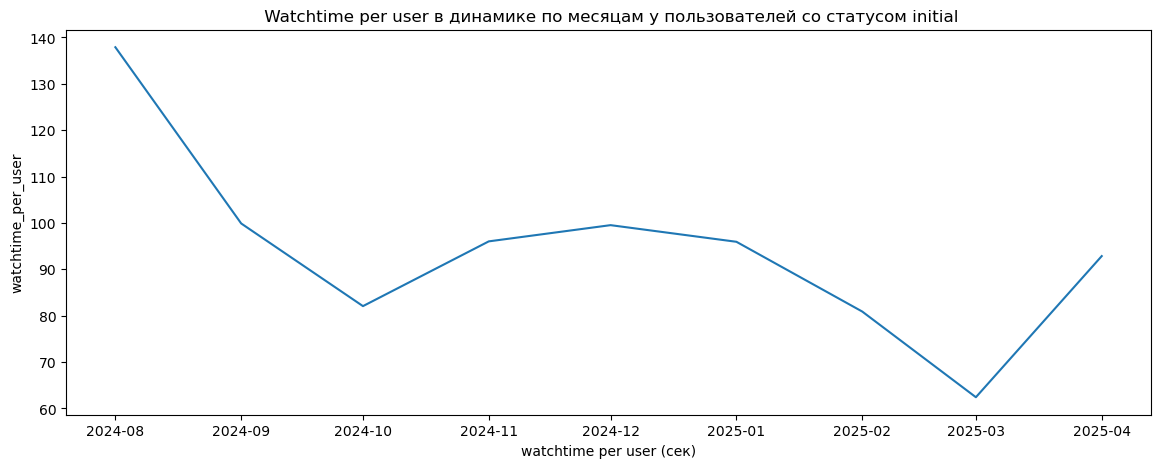

In [115]:
result['created_invoice_max'] = result.groupby(['user_id'])['invoice_created_at'].transform('max')

result_initial = result.groupby(['profile_id','reg_month'])['user_id'].nunique().reset_index()

merge = pd.merge(result_initial,df_watchtime[['date','date_month','profile_id','watchtime','item_type','source']],right_on = ['profile_id','date_month'], left_on = ['profile_id','reg_month'], how='inner')

merge_agg = merge.groupby('date_month').agg({'profile_id':'nunique','watchtime':'sum'}).reset_index()
merge_agg['watchtime_per_user'] = merge_agg['watchtime'] / merge_agg['profile_id']
merge_agg

plt.figure(figsize=(14,5))

sns.lineplot(merge_agg,x='date_month',y='watchtime_per_user')
plt.xlabel('watchtime per user (сек)')
plt.title (' Watchtime per user в динамике по месяцам у пользователей со статусом initial')
plt.show()

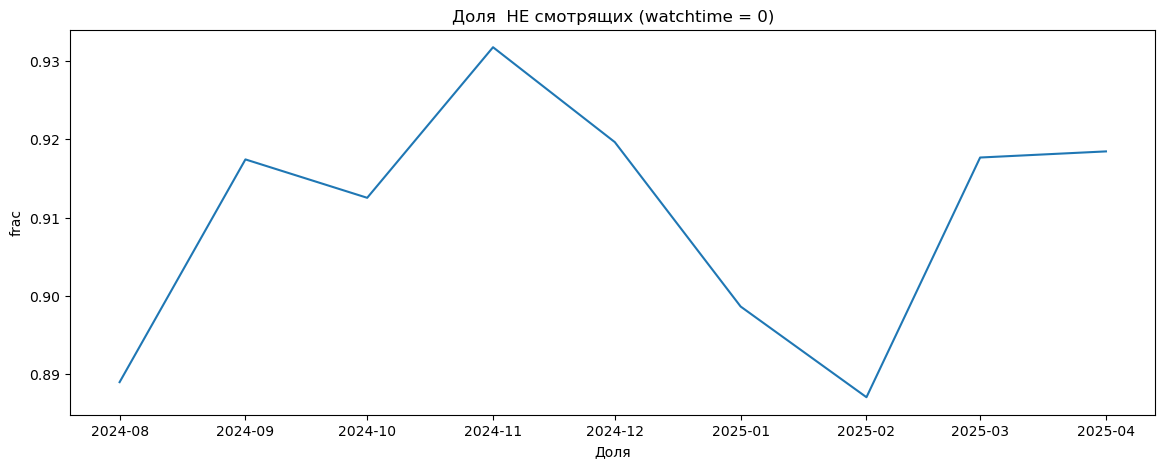

In [132]:
t = merge[merge['watchtime']==0].groupby('reg_month')['profile_id'].nunique().reset_index()
d = merge.groupby('reg_month')['profile_id'].nunique().reset_index()
m = pd.merge(t,d,how='left',on='reg_month')

m['frac'] = m['profile_id_x'] / m['profile_id_y']

plt.figure(figsize=(14,5))

sns.lineplot(m,x='reg_month',y='frac')
plt.xlabel('Доля')
plt.title ('Доля  НЕ смотрящих (watchtime = 0)')
plt.show()

In [140]:
round(m['frac'].median(),2)

0.92

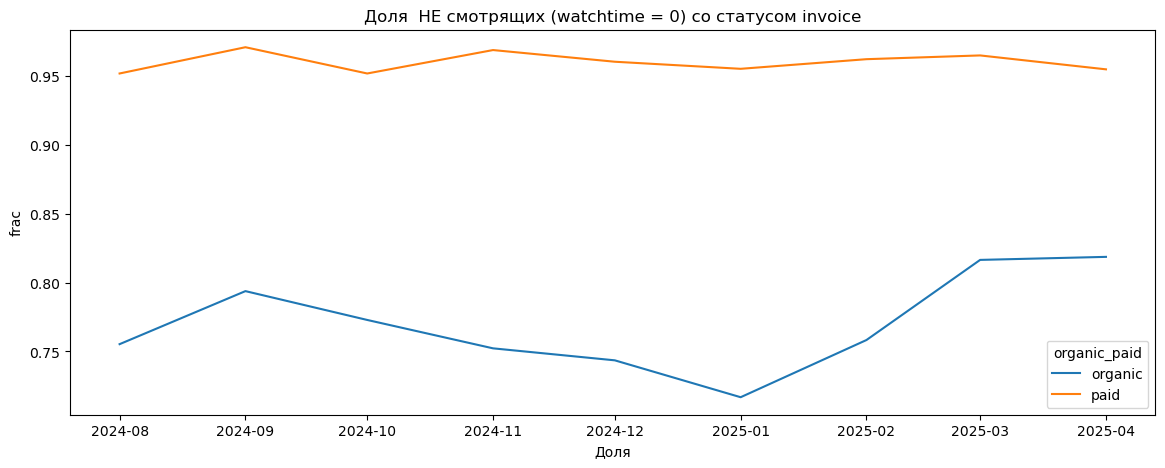

In [199]:
merge['organic_paid'] = merge['source'].apply(lambda x:'organic' if x == '' else 'paid')
t = merge[merge['watchtime']==0].groupby(['reg_month','organic_paid'])['profile_id'].nunique().reset_index()
d = merge.groupby(['reg_month','organic_paid'])['profile_id'].nunique().reset_index()
m = pd.merge(t,d,how='left',on=['reg_month','organic_paid'])


m['frac'] = m['profile_id_x'] / m['profile_id_y']

plt.figure(figsize=(14,5))

sns.lineplot(m,x='reg_month',y='frac',hue='organic_paid')
plt.xlabel('Доля')
plt.title ('Доля  НЕ смотрящих (watchtime = 0) со статусом invoice')
plt.show()

In [201]:
round(m.groupby('organic_paid')['frac'].median(),3)

organic_paid
organic    0.758
paid       0.961
Name: frac, dtype: float64

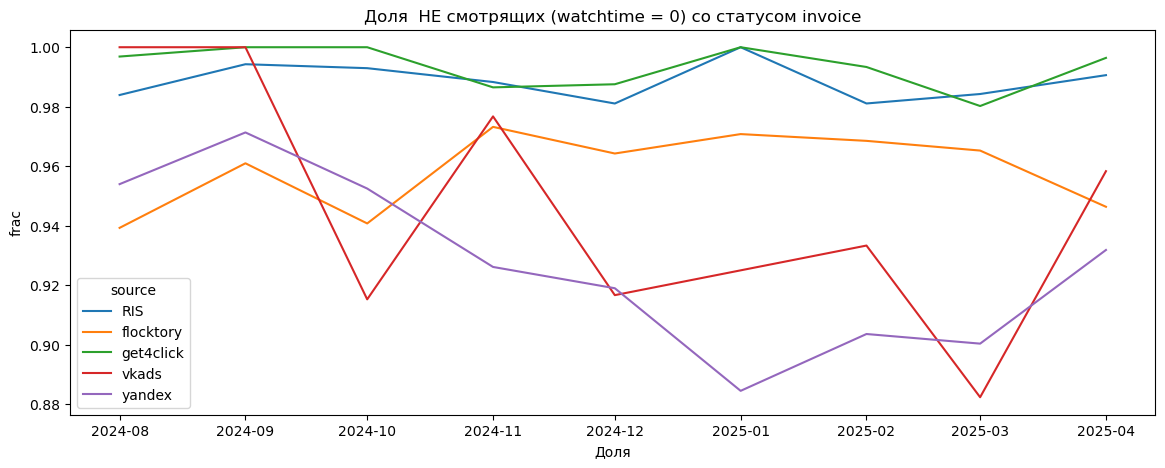

In [203]:
t = merge[merge['watchtime']==0].groupby(['reg_month','source'])['profile_id'].nunique().reset_index()
d = merge.groupby(['reg_month','source'])['profile_id'].nunique().reset_index()
m = pd.merge(t,d,how='left',on=['reg_month','source'])


m['frac'] = m['profile_id_x'] / m['profile_id_y']

source = ['RIS','flocktory','yandex','get4click','vkads','google']
plt.figure(figsize=(14,5))

sns.lineplot(m[m['source'].isin(source)],x='reg_month',y='frac',hue='source')
plt.xlabel('Доля')
plt.title ('Доля  НЕ смотрящих (watchtime = 0) со статусом invoice')
plt.show()

In [205]:
round(m[m['source'].isin(source)].groupby('source')['frac'].median(),3)

source
RIS          0.988
flocktory    0.964
get4click    0.996
vkads        0.933
yandex       0.926
Name: frac, dtype: float64

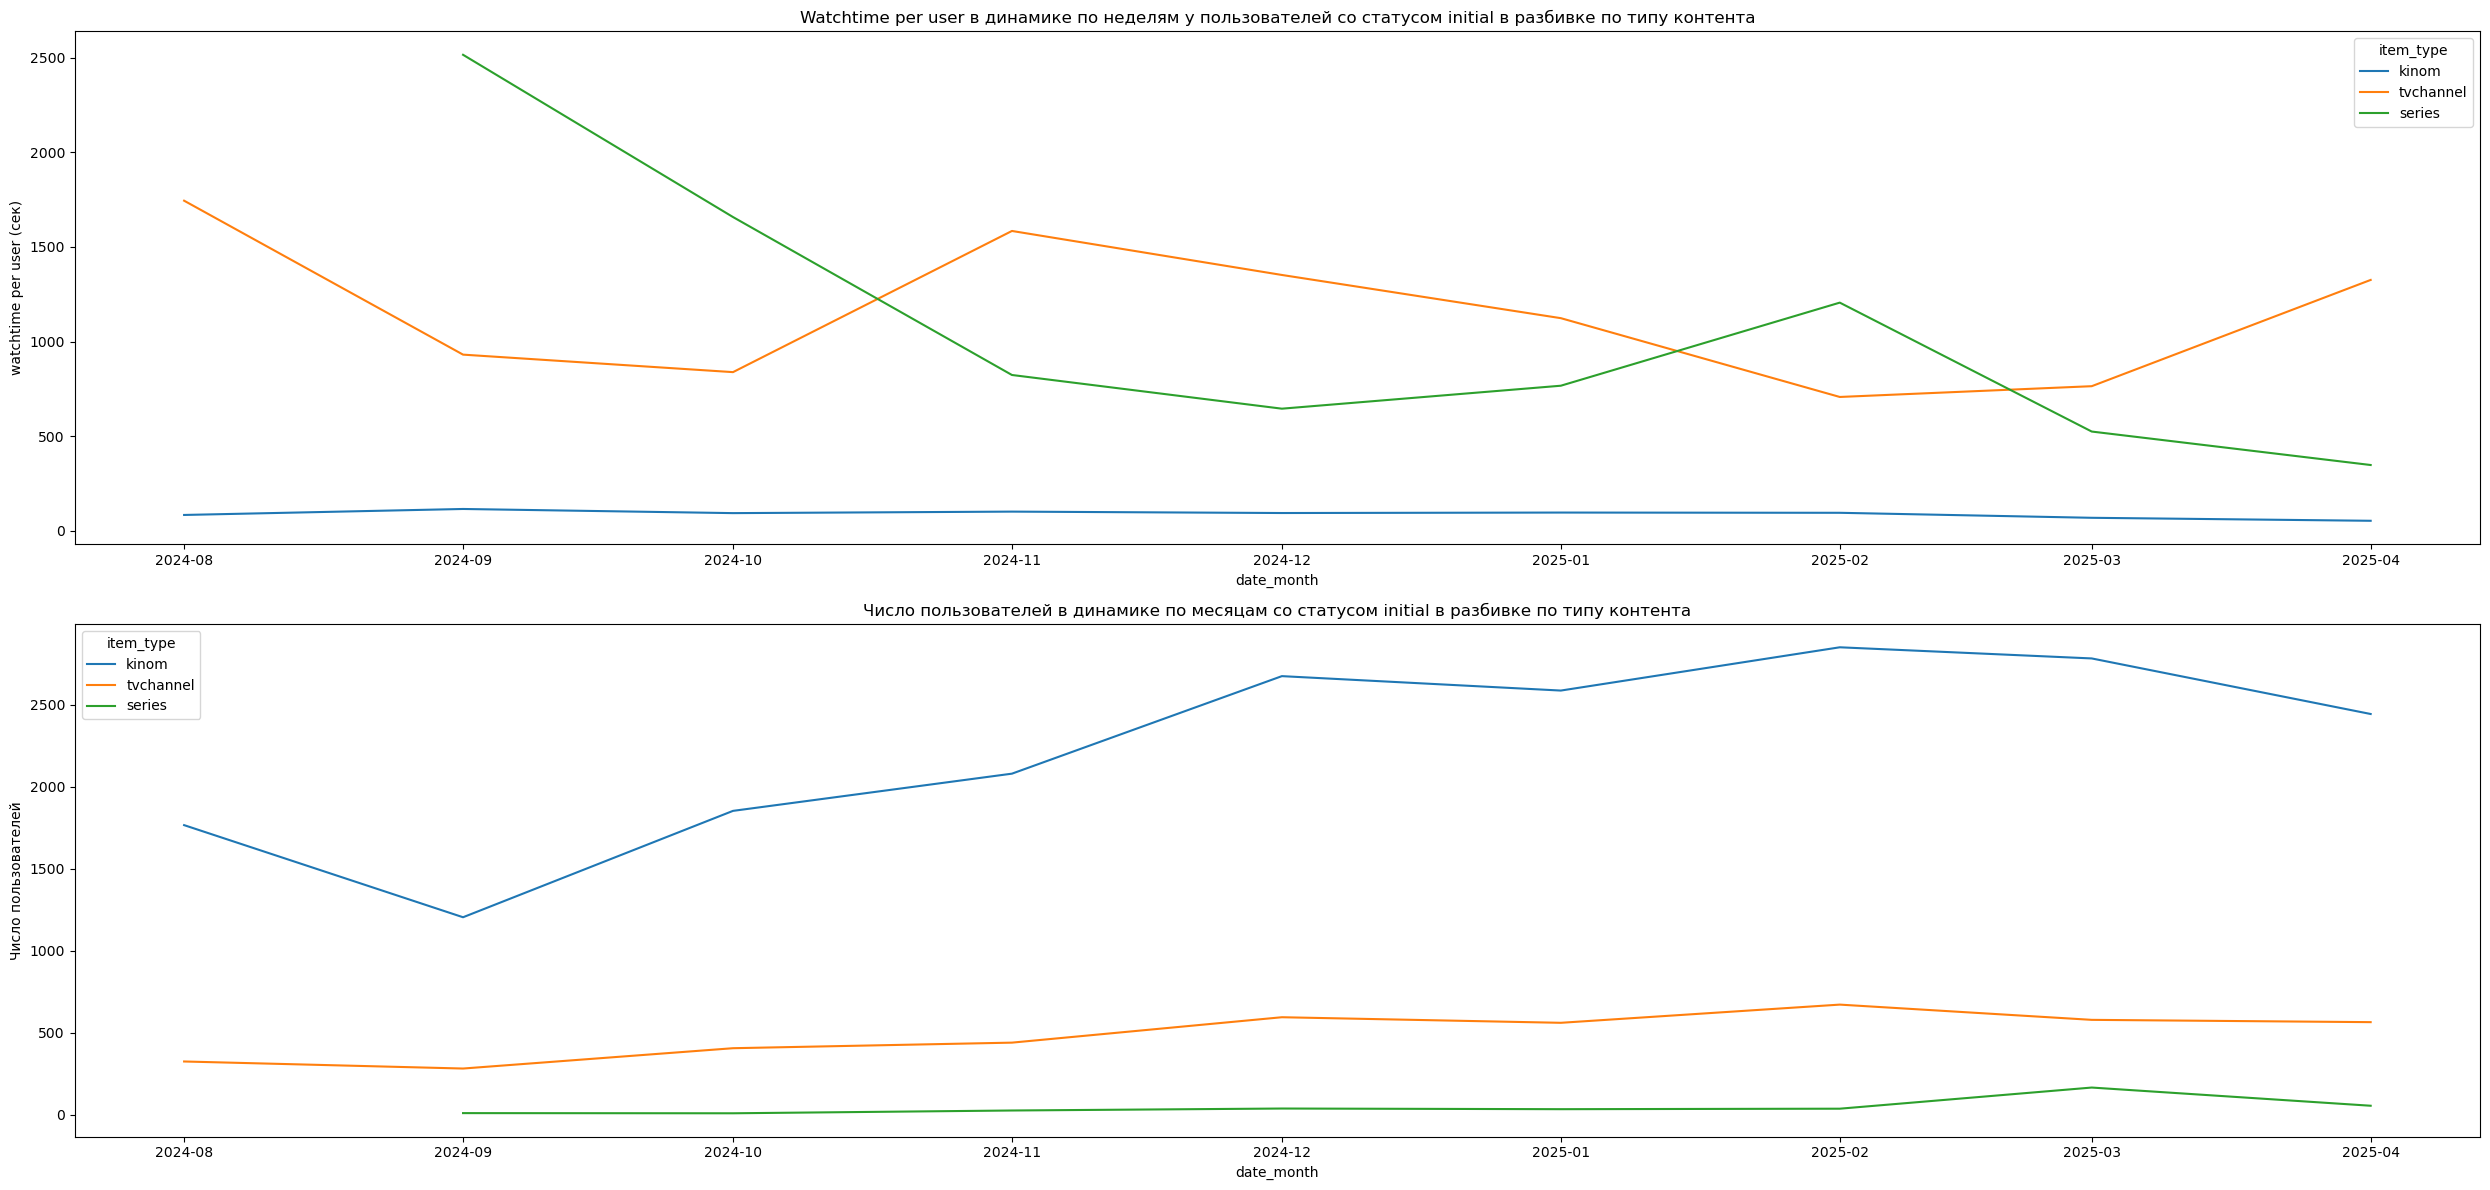

In [207]:
merge_agg = merge[merge['watchtime']>0].groupby(['date_month','item_type']).agg({'profile_id':'nunique','watchtime':'sum'}).reset_index()
merge_agg['watchtime_per_user'] = merge_agg['watchtime'] / merge_agg['profile_id']

merge_agg = merge_agg[merge_agg['item_type'].isin(['kinom','tvchannel','series'])]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(25,12))

lineplot = sns.lineplot(merge_agg,x='date_month',y='watchtime_per_user',hue='item_type',ax=ax1)
ax1.set_ylabel('watchtime per user (сек)')
ax1.set_title ('Watchtime per user в динамике по неделям у пользователей со статусом initial в разбивке по типу контента')


lineplot = sns.lineplot(merge_agg,x='date_month',y='profile_id',hue='item_type',ax=ax2)
ax2.set_ylabel('Число пользователей')
ax2.set_title ('Число пользователей в динамике по месяцам со статусом initial в разбивке по типу контента')


plt.subplots_adjust(hspace=5)  # Increase this value for more space      
plt.tight_layout() 
plt.show()

In [209]:
m = merge[merge['watchtime']!=0].groupby(['date_month','item_type']).agg({'profile_id':'nunique','watchtime':'sum'}).reset_index()

print('Число пользователей со статусом invoice, которые смотрели какой-то контент:')
print()
print(m[m['item_type'].isin(['kinom','series','tvchannel'])].groupby(['item_type'])['profile_id'].median())

Число пользователей со статусом invoice, которые смотрели какой-то контент:

item_type
kinom        2445.0
series         35.5
tvchannel     561.0
Name: profile_id, dtype: float64


In [211]:
m = merge[merge['watchtime']!=0].groupby(['date_month','item_type']).agg({'profile_id':'nunique','watchtime':'sum'}).reset_index()
m['watchtime_per_user'] = m['watchtime'] / m['profile_id']
print('Число пользователей со статусом invoice, которые смотрели какой-то контент:')
print()
print(round(m[m['item_type'].isin(['kinom','series','tvchannel'])].groupby(['item_type'])['watchtime_per_user'].median(),0))

Число пользователей со статусом invoice, которые смотрели какой-то контент:

item_type
kinom          94.0
series        795.0
tvchannel    1124.0
Name: watchtime_per_user, dtype: float64


## Как возвращались пользователи после initial 

In [214]:
query = ''' SELECT date,profile_id,user_id,source FROM datamarts.clean_event GROUP BY 1,2,3,4 '''

df_retention = execute(query,user='kmekhtiev')
df_retention['date'] = pd.to_datetime(df_retention['date'])

Время выполнения функции: 17.3824 секунд



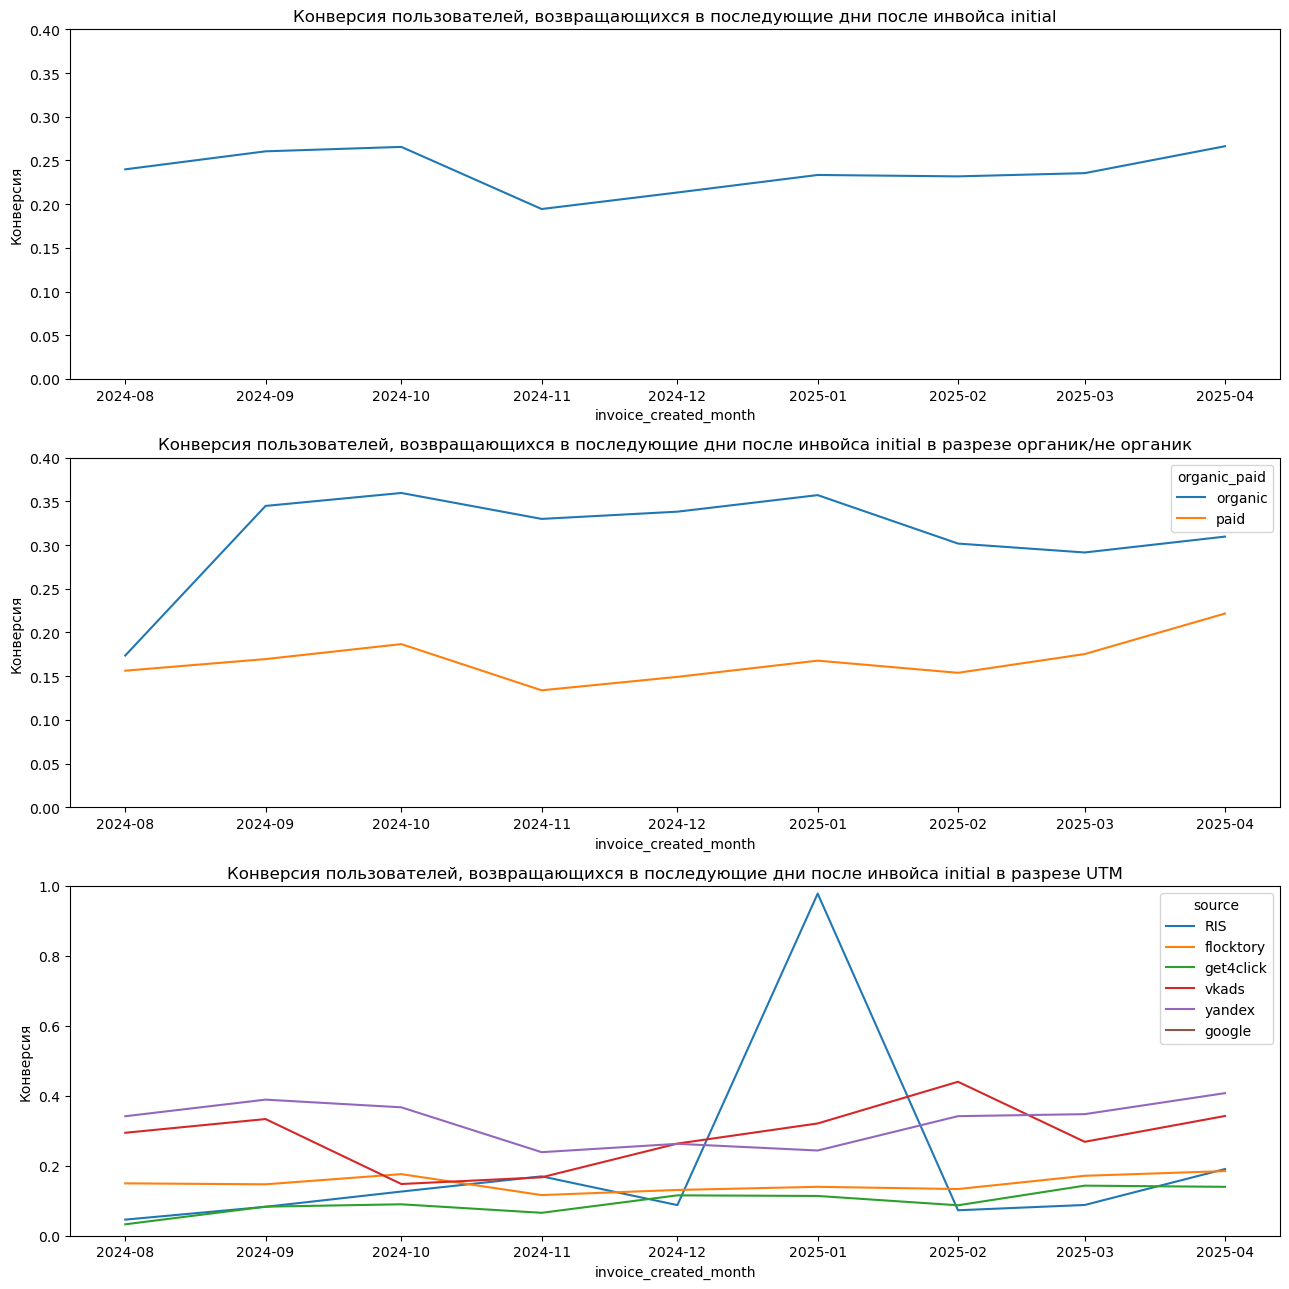

In [222]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(13,13),dpi=100)

r = result.groupby('user_id')[['invoice_created_at','invoice_created_month']].max().reset_index()
m = pd.merge(df_retention,r,how='inner',on='user_id')
m['flag'] = m['invoice_created_at'] == m['date']
f = m[m['flag']== False].groupby('invoice_created_month')['user_id'].nunique()
f = pd.merge(f,m.groupby('invoice_created_month')['user_id'].nunique(),how='left',on='invoice_created_month').reset_index()
f['cr'] = f['user_id_x'] / f['user_id_y']

f['invoice_created_month'] = f['invoice_created_month'].dt.to_timestamp()
sns.lineplot(data=f, x='invoice_created_month', y='cr',ax = ax1)
ax1.set_ylabel('Конверсия')
ax1.set_title('Конверсия пользователей, возвращающихся в последующие дни после инвойса initial')
ax1.set_ylim(bottom = 0,top = 0.4)



# 2-ой график
r = result.groupby('user_id')[['invoice_created_at','invoice_created_month']].max().reset_index()
m = pd.merge(df_retention,r,how='inner',on='user_id')
m['flag'] = m['invoice_created_at'] == m['date']
m['organic_paid'] = m['source'].apply(lambda x:'organic' if x=='' else 'paid')

f2 = m[m['flag']== False].groupby(['invoice_created_month','organic_paid'])['user_id'].nunique().reset_index()
f2 = pd.merge(f2,m.groupby(['invoice_created_month','organic_paid'])['user_id'].nunique(),how='left',on=['invoice_created_month','organic_paid'])
f2['cr'] = f2['user_id_x'] / f2['user_id_y']
f2['invoice_created_month'] = f2['invoice_created_month'].dt.to_timestamp()


sns.lineplot(data=f2, x='invoice_created_month', y='cr',ax = ax2, hue='organic_paid')
ax2.set_ylabel('Конверсия')
ax2.set_title('Конверсия пользователей, возвращающихся в последующие дни после инвойса initial в разрезе органик/не органик')
ax2.set_ylim(bottom = 0,top = 0.4)


#3ий график
source = ['RIS','flocktory','yandex','get4click','vkads','google']
r = result.groupby('user_id')[['invoice_created_at','invoice_created_month']].max().reset_index()
m = pd.merge(df_retention,r,how='inner',on='user_id')
m['flag'] = m['invoice_created_at'] == m['date']

f3 = m[m['flag']== False].groupby(['invoice_created_month','source'])['user_id'].nunique().reset_index()
f3 = pd.merge(f3,m.groupby(['invoice_created_month','source'])['user_id'].nunique(),how='left',on=['invoice_created_month','source'])
f3['cr'] = f3['user_id_x'] / f3['user_id_y']
f3['invoice_created_month'] = f3['invoice_created_month'].dt.to_timestamp()


sns.lineplot(data=f3[f3['source'].isin(source)], x='invoice_created_month', y='cr',ax = ax3, hue='source')
ax3.set_ylabel('Конверсия')
ax3.set_title('Конверсия пользователей, возвращающихся в последующие дни после инвойса initial в разрезе UTM')
ax3.set_ylim(bottom = 0,top = 1)


      
plt.tight_layout() 
plt.show()

In [592]:
query = f''' SELECT id,phone_number,email FROM raw.viju__product_x__public__users AS vpxpu
         WHERE created_at>='2024-10-01' 
         '''

df_email = execute(query,user='kmekhtiev')

Время выполнения функции: 24.843 секунд



In [612]:
email = pd.merge(result,df_email,how='left',left_on='user_id',right_on='id')

In [618]:
email[(email['source']=='flocktory') & (email['invoice_created_month']=='2025-04')]['email'].nunique()

2428

## Куда заходят

In [224]:
def add_features(new_data):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    sorted_mobile = new_data.sort_values(by=['session_id', 'date']).copy()
    # добавляем шаги событий
    sorted_mobile['step'] = sorted_mobile.groupby('profile_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_mobile['source'] = sorted_mobile['event_name']
    # добавляем целевые узлы
    sorted_mobile['target'] = sorted_mobile.groupby('session_id')['source'].shift(-1)
    
    return sorted_mobile.drop(['event_name'], axis=1)

In [226]:
def add_features(new_data,id):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    sorted_mobile = new_data.sort_values(by=['session_id', 'date']).copy()
    # добавляем шаги событий
    sorted_mobile['step'] = sorted_mobile.groupby(id).cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_mobile['source'] = sorted_mobile['event_name']
    # добавляем целевые узлы
    sorted_mobile['target'] = sorted_mobile.groupby('session_id')['source'].shift(-1)
    
    return sorted_mobile.drop(['event_name'], axis=1)

In [228]:
def get_source_index(new_data):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(new_data['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = new_data[new_data['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict

In [230]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [232]:
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = {"custom_colors": ["rgba(42, 157, 143, 1)", "rgba(38, 70, 83, 1)", "rgba(233, 196, 106, 1)", "rgba(244, 162, 97, 1)", "rgba(231, 111, 81, 1)", "rgba(230, 57, 70, 1)", "rgba(168, 218, 220, 1)", "rgba(69, 123, 157, 1)", "rgba(29, 53, 87, 1)", "rgba(107, 112, 92, 1)", "rgba(183, 183, 164, 1)", "rgba(221, 190, 169, 1)", "rgba(142, 202, 230, 1)", "rgba(33, 158, 188, 1)", "rgba(2, 48, 71, 1)", "rgba(255, 183, 3, 1)", "rgba(251, 133, 0, 1)", "rgba(153, 217, 140, 1)", "rgba(118, 200, 147, 1)", "rgba(52, 160, 164, 1)", "rgba(26, 117, 159, 1)", "rgba(247, 37, 133, 1)", "rgba(181, 23, 158, 1)", "rgba(114, 9, 183, 1)", "rgba(86, 11, 173, 1)", "rgba(72, 149, 239, 1)", "rgba(76, 201, 240, 1)", "rgba(242, 132, 130, 1)", "rgba(132, 165, 157, 1)", "rgba(246, 189, 96, 1)", "rgba(187, 62, 3, 1)", "rgba(204, 213, 174, 1)", "rgba(233, 237, 201, 1)", "rgba(254, 250, 224, 1)", "rgba(212, 163, 115, 1)", "rgba(96, 108, 56, 1)", "rgba(40, 54, 24, 1)", "rgba(249, 199, 79, 1)", "rgba(144, 190, 109, 1)", "rgba(67, 170, 139, 1)", "rgba(77, 144, 142, 1)", "rgba(87, 117, 144, 1)", "rgba(39, 125, 161, 1)", "rgba(239, 71, 111, 1)", "rgba(255, 209, 102, 1)", "rgba(6, 214, 160, 1)", "rgba(17, 138, 178, 1)", "rgba(7, 59, 76, 1)", "rgba(0, 53, 102, 1)", "rgba(226, 175, 255, 1)", "rgba(248, 173, 157, 1)", "rgba(211, 211, 211, 1)", "rgba(254, 228, 64, 1)", "rgba(241, 91, 181, 1)", "rgba(155, 93, 229, 1)", "rgba(0, 187, 249, 1)", "rgba(0, 245, 212, 1)", "rgba(130, 192, 204, 1)", "rgba(128, 185, 24, 1)", "rgba(43, 147, 72, 1)"]}
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict

In [234]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [236]:
from plotly import graph_objects as go
import plotly.io as pio  

def lists_for_plot(source_indexes, colors, frac=30):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []
    

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue
        

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in (temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}

In [238]:
def plot_senkey_diagram(data_dict, file_name="sankey_diagram.html",chart_name='Sankay Diagram'):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text=chart_name, font_size=10, width=1500, height=800)
    
    # Сохраняем график в HTML файл  
    pio.write_html(fig, file=file_name, auto_open=True)  
    
    # возвращаем объект диаграммы
    return fig.show()

In [496]:
query = f'''
            SELECT 
            date,
            utc_timestamp,
            visitor_id,
            user_id,
            profile_id,
            session_id,
            event_name,
            client_type
            FROM datamarts.clean_event AS t1
            WHERE date BETWEEN '2025-03-01'  AND '2025-04-30'  -- Изменение дат!!!!!!!!!!!!!!
            AND event_name!='goto_offer_page'
            AND user_id IS NOT NULL AND client_type IN ('web_mobile')
'''

df_event = execute(query,user='kmekhtiev')

Время выполнения функции: 131.57 секунд



In [548]:
arr = result['user_id'].unique()
events = df_event.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending = False).head(50)['event_name']
df_event_all = df_event[df_event['user_id'].isin(arr)]
df_event_special = df_event_all[df_event_all['event_name'].isin(events)].sort_values(by='utc_timestamp')

In [549]:
print(result['user_id'].nunique())
print(df_event_all['user_id'].nunique())

78360
16941


In [550]:
df_wo_dublicate = df_event_special.drop_duplicates(subset=['session_id','event_name'])

df_add = add_features(df_wo_dublicate,id='visitor_id') # 1-ая функция
# plt.figure(figsize=(10,6))
# sns.histplot(df_add['step'])
# plt.xticks(range(int(df_add['step'].min()), int(df_add['step'].max()) + 1,5),rotation=45)  
# plt.yticks(range(0, int(df_add['step'].value_counts().max())+500,500))
# plt.show()

Шаг: 100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


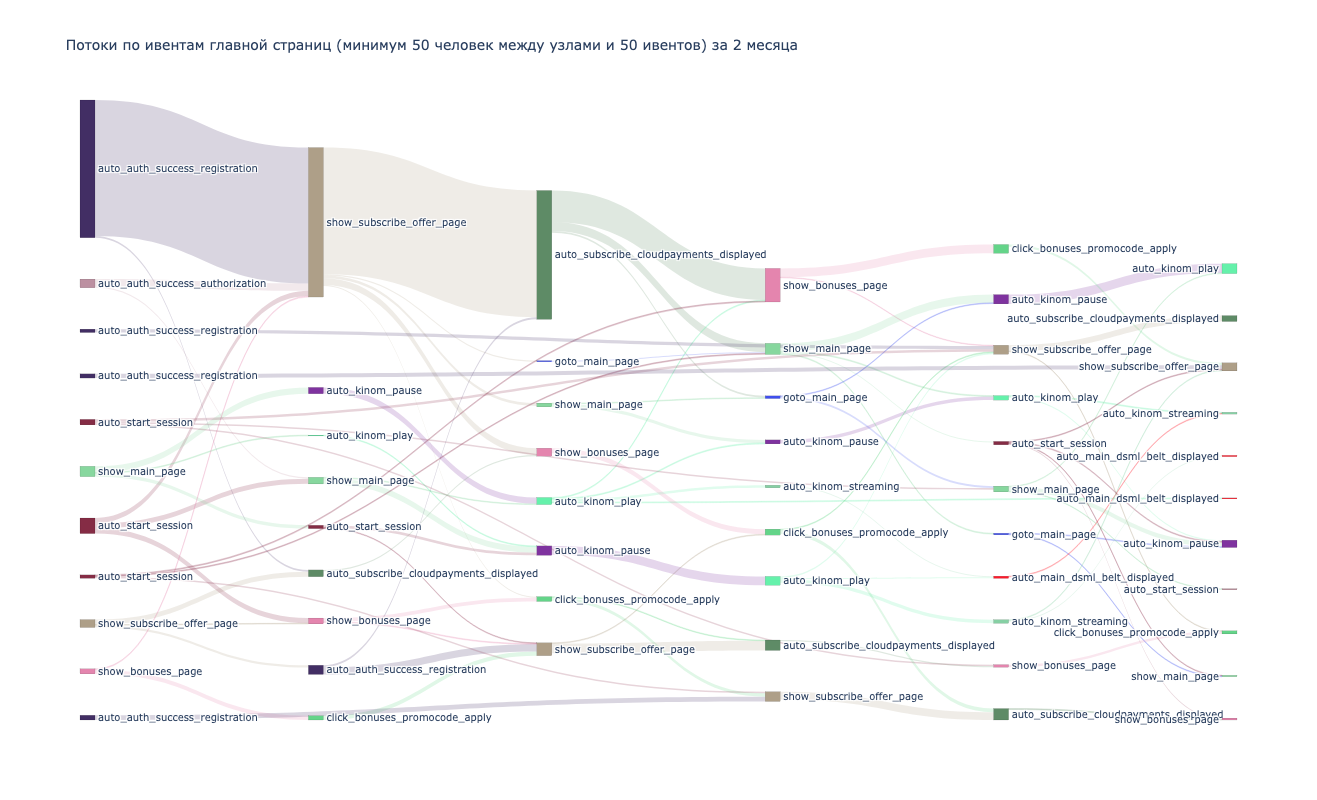

In [551]:
# Ставим ограничение на число шагов в сценарии
df_comp = df_add[df_add['step']<7].copy().reset_index(drop=True)

# создаем словарь
source_indexes = get_source_index(df_comp) # 2-ая функция

# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='random') # 3-ая функция

 
data_for_plot = lists_for_plot(source_indexes,colors_dict, frac = 50)  # 4-ая функция. Задаем число пользователей 

# Рисуем график
senkey_diagram = plot_senkey_diagram(data_for_plot,file_name="sankey_diagram_main_events.html", chart_name = 'Потоки по ивентам главной страниц (минимум 50 человек между узлами и 50 ивентов) за 2 месяца') # финальная 5-ая функция 

### Flocktory

In [556]:
arr = result[result['source']=='flocktory']['user_id'].unique()
events = df_event.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending = False).head(50)['event_name']
df_event_flocktory = df_event[df_event['user_id'].isin(arr)]
df_event_special = df_event_flocktory[df_event_flocktory['event_name'].isin(events)].sort_values(by='utc_timestamp')

In [557]:
print(result[result['source']=='flocktory']['user_id'].nunique())
print(df_event_special['user_id'].nunique())

35427
6833


In [558]:
df_wo_dublicate = df_event_special.drop_duplicates(subset=['session_id','event_name'])

df_add = add_features(df_wo_dublicate,id='visitor_id') # 1-ая функция

Шаг: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


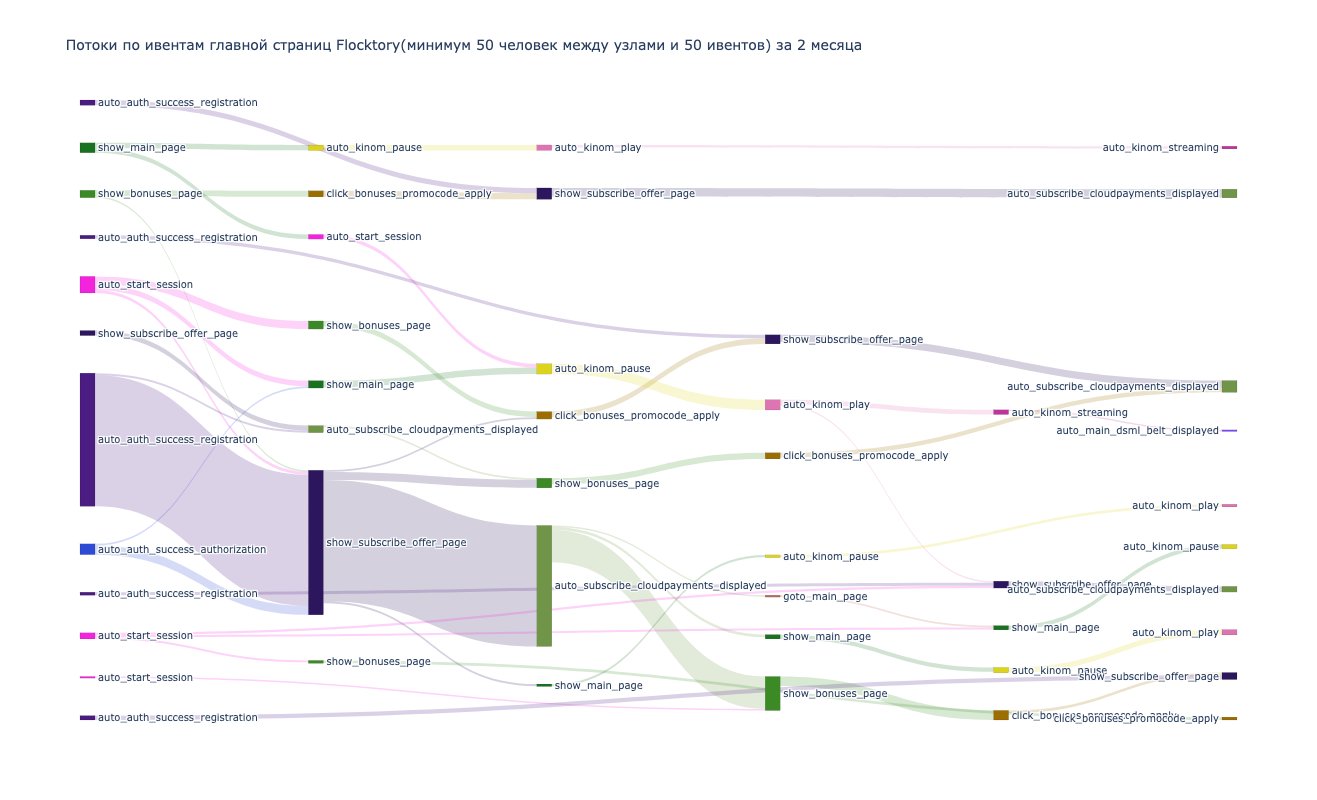

In [564]:
# Ставим ограничение на число шагов в сценарии
df_comp = df_add[df_add['step']<7].copy().reset_index(drop=True)

# создаем словарь
source_indexes = get_source_index(df_comp) # 2-ая функция

# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='random') # 3-ая функция

 
data_for_plot = lists_for_plot(source_indexes,colors_dict, frac = 50)  # 4-ая функция. Задаем число пользователей 

# Рисуем график
senkey_diagram = plot_senkey_diagram(data_for_plot,file_name="sankey_diagram_main_events.html", chart_name = 'Потоки по ивентам главной страниц Flocktory(минимум 50 человек между узлами и 50 ивентов) за 2 месяца') # финальная 5-ая функция 

In [541]:
pd.read_csv('output.csv')['user_id']

0      0373b36b-f0d3-40b4-81e6-ee754d0790cc
1      0ccc9ea0-e90a-4206-b041-c1328dcd6eed
2      583943d4-7048-4c4b-91ca-6edfb27f492b
3      be926d15-6b38-4e6e-9f75-d7a8c05c4828
4      2501d5e7-0eff-4f9a-9d26-b030ce5f3da9
                       ...                 
239    1b62e5c9-46de-49e6-b0ba-745961080f1f
240    9bbd09bc-e74c-44c8-a87f-b9b93ca55787
241    c7c1e622-3c9f-4f30-9e59-f115da3ef5e8
242    004b595d-bdff-4ebc-aa52-16c9e4b40a44
243    ab5f33b1-c1e0-439a-9299-74cf9d8c1dc8
Name: user_id, Length: 244, dtype: object

In [ ]:
t = df_initial[df_initial['invoice_created_at']=='2025-04-30']#.isin(pd.read_csv('output.csv')['user_id'])]
t[t['user_id'].isin(pd.read_csv('output.csv')['user_id'])].groupby('invoice_created_at')['user_id'].nunique()

In [ ]:
t[t['user_id'].isin(pd.read_csv('output.csv')['user_id'])].groupby('price_currency')['price_cents'].sum()/100

In [ ]:
t['p

In [ ]:
query = '''
SELECT date,user_id,payload,reg_date,created_at::date AS created_at, 
first_prolong_date::date AS first_prolong_date,
JSONExtractString(payload,'auth') AS auth
FROM datamarts.clean_event
WHERE utc_timestamp>='2025-04-28 14:00:00' AND event_name='auto_auth_success_authorization'
GROUP BY 1,2,3,4,5,6,7
'''

df_yandex = execute(query,user='kmekhtiev')

In [ ]:
df_yandex[df_yandex['user_id'].isin(pd.read_csv('users.csv',header=None)[0])].head(10)

In [ ]:
query = '''
SELECT max(date) AS date_max,user_id,created_at::date AS created_at, first_prolong_date::date AS first_prolong_date
FROM datamarts.clean_event
WHERE date>='2024-01-01'
GROUP BY 2,3,4
'''

df_yandex = execute(query,user='kmekhtiev')
df_yandex['date_max'] = pd.to_datetime(df_yandex['date_max'])
df_yandex['date_month'] = df_yandex['date_max'].dt.to_period('M')
df_yandex['created_at'] = pd.to_datetime(df_yandex['created_at'])
df_yandex['created_month'] = df_yandex['created_at'].dt.to_period('M')
df_yandex['date_month'] = df_yandex['date_max'].dt.to_period('M')
df_yandex['first_prolong_date'] = pd.to_datetime(df_yandex['first_prolong_date'])
df_yandex['first_prolong_date'] = df_yandex['first_prolong_date'].dt.to_period('M')

In [ ]:
r = df_yandex[df_yandex['user_id'].isin(pd.read_csv('users.csv',header=None)[0])]
r.groupby('date_month')['user_id'].nunique()

In [ ]:
r.groupby('created_month')['user_id'].nunique()

In [ ]:
r.groupby('first_prolong_date')['user_id'].nunique()